In [52]:
#importing all the required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from datetime import datetime, timedelta
import random
import networkx as nx
import collections
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math
import torch
import torch.nn as nn


In [2]:
data = pd.read_csv('/content/data.csv')
print(data.describe())
print(data.head())
print(data.dtypes)
print(len(data), "total no of pitch data given")

                PID   INNING_KEY  BATTER_IN_INNING_KEY  PITCH_NUMBER  \
count   9889.000000  9889.000000           9889.000000   9889.000000   
mean   12609.406007     5.007786              2.935079      2.878653   
std     7802.242707     2.660815              1.741784      1.714279   
min        0.000000     1.000000              1.000000      1.000000   
25%     6004.000000     3.000000              2.000000      1.000000   
50%    12590.000000     5.000000              3.000000      3.000000   
75%    19511.000000     7.000000              4.000000      4.000000   
max    28755.000000    11.000000             14.000000     14.000000   

           OUT_KEY        BALLS      STRIKES  IS_RUNNER_ON_1B  \
count  9889.000000  9889.000000  9889.000000      9889.000000   
mean      0.997674     0.882293     0.874810         0.309839   
std       0.822356     0.965159     0.822483         0.462451   
min       0.000000     0.000000     0.000000         0.000000   
25%       0.000000     0.0

Statistics - To understand relationship between the variables

In [7]:
#chi square test - its usually performed on categorical variables(object type)
# performing chi square test on pairwise variables

df = data
list = []
chi_square_results = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Chi-Square Statistic', 'P-Value'])
for var1 in df.select_dtypes(include=['object']).columns:
  for var2 in df.select_dtypes(include=['object']).columns:
    if var1 != var2:
      contingency_table = pd.crosstab(df[var1], df[var2])
      chi2, p, _, _ = chi2_contingency(contingency_table)
      result_df = pd.DataFrame({
            'Variable 1': [var1],
            'Variable 2': [var2],
            'Chi-Square Statistic': [chi2],
            'P-Value': [p]
        })

      list.append(result_df)
chi_square_results = pd.concat(list, ignore_index=True)
print(chi_square_results)

# from the above test we can conclude that
#pitch_result_key and event_result_key are very closely related since the p value is 0

                Variable 1              Variable 2  Chi-Square Statistic  \
0           THROW_SIDE_KEY  PITCH_TYPE_TRACKED_KEY            539.098066   
1           THROW_SIDE_KEY        EVENT_RESULT_KEY             23.182544   
2           THROW_SIDE_KEY        PITCH_RESULT_KEY              1.467559   
3   PITCH_TYPE_TRACKED_KEY          THROW_SIDE_KEY            539.098066   
4   PITCH_TYPE_TRACKED_KEY        EVENT_RESULT_KEY            309.404334   
5   PITCH_TYPE_TRACKED_KEY        PITCH_RESULT_KEY            364.095976   
6         EVENT_RESULT_KEY          THROW_SIDE_KEY             23.182544   
7         EVENT_RESULT_KEY  PITCH_TYPE_TRACKED_KEY            309.404334   
8         EVENT_RESULT_KEY        PITCH_RESULT_KEY           7804.033272   
9         PITCH_RESULT_KEY          THROW_SIDE_KEY              1.467559   
10        PITCH_RESULT_KEY  PITCH_TYPE_TRACKED_KEY            364.095976   
11        PITCH_RESULT_KEY        EVENT_RESULT_KEY           7804.033272   

          P

In [16]:
# Correlation Results between pairwise variables which have continuous values
# From below we can see that INDUCED_VERTICAL_BREAK has strong correlation with VERTICAL_APPROACH_ANGLE
# Since it was mentioned in the project that air influences both vertical and horizontal break,
#I am gonna consider variables that are strongly-positively correlated to vertical and horizontal break
continuous_vars = df.select_dtypes(include=['float64', 'int64'])
correlation_results = pd.DataFrame(columns=['Variable 1', 'Variable 2', "Pearson's Correlation", "Spearman's Correlation"])

for i in range(len(continuous_vars.columns)):
    for j in range(i + 1, len(continuous_vars.columns)):
        var1 = continuous_vars.columns[i]
        var2 = continuous_vars.columns[j]

        pearson_corr = df[var1].corr(df[var2])
        spearman_corr = df[var1].corr(df[var2], method='spearman')

        result_df = pd.DataFrame({
            'Variable 1': [var1],
            'Variable 2': [var2],
            "Pearson's Correlation": [pearson_corr],
            "Spearman's Correlation": [spearman_corr]
        })

        correlation_results = pd.concat([correlation_results, result_df], ignore_index=True)

print(correlation_results)
# Finding the strong positive/negative correlations between variables
threshold = 0.5
strong_positive_correlations = correlation_results[abs(correlation_results["Pearson's Correlation"]) >= threshold]
strong_negative_correlations = correlation_results[abs(correlation_results["Pearson's Correlation"]) <= -threshold]
print("Strong Positive Correlations:")
print(strong_positive_correlations)
print("Strong Negative Correlations:")
print(strong_negative_correlations)

                    Variable 1            Variable 2  Pearson's Correlation  \
0                          PID            INNING_KEY               0.048450   
1                          PID  BATTER_IN_INNING_KEY               0.007162   
2                          PID          PITCH_NUMBER               0.007894   
3                          PID               OUT_KEY               0.000713   
4                          PID                 BALLS               0.019552   
..                         ...                   ...                    ...   
226  HORIZONTAL_APPROACH_ANGLE               PLATE_X               0.573896   
227  HORIZONTAL_APPROACH_ANGLE               PLATE_Z              -0.072303   
228    VERTICAL_APPROACH_ANGLE               PLATE_X              -0.124028   
229    VERTICAL_APPROACH_ANGLE               PLATE_Z               0.779972   
230                    PLATE_X               PLATE_Z              -0.195180   

     Spearman's Correlation  
0                  0.

R    7268
L    2621
Name: THROW_SIDE_KEY, dtype: int64


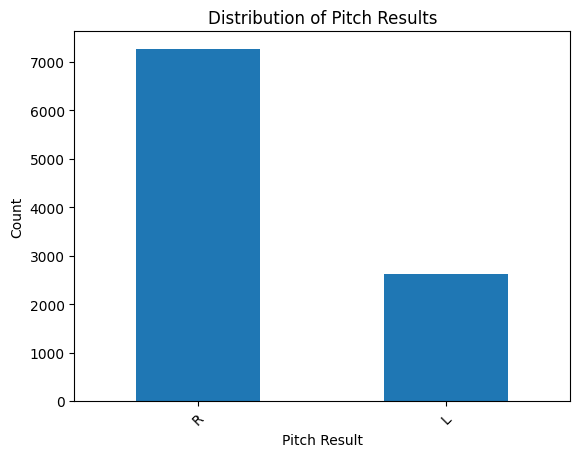

BallCalled        3579
FoulBall          1813
InPlay            1764
StrikeCalled      1593
StrikeSwinging    1102
HitByPitch          38
Name: PITCH_RESULT_KEY, dtype: int64
Chi-squared statistic: 1.4675586963508283
P-value: 0.9167828961718725


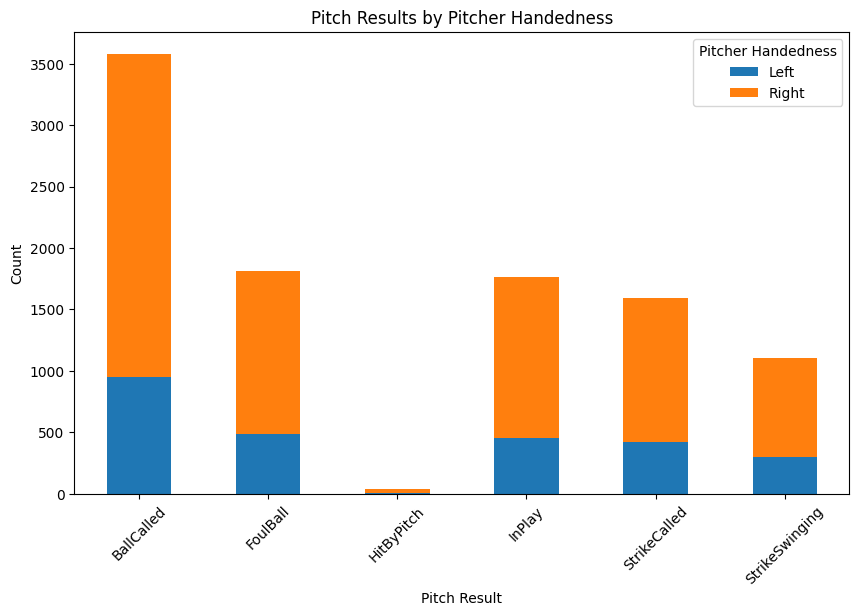

In [20]:
# some random analysis on pitch handedness and to check whether it plays any role anywhere
# the below describes the no of left vs right handed pitchers

result_counts = data['THROW_SIDE_KEY'].value_counts()
print(result_counts)
result_counts.plot(kind='bar')
plt.title('Distribution of Pitch Results')
plt.xlabel('Pitch Result')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


result_counts = data['PITCH_RESULT_KEY'].value_counts()
print(result_counts)


# plot on Pitch Results by Pitcher Handedness
contingency_table = pd.crosstab(data['PITCH_RESULT_KEY'], data['THROW_SIDE_KEY'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-squared statistic:", chi2)
print("P-value:", p)
ax = contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pitch Results by Pitcher Handedness')
plt.xlabel('Pitch Result')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Pitcher Handedness', loc='upper right', labels=['Left', 'Right'])
plt.show()



In [22]:
# Appending a new column date to the dataframe inorder to do some visualization later
# It was given that all the data is ordered by gamedate and game innings
# here im randomly assigning increasing for every new game

innings = 0
current_date = datetime(1980, 1, 1)
max_valid_date = datetime(2262, 4, 11)
for index, pitch in data.iterrows():
  if pitch["INNING_KEY"]>innings:
    innings = pitch["INNING_KEY"]
  else:
    current_date += timedelta(days=random.randint(1, 365))
    if current_date > max_valid_date:
      current_date = max_valid_date
    innings = pitch["INNING_KEY"]
  data.at[index, 'game_date'] = current_date

data_with_date = data

print(data_with_date.head())


    PID  INNING_KEY  BATTER_IN_INNING_KEY  PITCH_NUMBER  OUT_KEY  BALLS  \
0   197           1                     1             1        0      0   
1   348           1                     2             1        1      0   
2  1072           1                     2             2        1      1   
3   420           1                     3             1        1      0   
4   198           1                     3             2        1      0   

   STRIKES  IS_RUNNER_ON_1B  IS_RUNNER_ON_2B  IS_RUNNER_ON_3B  ...  \
0        0                0                0                0  ...   
1        0                0                0                0  ...   
2        0                0                0                0  ...   
3        0                1                0                0  ...   
4        1                1                0                0  ...   

   SPIN_RATE_ABSOLUTE RELEASE_SPEED RELEASE_SIDE RELEASE_HEIGHT  \
0         2402.459961    100.764999     -2.42717        6.085

In [23]:
#colums_to_convert are all the columns that have object type
columns_to_convert = ['THROW_SIDE_KEY', 'PITCH_TYPE_TRACKED_KEY', 'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY']
label_encoder = LabelEncoder()
for col in columns_to_convert:
    data[col] = label_encoder.fit_transform(data[col])

<ipython-input-25-701478d29785>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


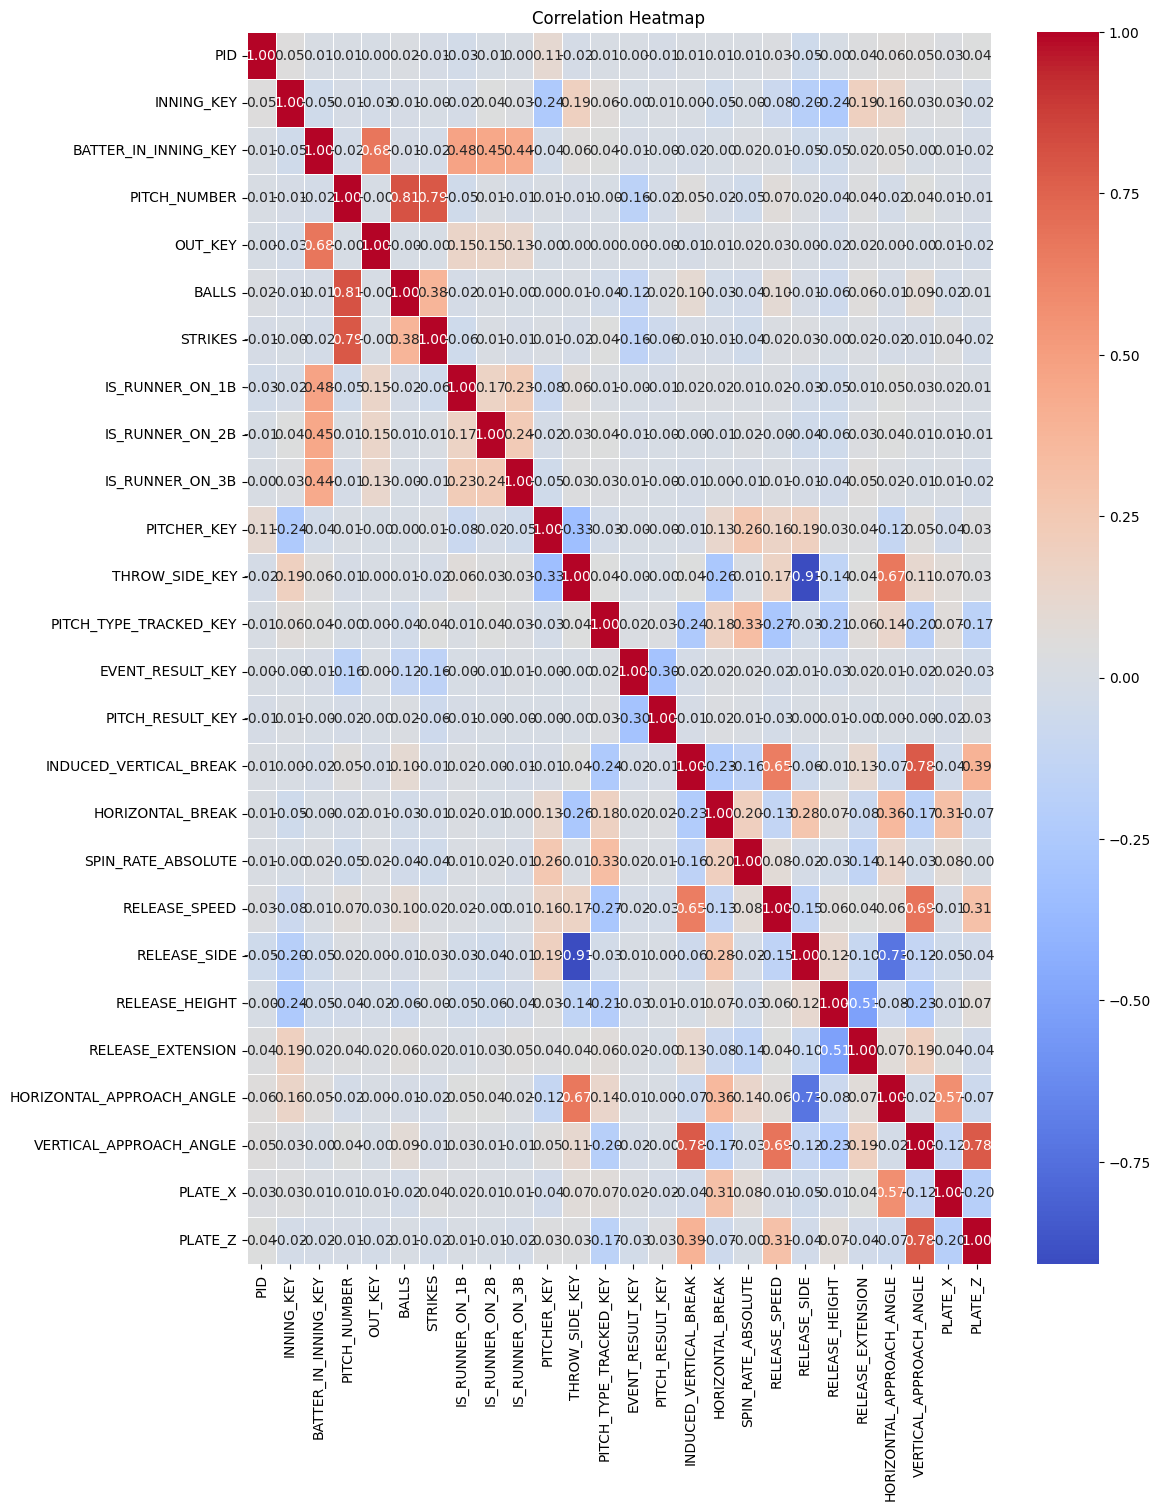

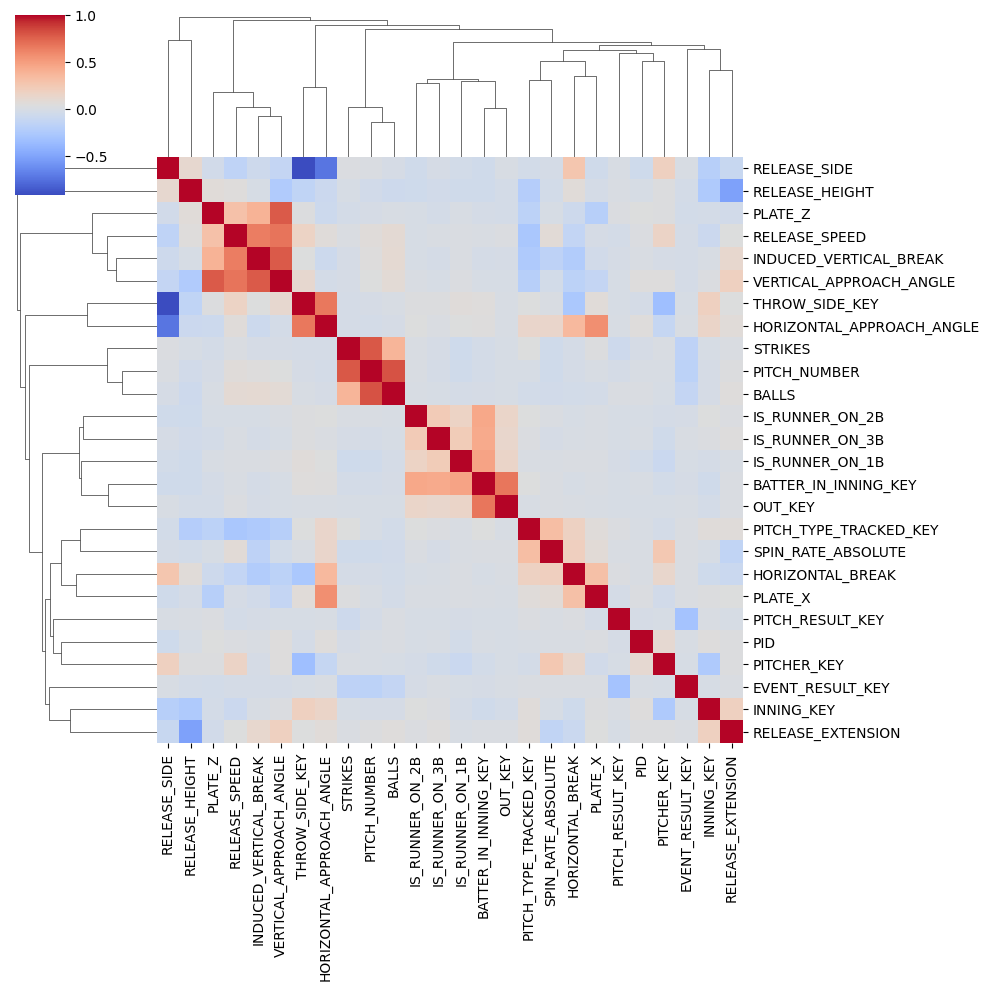

In [25]:
#correlation matrix/heatmap inorder to see the relationship between pairwise variables

correlation_matrix = data.corr()

plt.figure(figsize=(12, 16))  # Adjust the figure size here
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

sns.clustermap(correlation_matrix, cmap="coolwarm")

In [39]:
threshold = 0.35
related_attributes = collections.defaultdict(lambda: [])

for i in range(0, len(correlation_matrix.columns)):
    for j in range(0, len(correlation_matrix.columns)):
        if i != j and abs(correlation_matrix.iloc[i, j]) > threshold:
            related_attributes[correlation_matrix.columns[i]].append(correlation_matrix.columns[j])
# Its given that INDUCED_VERTICAL_BREAK and HORIZONTAL_BREAK are related to
#environmental factors - air which is related to dew/humidity
print(related_attributes["INDUCED_VERTICAL_BREAK"],"INDUCED_VERTICAL_BREAK")
print(related_attributes["HORIZONTAL_BREAK"],"HORIZONTAL_BREAK")

['RELEASE_SPEED', 'VERTICAL_APPROACH_ANGLE', 'PLATE_Z'] INDUCED_VERTICAL_BREAK
['HORIZONTAL_APPROACH_ANGLE'] HORIZONTAL_BREAK


{'RELEASE_SPEED', 'RELEASE_SIDE', 'PLATE_Z', 'THROW_SIDE_KEY', 'VERTICAL_APPROACH_ANGLE', 'HORIZONTAL_BREAK', 'INDUCED_VERTICAL_BREAK', 'PLATE_X'} columns that need to be considered


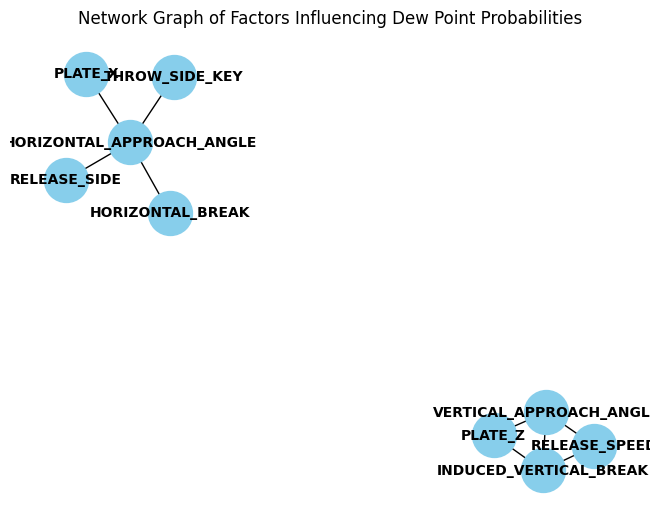

In [45]:
#the below network graph shows the strongly connected components(variables)
# we also obtain a final list of attributes by also considering closest attributes
# of the attributes closest to vertical/horizontal break
final_attributes_list = set()
G = nx.Graph()
factors = ["INDUCED_VERTICAL_BREAK","HORIZONTAL_BREAK"]
relationships = set()
final_attributes_list.add("INDUCED_VERTICAL_BREAK")
final_attributes_list.add("HORIZONTAL_BREAK")
for column in related_attributes["INDUCED_VERTICAL_BREAK"]:
  for col in related_attributes[column]:
    final_attributes_list.add(col)
    factors.append(col)
    relationships.add((column,col))
for column in related_attributes["HORIZONTAL_BREAK"]:
  for col in related_attributes[column]:
    final_attributes_list.add(col)
    factors.append(col)
    relationships.add((column,col))
print(final_attributes_list,"columns that need to be considered")
G.add_nodes_from(set(factors))
G.add_edges_from(relationships)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
plt.title('Network Graph of Factors Influencing Dew Point Probabilities')
plt.show()


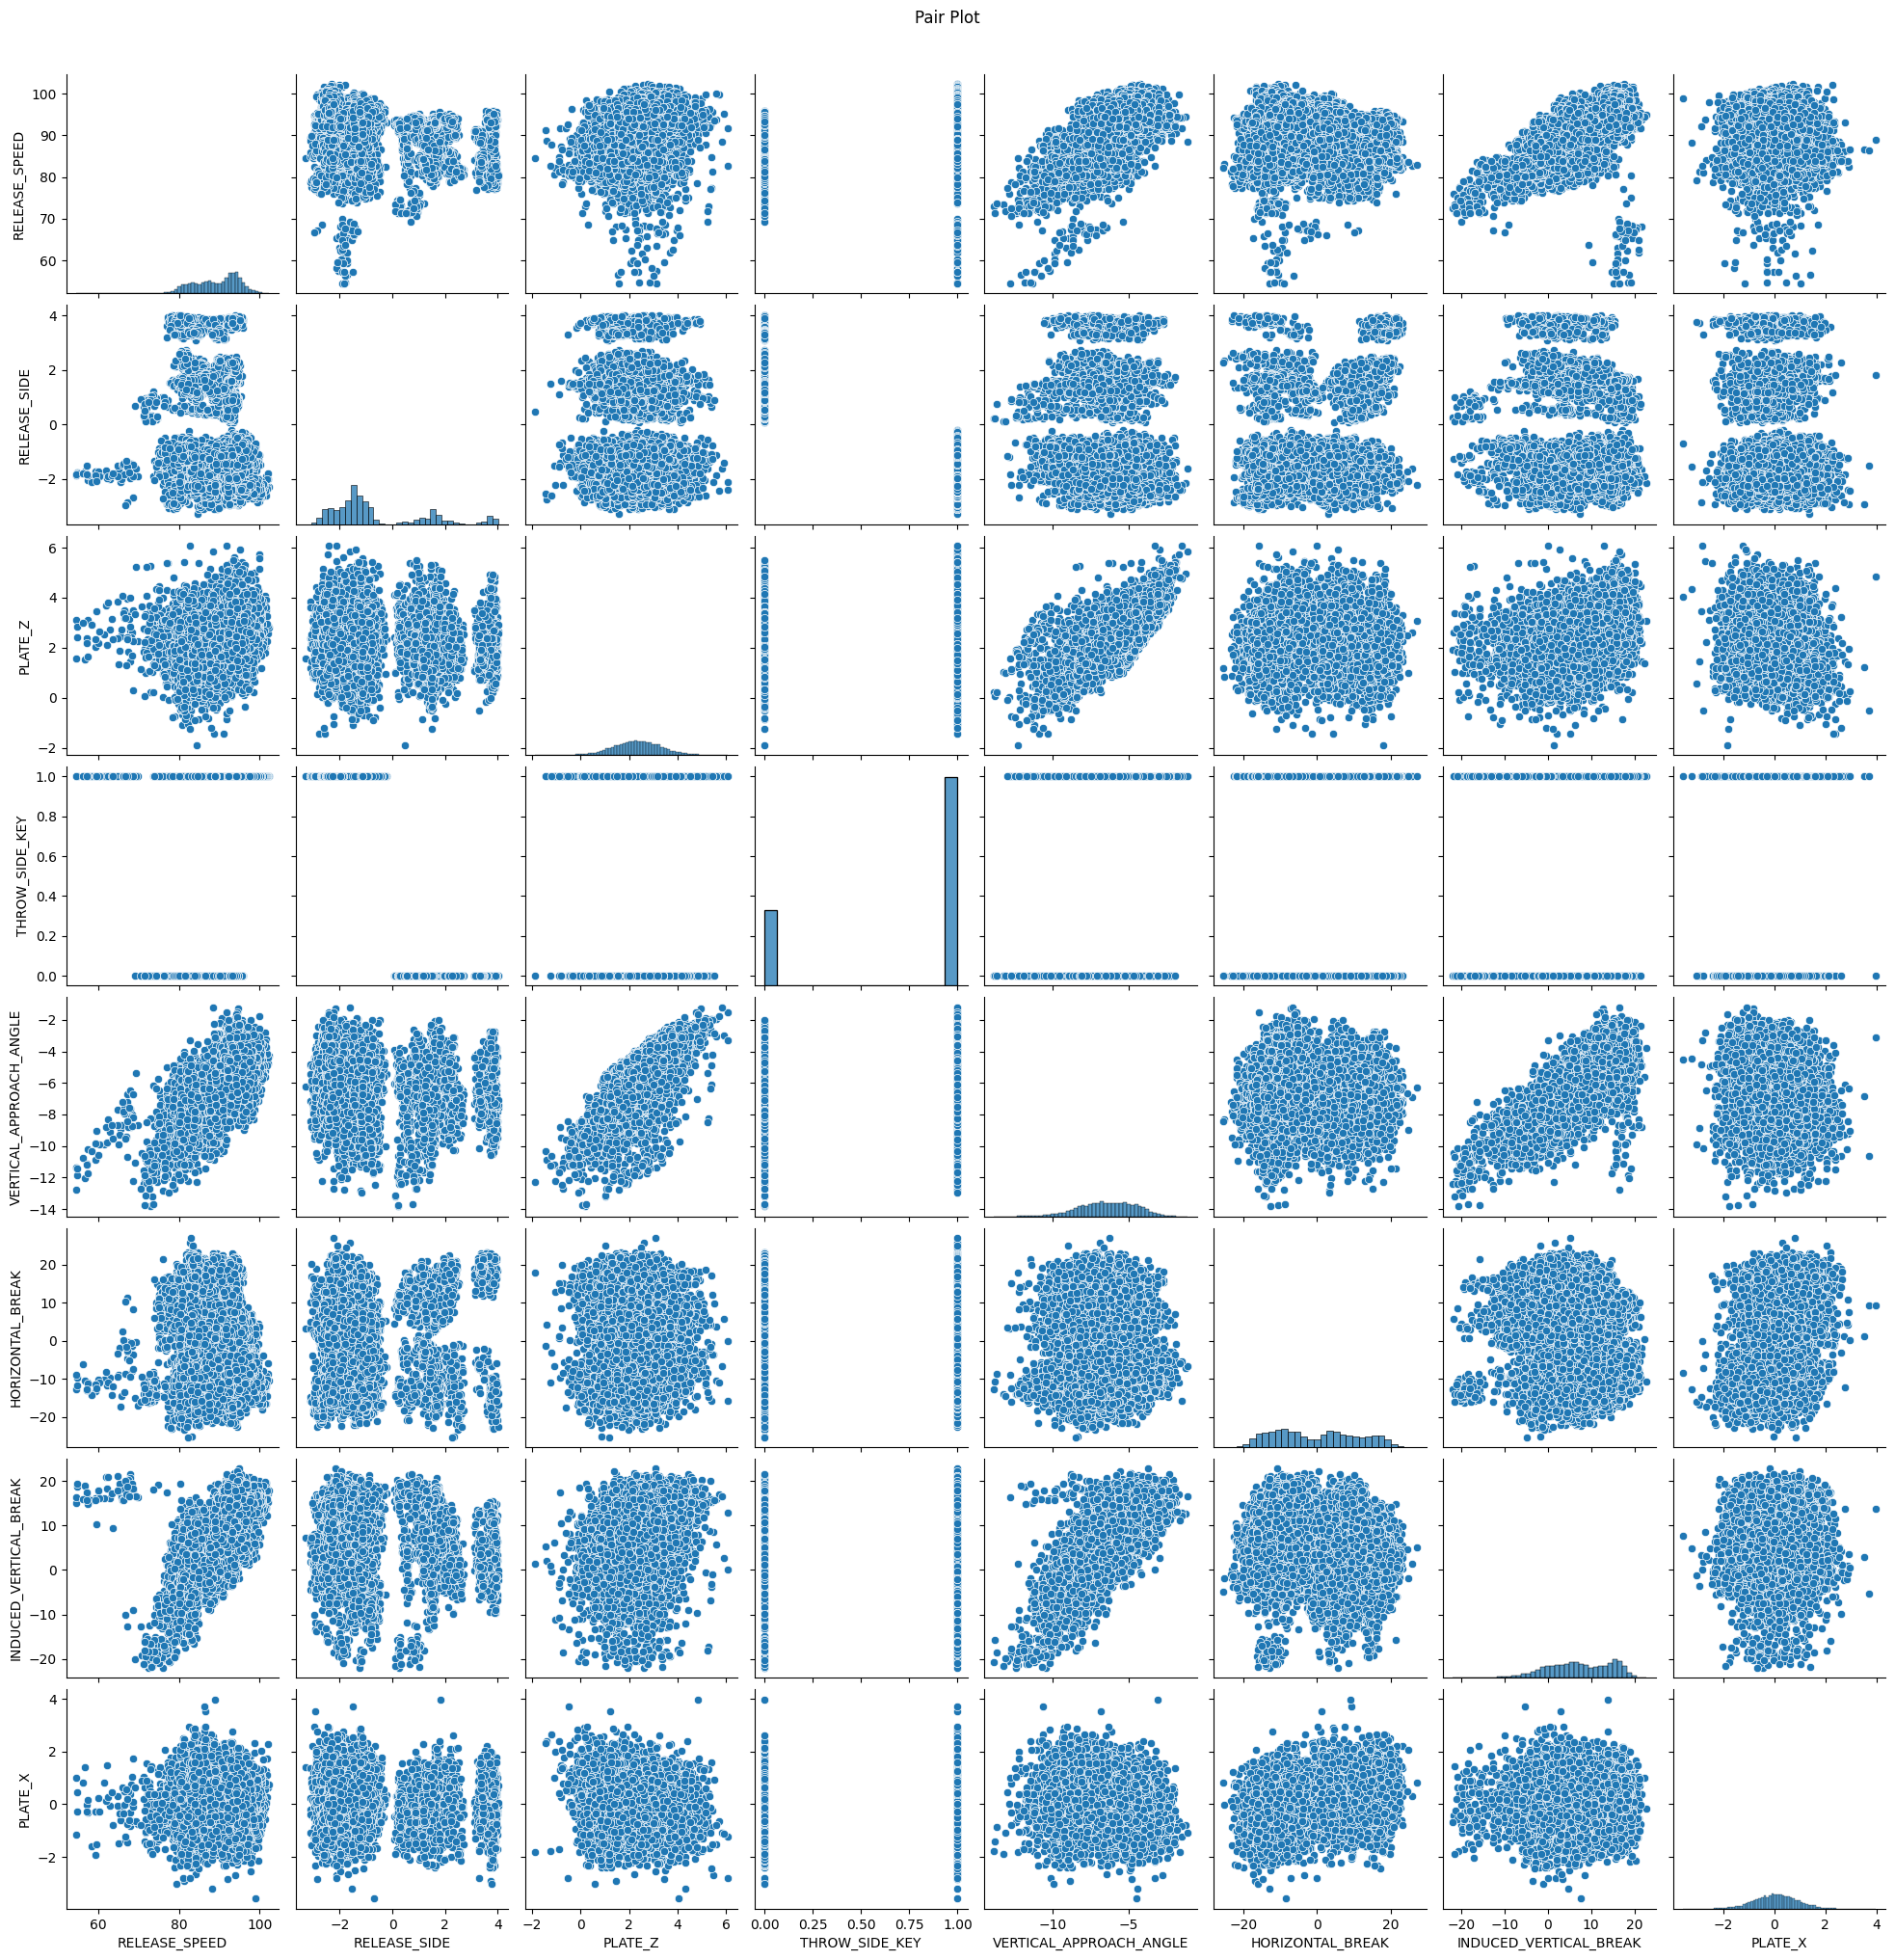

In [47]:
# to spot anomalies we plot scatterplot on all the final list of attributes that
# we are considering as part of training
sns.pairplot(data, vars=final_attributes_list)
plt.suptitle('Pair Plot', y=1.02)  # Adjust title position
plt.show()

In [51]:
# Potential outliers in every group when you are grouping the data using 'INNING_KEY' and 'PITCHER_KEY'
# Detect potential outliers using z-scores
grouped = data_with_date.groupby(['INNING_KEY', 'PITCHER_KEY'])
for group_name, df in grouped:
  df = df [final_attributes_list]
  print("Group Name",group_name)
  for column in df.columns:
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    z_outliers = z_scores > 3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = (df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)
    print(f"Column: {column}")
    print("Statistics:")
    print(df[column].describe())
    print("Z-Score Outliers:")
    print(z_outliers.value_counts())
    print("IQR Outliers:")
    print(iqr_outliers.value_counts())
    print("\n")

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Group Name (1, 570666)
Column: RELEASE_SPEED
Statistics:
count    59.000000
mean     87.051294
std       4.466387
min      80.432198
25%      82.474148
50%      87.028801
75%      91.565853
max      93.506104
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    59
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    59
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    59.000000
mean     -0.917188
std       0.137405
min      -1.213200
25%      -0.995847
50%      -0.932338
75%      -0.833850
max      -0.577032
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    59
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    58
True      1
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    59.000000
mean      1.841350
std       0.960997
min      -0.796141
25%       1.148380
50%       1.738510
75%       2.601330
max       5.113530
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    58
True      1
Name: PLATE_Z, dtype:

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    46.000000
mean     87.649370
std       4.314862
min      79.994202
25%      83.116848
50%      88.009850
75%      91.961899
max      92.773201
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    46
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    46
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    46.000000
mean     -1.928945
std       0.169841
min      -2.369370
25%      -2.036738
50%      -1.933900
75%      -1.780020
max      -1.635210
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    46
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    46
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    46.000000
mean      2.199876
std       0.849311
min       0.685790
25%       1.635818
50%       1.986780
75%       2.672587
max       4.339010
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    46
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    45
True      1
Name: PLATE_Z, dtype: int64


Column

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    87.000000
mean     -5.842617
std       1.733640
min      -8.872990
25%      -7.574425
50%      -5.143530
75%      -4.328300
max      -3.137400
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    87
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    87
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    87.000000
mean     -4.963203
std       8.205748
min     -16.599800
25%     -11.950050
50%      -8.720540
75%       4.224785
max       9.086830
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    87
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    87
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    87.000000
mean     10.567876
std       7.211793
min      -4.304720
25%       3.515365
50%      14.836900
75%      16.797501
max      20.328501
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outl

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    141.000000
mean       2.423554
std        1.146945
min       -0.492756
25%        1.684630
50%        2.410200
75%        3.235960
max        5.288730
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    141
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    141
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    141.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    141
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    141
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    141.000000
mean      -5.998366
std        2.164270
min      -12.149800
25%       -7.856080
50%       -5.503260
75%       -4.255150
max       -2.052230
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    141
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]





Column: THROW_SIDE_KEY
Statistics:
count    112.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    112
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    112
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    112.000000
mean      -6.634248
std        1.791274
min      -13.685500
25%       -7.745165
50%       -6.167790
75%       -5.433215
max       -3.242130
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    111
True       1
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    109
True       3
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    112.000000
mean       2.420672
std        9.909189
min      -22.270000
25%       -5.237630
50%        7.522460
75%        9.721905
max       18.443100
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outlier

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]





Column: PLATE_Z
Statistics:
count    19.000000
mean      2.231328
std       1.257193
min      -0.522275
25%       1.645145
50%       2.549490
75%       3.056030
max       4.714810
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    19
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    18
True      1
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    19.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    19
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    19
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    19.000000
mean     -5.848056
std       1.868914
min      -9.246490
25%      -7.409850
50%      -5.582570
75%      -4.388725
max      -2.450010
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    19
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    19
Name: V

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    27.000000
mean      7.620603
std       5.403295
min      -0.459140
25%       3.846655
50%       6.965460
75%      13.392850
max      16.206699
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    27
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    27
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    27.000000
mean     -0.003767
std       0.779607
min      -2.322660
25%      -0.441675
50%       0.000186
75%       0.591542
max       1.105500
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    27
Name: PLATE_X, dtype: int64
IQR Outliers:
False    26
True      1
Name: PLATE_X, dtype: int64


Group Name (2, 570666)
Column: RELEASE_SPEED
Statistics:
count    25.000000
mean     86.193008
std       4.514894
min      79.610397
25%      81.967697
50%      85.835999
75%      91.288101
max      93.077599
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    25
Name:

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    75.000000
mean      2.839366
std       0.894337
min       0.961458
25%       2.109250
50%       2.792080
75%       3.293975
max       5.827600
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    74
True      1
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    73
True      2
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    75.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    75
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    75
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    75.000000
mean     -5.385329
std       1.783429
min      -9.362740
25%      -6.723210
50%      -5.054420
75%      -4.175430
max      -1.185400
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    75
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    7

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



IQR Outliers:
False    129
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    129.000000
mean      -4.226261
std        7.509159
min      -19.125200
25%       -9.537640
50%       -6.449920
75%        2.661240
max       13.205400
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    129
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    129
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    129.000000
mean       8.717192
std        8.133650
min      -11.657900
25%        5.221740
50%       10.523300
75%       15.466500
max       18.282200
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    129
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    126
True       3
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    129.000000
mean       0.095782
std        0.691199
min       -1.983310
25%       -0.400100
50%        0.066010
7

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SPEED
Statistics:
count    43.000000
mean     88.434688
std       4.119541
min      80.902603
25%      84.420547
50%      90.261002
75%      91.732952
max      93.135498
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    43
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    43
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    43.000000
mean     -1.883217
std       0.168644
min      -2.350550
25%      -1.958920
50%      -1.853990
75%      -1.767220
max      -1.610840
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    43
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    41
True      2
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    43.000000
mean      2.230981
std       0.905094
min      -0.127079
25%       1.685920
50%       2.211700
75%       2.880190
max       4.042610
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    43
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    42
Tr

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Statistics:
count    231.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    231
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    231
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    231.000000
mean      -6.763510
std        1.295527
min      -10.461300
25%       -7.443490
50%       -6.600280
75%       -5.793650
max       -4.240100
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    231
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    228
True       3
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    231.000000
mean       5.428445
std        7.790883
min      -11.375200
25%        0.560113
50%        3.702990
75%       12.952850
max       20.557301
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    231
Name: HORIZONTAL_BREAK

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    13.000000
mean      0.436546
std       0.890285
min      -1.416980
25%       0.411087
50%       0.746564
75%       0.907018
max       1.350890
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    13
Name: PLATE_X, dtype: int64
IQR Outliers:
False    11
True      2
Name: PLATE_X, dtype: int64


Group Name (2, 671096)
Column: RELEASE_SPEED
Statistics:
count    122.000000
mean      88.187534
std        5.222639
min       78.421600
25%       82.701124
50%       91.399853
75%       92.656425
max       94.226501
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    122
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    122
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    122.000000
mean       1.605659
std        0.102506
min        1.322650
25%        1.544053
50%        1.600140
75%        1.691750
max        1.830980
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    122
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Statistics:
count    25.000000
mean     -2.503240
std       0.112248
min      -2.695260
25%      -2.574680
50%      -2.493880
75%      -2.426100
max      -2.254440
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    25
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    25
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    25.000000
mean      2.159805
std       1.003369
min       0.495054
25%       1.494140
50%       2.201060
75%       2.980480
max       4.137170
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    25
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    25
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    25.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    25
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    25
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statisti

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    37.000000
mean      8.834814
std      10.016110
min     -15.695200
25%       4.908050
50%      12.925500
75%      16.070999
max      19.526300
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    37
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    33
True      4
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    37.000000
mean      0.343620
std       0.722557
min      -1.112380
25%      -0.170573
50%       0.421706
75%       0.760562
max       2.226840
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    37
Name: PLATE_X, dtype: int64
IQR Outliers:
False    36
True      1
Name: PLATE_X, dtype: int64


Group Name (2, 686730)
Column: RELEASE_SPEED
Statistics:
count    35.000000
mean     89.067086
std       4.315611
min      81.063202
25%      85.228752
50%      91.159698
75%      92.832703
max      93.946098
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    35.000000
mean      1.914819
std       0.834334
min       0.091606
25%       1.453410
50%       1.829800
75%       2.405690
max       3.816960
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    35
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    35
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    35.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    35
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    35
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    35.000000
mean     -7.448376
std       1.580188
min     -10.338900
25%      -8.753040
50%      -7.551000
75%      -6.254565
max      -4.179400
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    35
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    35
Name: VERTICAL_APPROAC

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    117.000000
mean       7.421362
std        7.009651
min       -9.945830
25%        3.269520
50%        8.461800
75%       12.989800
max       17.453800
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    117
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    117
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    117.000000
mean      -0.085588
std        0.892007
min       -2.523500
25%       -0.650018
50%       -0.074601
75%        0.565138
max        2.041740
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    117
Name: PLATE_X, dtype: int64
IQR Outliers:
False    116
True       1
Name: PLATE_X, dtype: int64


Group Name (3, 596133)
Column: RELEASE_SPEED
Statistics:
count    126.000000
mean      89.095268
std        4.754593
min       79.849701
25%       85.306553
50%       87.721397
75%       93.955353
max       96.079399
Name: RELEASE_SPEED, dtype: float64
Z-Scor

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SIDE
Statistics:
count    103.000000
mean       3.784106
std        0.089051
min        3.579790
25%        3.727730
50%        3.782700
75%        3.833650
max        4.005900
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    103
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    101
True       2
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    103.000000
mean       2.232787
std        0.978709
min        0.470630
25%        1.553620
50%        2.081900
75%        2.820140
max        4.932400
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    103
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    101
True       2
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    103.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    103
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    103
N

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    6.000000
mean     2.158240
std      0.371457
min      1.660760
25%      1.942013
50%      2.137440
75%      2.367720
max      2.692450
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    6
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    6
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    6.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    6
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    6
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    6.000000
mean    -6.928613
std      1.552174
min     -9.844210
25%     -7.133797
50%     -6.458535
75%     -6.045195
max     -5.544100
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    6
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    5
True     1
Name: VERTICAL_APPROACH_ANGLE, dtype: int

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_X
Statistics:
count    16.000000
mean     -0.119328
std       0.659056
min      -1.307020
25%      -0.504425
50%       0.074158
75%       0.465357
max       0.656766
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    16
Name: PLATE_X, dtype: int64
IQR Outliers:
False    16
Name: PLATE_X, dtype: int64


Group Name (3, 686651)
Column: RELEASE_SPEED
Statistics:
count    55.000000
mean     87.606789
std       6.062499
min      75.632698
25%      82.700302
50%      85.481697
75%      93.800049
max      95.295403
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    55
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    55
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    55.000000
mean     -1.214381
std       0.517014
min      -2.249210
25%      -1.784435
50%      -1.008120
75%      -0.824550
max      -0.576403
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    55
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False   

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    62.000000
mean     -7.164614
std       1.961620
min     -11.186200
25%      -9.019725
50%      -6.725560
75%      -5.960992
max      -3.545410
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    62
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    62
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    62.000000
mean     -3.967797
std       5.607884
min     -12.651700
25%      -8.313965
50%      -5.632350
75%       2.463197
max       7.105430
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    62
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    62
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    62.000000
mean      9.326988
std       7.322584
min      -6.549810
25%       5.234623
50%       9.749710
75%      15.253900
max      21.134501
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outl

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count     2.000000
mean     82.404099
std       8.477502
min      76.409599
25%      79.406849
50%      82.404099
75%      85.401348
max      88.398598
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    2
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    2
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    2.000000
mean    -1.025509
std      0.467583
min     -1.356140
25%     -1.190825
50%     -1.025509
75%     -0.860193
max     -0.694878
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    2
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    2
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    2.000000
mean     2.078955
std      0.833149
min      1.489830
25%      1.784393
50%      2.078955
75%      2.373518
max      2.668080
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    2
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    2
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    119.000000
mean      -5.060914
std        7.669240
min      -21.107901
25%      -10.627650
50%       -6.499610
75%        1.670095
max       14.819500
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    119
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    119
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    119.000000
mean       8.716422
std        8.367766
min      -12.049200
25%        4.984855
50%       10.937100
75%       15.298250
max       21.285900
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    119
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    116
True       3
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    119.000000
mean       0.048160
std        0.711930
min       -1.852500
25%       -0.498710
50%       -0.014585
75%        0.547643
max        1.667040
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    119
Name: PLATE

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    22.000000
mean      2.192245
std       0.812725
min       0.562107
25%       1.524873
50%       2.464250
75%       2.726395
max       3.572220
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    22
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    22
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    22.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    22
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    22
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    22.000000
mean     -6.146311
std       1.571213
min      -8.989970
25%      -7.094040
50%      -5.398280
75%      -5.300130
max      -3.599750
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    22
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    22
Name: VERTICAL_APPROAC

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



False    92
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    92
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    92.000000
mean     -6.082903
std       1.784461
min     -10.856500
25%      -7.511110
50%      -5.964710
75%      -4.681547
max      -2.443870
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    92
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    92
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    92.000000
mean     -6.178858
std       8.217231
min     -18.136400
25%     -12.856250
50%     -10.105750
75%       1.739990
max      11.362600
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    92
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    92
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    92.000000
mean      9.328797
std       6.570604
min      -2.842620
25%       2.641927
50%

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]





Column: THROW_SIDE_KEY
Statistics:
count    132.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    132
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    132
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    132.000000
mean      -6.350165
std        1.943269
min      -11.255800
25%       -7.484958
50%       -6.144815
75%       -4.777817
max       -3.022300
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    132
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    132
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    132.000000
mean       2.950014
std       10.343759
min      -18.619301
25%       -8.297250
50%        6.829655
75%       10.111525
max       17.781799
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    132
Name: HORI

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]





Column: PLATE_Z
Statistics:
count    130.000000
mean       2.393760
std        1.050926
min       -0.880086
25%        1.836803
50%        2.298340
75%        3.075207
max        5.345730
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    129
True       1
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    127
True       3
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    130.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    130
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    130
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    130.000000
mean      -7.197928
std        2.072160
min      -13.785500
25%       -8.331390
50%       -6.862780
75%       -5.934605
max       -2.646250
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    129
True       1
Name: VERTICAL_APPROA

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    12.000000
mean      2.840473
std       0.780131
min       1.203310
25%       2.358353
50%       3.116670
75%       3.355833
max       4.041440
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    12
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    12
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    12.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    12
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    12
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    12.000000
mean     -6.585675
std       1.849071
min     -10.087100
25%      -8.139047
50%      -5.870260
75%      -5.273415
max      -4.057530
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    12
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    12
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Colu

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



False    12
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    12
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    12.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    12
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    12
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    12.000000
mean     -5.833148
std       1.138815
min      -8.410660
25%      -6.118665
50%      -5.686580
75%      -5.352563
max      -3.680950
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    12
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    10
True      2
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    12.000000
mean     -6.041406
std      11.065982
min     -17.426800
25%     -14.646875
50%      -9.588560
75%      -2.169505
max      15.561300
Na

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    7.000000
mean    -7.663201
std      1.509494
min     -9.978320
25%     -8.425920
50%     -7.648670
75%     -6.882315
max     -5.398950
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    7
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    7
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count     7.000000
mean      1.561947
std       6.875464
min     -11.633400
25%      -0.585075
50%       2.849550
75%       6.555825
max       7.775980
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    7
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    6
True     1
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count     7.000000
mean      3.786933
std       9.024177
min      -7.561360
25%      -3.924185
50%       7.319520
75%       8.700970
max      17.196800
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outli

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]





Column: INDUCED_VERTICAL_BREAK
Statistics:
count    12.000000
mean      4.775987
std       6.520717
min      -1.216370
25%       0.265453
50%       2.290940
75%       6.334972
max      15.968200
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    12
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    11
True      1
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    12.000000
mean     -0.297690
std       0.728795
min      -2.001370
25%      -0.701294
50%      -0.280337
75%       0.208765
max       0.797603
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    12
Name: PLATE_X, dtype: int64
IQR Outliers:
False    12
Name: PLATE_X, dtype: int64


Group Name (5, 594580)
Column: RELEASE_SPEED
Statistics:
count     6.000000
mean     86.737703
std       6.632262
min      80.402802
25%      80.768953
50%      86.519302
75%      92.703903
max      93.367203
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    6
Nam

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Z-Score Outliers:
False    25
Name: PLATE_X, dtype: int64
IQR Outliers:
False    25
Name: PLATE_X, dtype: int64


Group Name (5, 622065)
Column: RELEASE_SPEED
Statistics:
count    73.000000
mean     85.769307
std       3.927398
min      80.241302
25%      81.825104
50%      85.333099
75%      89.931198
max      92.528900
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    73
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    73
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    73.000000
mean      2.092316
std       0.268369
min       1.626950
25%       1.918900
50%       2.066390
75%       2.288850
max       2.720850
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    73
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    73
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    73.000000
mean      1.980824
std       0.766428
min      -0.103249
25%       1.395380
50%       1.993320
75%       2.537860
max      

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]




Column: PLATE_X
Statistics:
count    12.000000
mean     -0.115698
std       0.688865
min      -1.206310
25%      -0.493841
50%      -0.201555
75%       0.164389
max       1.575230
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    12
Name: PLATE_X, dtype: int64
IQR Outliers:
False    11
True      1
Name: PLATE_X, dtype: int64


Group Name (5, 650960)
Column: RELEASE_SPEED
Statistics:
count    10.000000
mean     92.602639
std       3.820842
min      83.583397
25%      91.344877
50%      93.959549
75%      95.148098
max      96.370499
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    10
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    9
True     1
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    10.000000
mean     -0.679100
std       0.166855
min      -0.891860
25%      -0.774682
50%      -0.711857
75%      -0.573441
max      -0.416399
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    10
Name: RELEASE_SIDE, dtype: int6

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Column: PLATE_X
Statistics:
count    8.000000
mean     0.803307
std      0.821487
min      0.049122
25%      0.280816
50%      0.458329
75%      1.072531
max      2.220940
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    8
Name: PLATE_X, dtype: int64
IQR Outliers:
False    8
Name: PLATE_X, dtype: int64


Group Name (5, 664139)
Column: RELEASE_SPEED
Statistics:
count     7.000000
mean     89.949729
std       5.037018
min      82.582497
25%      86.871502
50%      92.394402
75%      93.316799
max      94.294601
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    7
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    7
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    7.000000
mean    -1.503663
std      0.137487
min     -1.692530
25%     -1.588575
50%     -1.507250
75%     -1.413155
max     -1.322400
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    7
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    7
Name: RELEASE_SID

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    27.000000
mean      0.884539
std       4.531211
min      -5.661330
25%      -2.932290
50%       0.415670
75%       4.647705
max      10.269200
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    27
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    27
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    27.000000
mean      0.458660
std       0.755773
min      -1.312510
25%       0.170484
50%       0.581366
75%       0.883448
max       1.842660
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    27
Name: PLATE_X, dtype: int64
IQR Outliers:
False    25
True      2
Name: PLATE_X, dtype: int64


Group Name (5, 666157)
Column: RELEASE_SPEED
Statistics:
count    57.000000
mean     86.635842
std       6.267552
min      77.261101
25%      79.962799
50%      87.454803
75%      92.780403
max      94.944397
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    57
Name:

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: THROW_SIDE_KEY
Statistics:
count    156.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    156
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    156
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    156.000000
mean      -7.046012
std        1.386559
min      -11.403600
25%       -7.806372
50%       -6.957050
75%       -6.194083
max       -2.791250
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    154
True       2
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    154
True       2
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    156.000000
mean       6.094449
std        6.930498
min       -7.138220
25%        1.587180
50%        5.369640
75%       11.042275
max       20.696899
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    93.000000
mean      2.060593
std      11.507833
min     -20.888700
25%      -4.986160
50%       6.564200
75%      11.073500
max      19.304399
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    93
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    93
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    93.000000
mean      7.143241
std       9.418227
min     -20.439600
25%       2.303280
50%       7.558800
75%      15.825400
max      19.797899
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    93
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    91
True      2
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    93.000000
mean     -0.323719
std       0.736926
min      -2.034170
25%      -0.795748
50%      -0.300626
75%       0.171093
max       2.298150
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    92
True      1
Name: PLATE_X, dtype: int64
I

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    108.000000
mean      -1.475453
std        0.213709
min       -2.069630
25%       -1.597743
50%       -1.489775
75%       -1.323202
max       -1.010160
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    108
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    107
True       1
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    108.000000
mean       2.414026
std        0.938421
min        0.408992
25%        1.674570
50%        2.479495
75%        3.033862
max        4.546880
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    108
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    108
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    108.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    108
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    108
Name: THROW_SIDE_KEY, dtype: int64


Column: VE

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    77.000000
mean      6.028660
std       7.189841
min      -5.497080
25%      -0.019210
50%       3.040400
75%      13.335100
max      17.433500
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    77
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    77
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    77.000000
mean      0.399995
std       0.818140
min      -1.869400
25%      -0.074047
50%       0.409835
75%       0.772681
max       2.843950
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    77
Name: PLATE_X, dtype: int64
IQR Outliers:
False    74
True      3
Name: PLATE_X, dtype: int64


Group Name (6, 571882)
Column: RELEASE_SPEED
Statistics:
count    57.000000
mean     88.307672
std       6.492399
min      74.854500
25%      84.189903
50%      90.648102
75%      92.838097
max      97.225601
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    57
Name:

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    30.000000
mean     83.969963
std       3.446849
min      79.633797
25%      81.560749
50%      83.397297
75%      84.353748
max      91.404999
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    30
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    25
True      5
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    30.000000
mean      1.326741
std       0.131064
min       1.132270
25%       1.214850
50%       1.292440
75%       1.429897
max       1.585750
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    30
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    30
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    30.000000
mean      1.773603
std       0.967337
min       0.321293
25%       0.976697
50%       1.622445
75%       2.489595
max       3.418260
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    30
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    30
Name: PLATE_Z, dtype: int64


Column

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: HORIZONTAL_BREAK
Statistics:
count    36.000000
mean     -4.110338
std      12.367224
min     -22.167400
25%     -14.792625
50%      -5.438850
75%       9.211313
max      16.112301
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    36
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    36
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    36.000000
mean      6.666585
std       7.214801
min     -10.957300
25%       2.663270
50%       6.881940
75%      12.914875
max      17.477501
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    36
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    36
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    36.000000
mean      0.025758
std       0.841874
min      -1.816170
25%      -0.576518
50%       0.231424
75%       0.712455
max       1.544050
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    36
Name: PLATE_X, d

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Statistics:
count    11.000000
mean     -1.667846
std       0.140783
min      -1.821660
25%      -1.788830
50%      -1.681360
75%      -1.558420
max      -1.449740
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    11
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    11
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    11.000000
mean      2.569655
std       1.110763
min       0.623250
25%       1.938760
50%       2.425040
75%       3.220065
max       4.512220
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    11
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    11
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    11.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    11
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    11
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistic

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    21.000000
mean      2.043704
std       0.873168
min       0.828806
25%       1.574060
50%       1.879670
75%       2.373310
max       4.210670
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    21
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    19
True      2
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    21.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    21
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    21
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    21.000000
mean     -6.810092
std       1.474103
min      -8.639250
25%      -7.982640
50%      -7.089310
75%      -6.102180
max      -3.359840
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    21
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    21
Name: VERT

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    109.000000
mean       3.140324
std        4.397997
min       -9.091850
25%       -0.523270
50%        4.063290
75%        6.453830
max       12.224100
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    109
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    109
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    109.000000
mean       0.162366
std        0.832795
min       -1.948180
25%       -0.462521
50%        0.174905
75%        0.707089
max        2.116410
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    109
Name: PLATE_X, dtype: int64
IQR Outliers:
False    109
Name: PLATE_X, dtype: int64


Group Name (6, 668984)
Column: RELEASE_SPEED
Statistics:
count    16.000000
mean     92.021900
std       4.967178
min      84.702499
25%      86.566023
50%      95.396950
75%      96.283377
max      96.704002
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    32.000000
mean     -6.511848
std       1.256174
min      -8.675930
25%      -7.349295
50%      -6.571480
75%      -5.899847
max      -3.558170
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    32
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    31
True      1
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    32.000000
mean    -11.620604
std       8.799936
min     -21.271700
25%     -17.461800
50%     -15.055950
75%      -0.843525
max       7.673680
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    32
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    32
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    32.000000
mean      3.052184
std       4.136240
min      -4.418720
25%       0.427770
50%       2.878240
75%       5.276875
max      12.233900
Name: INDUCED_VERTICAL_BREAK, dtype: float64


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SPEED
Statistics:
count    94.000000
mean     86.778572
std       5.457425
min      79.736603
25%      81.619972
50%      86.907051
75%      93.112598
max      95.858902
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    94
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    94
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    94.000000
mean     -1.438549
std       0.209749
min      -1.984740
25%      -1.573128
50%      -1.426375
75%      -1.285775
max      -0.995506
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    94
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    94
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    94.000000
mean      2.146303
std       1.100383
min      -0.722644
25%       1.536417
50%       2.191875
75%       2.753047
max       4.638690
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    94
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    90
True      4
Na

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    75.000000
mean     -7.108103
std       1.665578
min     -11.223900
25%      -8.137920
50%      -7.072180
75%      -5.919540
max      -3.934640
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    75
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    75
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    75.000000
mean     -1.390726
std       6.454683
min     -16.757799
25%      -3.825170
50%       1.219540
75%       2.887590
max       6.491550
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    75
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    68
True      7
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    75.000000
mean      6.449828
std       7.352762
min      -9.835430
25%       2.311785
50%       8.183670
75%      11.075100
max      17.824699
Name: INDUCED_VERTICAL_BREAK, dtype: float64


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SPEED
Statistics:
count    11.000000
mean     84.846236
std       6.940785
min      75.322197
25%      78.245350
50%      88.453400
75%      90.726547
max      92.579597
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    11
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    11
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    11.000000
mean     -1.500841
std       0.152451
min      -1.778920
25%      -1.577215
50%      -1.503700
75%      -1.363145
max      -1.330780
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    11
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    11
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    11.000000
mean      2.125082
std       0.900317
min       1.035620
25%       1.364300
50%       1.840400
75%       2.893195
max       3.628030
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    11
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    11
Name: PLATE_Z,

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    48.000000
mean     -7.407252
std       1.257083
min      -9.973650
25%      -8.246537
50%      -7.380760
75%      -6.625840
max      -3.390820
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    47
True      1
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    47
True      1
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    48.000000
mean      8.981765
std      11.284835
min     -14.356600
25%       8.144488
50%      13.542600
75%      16.697200
max      19.577900
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    48
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    37
True     11
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    48.000000
mean      2.565417
std       4.118946
min      -4.878090
25%      -0.301985
50%       2.308065
75%       5.934365
max      12.048200
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
Fa

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SPEED
Statistics:
count    135.000000
mean      91.136470
std        4.453178
min       81.497200
25%       86.854752
50%       92.261597
75%       95.148697
max       97.057503
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    135
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    135
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    135.000000
mean      -1.355578
std        0.227010
min       -2.077360
25%       -1.501450
50%       -1.353810
75%       -1.196800
max       -0.837219
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    134
True       1
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    134
True       1
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    135.000000
mean       2.434026
std        0.829255
min       -0.475334
25%        1.890490
50%        2.496060
75%        3.041770
max        4.181600
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    133
True       2


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    24.000000
mean     -3.370095
std       8.800800
min     -16.572500
25%     -12.111700
50%      -0.039450
75%       5.037232
max       7.757310
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    24
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    24
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    24.000000
mean      8.185134
std       6.450382
min       0.417690
25%       2.660320
50%       4.506260
75%      15.029600
max      18.087500
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    24
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    24
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    24.000000
mean      0.219720
std       0.795760
min      -1.249820
25%      -0.263025
50%      -0.022128
75%       0.568333
max       2.328560
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    24
Name: PLATE_X, dtype: int64
IQR Outliers:
False    23

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: PLATE_Z
Statistics:
count    13.000000
mean      2.658246
std       0.760745
min       1.563970
25%       2.074040
50%       2.709950
75%       2.978070
max       3.893240
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    13
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    13
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    13.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    13
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    13
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    13.000000
mean     -6.204076
std       0.957004
min      -7.749060
25%      -7.186870
50%      -5.997990
75%      -5.369840
max      -4.986390
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    13
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    13
Name: VERTICAL_APPROAC

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    33.000000
mean     -0.054738
std       1.016344
min      -2.081120
25%      -0.779962
50%       0.126401
75%       0.419371
max       1.829190
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    33
Name: PLATE_X, dtype: int64
IQR Outliers:
False    33
Name: PLATE_X, dtype: int64


Group Name (7, 682227)
Column: RELEASE_SPEED
Statistics:
count    19.000000
mean     84.540868
std       6.885216
min      71.531898
25%      82.179298
50%      84.318100
75%      90.034000
max      94.133003
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    19
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    19
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    19.000000
mean      0.817869
std       0.378457
min       0.175357
25%       0.520045
50%       1.020960
75%       1.083340
max       1.307080
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    19
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    19
Name: RELEASE_SIDE, dtyp

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    17.000000
mean     -7.797537
std       1.783754
min     -11.521400
25%      -8.802270
50%      -8.133160
75%      -6.328470
max      -5.297750
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    17
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    17
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    17.000000
mean     -4.824066
std      12.449022
min     -17.070200
25%     -14.837800
50%     -10.878300
75%       9.731350
max      15.254200
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    17
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    17
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    17.000000
mean      1.118540
std       7.461013
min     -10.917600
25%      -6.218590
50%       1.736930
75%       7.193400
max      14.083800
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    17
Name: INDUCED_VERTICAL_BRE

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Column: RELEASE_SIDE
Statistics:
count    9.000000
mean     2.329190
std      0.192613
min      2.023720
25%      2.138020
50%      2.378220
75%      2.439140
max      2.589540
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    9
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    9
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    9.000000
mean     2.418012
std      0.513267
min      1.673580
25%      2.237690
50%      2.310120
75%      2.621300
max      3.183210
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    9
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    9
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    9.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    9
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    9
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: THROW_SIDE_KEY
Statistics:
count    13.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    13
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    13
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    13.000000
mean     -6.415282
std       2.364816
min     -10.212800
25%      -8.357780
50%      -5.497720
75%      -5.146330
max      -2.203340
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    13
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    13
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    13.000000
mean     -4.390103
std       7.380420
min     -18.730700
25%     -10.524900
50%      -0.778736
75%       0.391493
max       6.403560
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    13
Name: HORIZONTAL_BREAK, dtype: int64
IQR O

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: RELEASE_SPEED
Statistics:
count    21.000000
mean     92.327076
std       3.477625
min      83.578796
25%      92.190201
50%      93.594101
75%      94.384499
max      95.408699
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    21
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    18
True      3
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    21.000000
mean     -1.729015
std       0.103002
min      -1.873300
25%      -1.796390
50%      -1.766650
75%      -1.676680
max      -1.464320
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    21
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    20
True      1
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    21.000000
mean      2.663231
std       0.804637
min       1.057000
25%       2.040020
50%       2.778140
75%       3.021130
max       4.261010
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    21
Name: PLATE_Z, dtype: int64
IQR Outliers:
Fa

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    59.000000
mean      5.988082
std       5.601575
min      -2.031990
25%       0.558985
50%       4.405240
75%      11.092900
max      14.816900
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    59
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    59
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    59.000000
mean      0.213962
std       0.854643
min      -1.640620
25%      -0.373027
50%       0.259307
75%       0.583517
max       2.562010
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    59
Name: PLATE_X, dtype: int64
IQR Outliers:
False    57
True      2
Name: PLATE_X, dtype: int64


Group Name (8, 665665)
Column: RELEASE_SPEED
Statistics:
count    33.000000
mean     86.515242
std       4.357793
min      76.939697
25%      84.424004
50%      88.348198
75%      90.165001
max      91.486397
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    33
Name:

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



False    56
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    54
True      2
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    56.000000
mean     -2.571891
std       0.202586
min      -2.976060
25%      -2.686880
50%      -2.599805
75%      -2.502223
max      -2.139200
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    56
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    50
True      6
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    56.000000
mean      2.817144
std       0.847657
min       1.036620
25%       2.297823
50%       2.833990
75%       3.346827
max       4.891120
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    56
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    56
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    56.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outlier

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    19.000000
mean     -6.938557
std       1.729354
min      -9.747660
25%      -8.492180
50%      -6.933270
75%      -5.416880
max      -4.547990
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    19
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    19
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    19.000000
mean     -0.757113
std      10.208346
min     -15.650600
25%     -10.096635
50%       4.145710
75%       7.266820
max      14.222400
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    19
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    19
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    19.000000
mean      8.984333
std       6.853470
min      -6.032910
25%       3.612820
50%      10.468000
75%      14.946550
max      16.319700
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outl

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



False    29
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    29.000000
mean     -7.843627
std       1.308884
min      -9.877830
25%      -8.786780
50%      -7.820540
75%      -7.182960
max      -5.007950
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    29
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    29
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    29.000000
mean     -4.350918
std       4.144220
min     -12.614600
25%      -8.054310
50%      -3.348060
75%      -1.360650
max       2.521690
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    29
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    29
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    29.000000
mean     17.711182
std       2.729146
min       9.335970
25%      16.604700
50%      18.024799
75%      19.443100
max      21.575600
Name: I

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


(9, 611093)
Column: RELEASE_SPEED
Statistics:
count    45.000000
mean     85.865587
std       5.795919
min      78.147102
25%      80.263100
50%      82.552696
75%      91.741898
max      93.877602
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    45
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    45
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    45.000000
mean     -1.533272
std       0.130347
min      -1.866270
25%      -1.609180
50%      -1.530860
75%      -1.446550
max      -1.334610
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    45
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    44
True      1
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    45.000000
mean      2.718072
std       1.169460
min       0.053095
25%       1.871130
50%       2.878310
75%       3.421570
max       4.857270
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    45
Name: PLATE_Z, dtype: int64
IQR Outliers:
Fa

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


False    29
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    29.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    29
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    29
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    29.000000
mean     -7.098544
std       1.260388
min      -9.607330
25%      -8.069590
50%      -6.979860
75%      -6.242820
max      -4.721750
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    29
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    29
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    29.000000
mean     10.077122
std      10.278964
min     -16.381001
25%       9.500140
50%      14.206900
75%      16.212000
max      18.747200
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    29


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    78.000000
mean      0.043111
std       0.806623
min      -1.567180
25%      -0.563124
50%       0.022416
75%       0.728539
max       1.841590
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    78
Name: PLATE_X, dtype: int64
IQR Outliers:
False    78
Name: PLATE_X, dtype: int64


Group Name (9, 650960)
Column: RELEASE_SPEED
Statistics:
count    61.000000
mean     91.337265
std       4.360776
min      81.578796
25%      89.559097
50%      92.781601
75%      94.385803
max      96.677696
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    61
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    58
True      3
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    61.000000
mean     -1.099431
std       0.281596
min      -1.555430
25%      -1.286130
50%      -1.202350
75%      -0.998170
max      -0.282917
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    61
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    58
True      3


<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    60.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    60
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    60
Name: THROW_SIDE_KEY, dtype: int64


Column: VERTICAL_APPROACH_ANGLE
Statistics:
count    60.000000
mean     -5.729280
std       1.517362
min      -8.501060
25%      -6.958522
50%      -5.826460
75%      -4.422010
max      -2.519970
Name: VERTICAL_APPROACH_ANGLE, dtype: float64
Z-Score Outliers:
False    60
Name: VERTICAL_APPROACH_ANGLE, dtype: int64
IQR Outliers:
False    60
Name: VERTICAL_APPROACH_ANGLE, dtype: int64


Column: HORIZONTAL_BREAK
Statistics:
count    60.000000
mean     -0.980928
std      10.362999
min     -16.909100
25%      -7.119210
50%      -4.313785
75%       5.631415
max      19.311399
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    60
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    60
Name: HORIZONT

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]



Column: RELEASE_SIDE
Statistics:
count    53.000000
mean     -2.669306
std       0.172825
min      -2.912730
25%      -2.793500
50%      -2.706210
75%      -2.517310
max      -2.262700
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    53
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    53
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    53.000000
mean      2.372595
std       1.146051
min      -1.208970
25%       1.694630
50%       2.399920
75%       3.096930
max       6.057000
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    51
True      2
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    51
True      2
Name: PLATE_Z, dtype: int64


Column: THROW_SIDE_KEY
Statistics:
count    53.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: THROW_SIDE_KEY, dtype: float64
Z-Score Outliers:
False    53
Name: THROW_SIDE_KEY, dtype: int64
IQR Outliers:
False    53
Name: THROW_SIDE_KEY, dtype: int

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


count    49.000000
mean     92.515814
std       3.760448
min      85.236099
25%      90.639900
50%      94.206398
75%      95.428902
max      98.700203
Name: RELEASE_SPEED, dtype: float64
Z-Score Outliers:
False    49
Name: RELEASE_SPEED, dtype: int64
IQR Outliers:
False    49
Name: RELEASE_SPEED, dtype: int64


Column: RELEASE_SIDE
Statistics:
count    49.000000
mean     -1.293624
std       0.242993
min      -1.612670
25%      -1.470960
50%      -1.332350
75%      -1.169720
max      -0.489207
Name: RELEASE_SIDE, dtype: float64
Z-Score Outliers:
False    48
True      1
Name: RELEASE_SIDE, dtype: int64
IQR Outliers:
False    46
True      3
Name: RELEASE_SIDE, dtype: int64


Column: PLATE_Z
Statistics:
count    49.000000
mean      2.843435
std       0.921843
min       0.170536
25%       2.378800
50%       2.831130
75%       3.247970
max       4.950390
Name: PLATE_Z, dtype: float64
Z-Score Outliers:
False    49
Name: PLATE_Z, dtype: int64
IQR Outliers:
False    44
True      5
Name: PLATE_

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]
<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


Column: HORIZONTAL_BREAK
Statistics:
count    18.000000
mean      1.834887
std       6.019934
min      -9.631860
25%      -1.882170
50%       2.955815
75%       7.105633
max       9.610370
Name: HORIZONTAL_BREAK, dtype: float64
Z-Score Outliers:
False    18
Name: HORIZONTAL_BREAK, dtype: int64
IQR Outliers:
False    18
Name: HORIZONTAL_BREAK, dtype: int64


Column: INDUCED_VERTICAL_BREAK
Statistics:
count    18.000000
mean      6.287678
std       6.538717
min      -3.852090
25%       3.203180
50%       5.313665
75%       7.621773
max      18.127600
Name: INDUCED_VERTICAL_BREAK, dtype: float64
Z-Score Outliers:
False    18
Name: INDUCED_VERTICAL_BREAK, dtype: int64
IQR Outliers:
False    13
True      5
Name: INDUCED_VERTICAL_BREAK, dtype: int64


Column: PLATE_X
Statistics:
count    18.000000
mean      0.370303
std       0.915262
min      -1.934540
25%       0.048377
50%       0.386713
75%       0.895431
max       2.390090
Name: PLATE_X, dtype: float64
Z-Score Outliers:
False    18
Name

<ipython-input-51-78d0f7c62130>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df [final_attributes_list]


In [53]:
# appended an extra column to my data which says whether or not a data point/pitch is an anomaly inside a group
# grouped the data using both 'INNING_KEY', 'PITCHER_KEY'
# using k means clustering
data = data[['PID','INNING_KEY','PITCHER_KEY','VERTICAL_APPROACH_ANGLE',
             'INDUCED_VERTICAL_BREAK', 'RELEASE_SPEED',
             'RELEASE_SIDE', 'PLATE_X', 'THROW_SIDE_KEY', 'PLATE_Z', 'HORIZONTAL_BREAK']]
# im grouping here using inning_key and pitcher_key, assuming the player/pitcher behavior to be consistent across an inning
grouped = data.groupby(['INNING_KEY', 'PITCHER_KEY'])
# now im gonna find anomalies inside every group using k-means clustering.
# im setting the k-value to be equal to sqrt(n) where n is no of the samples in a group.
def find_anomalies(name, group):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group)
    n_clusters = math.ceil(math.sqrt(len(group)))
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    group['cluster'] = kmeans.fit_predict(scaled_data)
    distances = kmeans.transform(scaled_data)
    min_distances = np.min(distances, axis=1)
    threshold = np.mean(min_distances)
    group['is_anomaly'] = min_distances > threshold
    # Scatter plot with colored clusters
    labels = kmeans.labels_
    plt.figure(figsize=(8, 6))
    plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=labels, cmap='viridis')
    plt.title(f'K-Means Clusters for Group {name}')
    plt.show()
    return group


In [54]:
# Using Autoencoder model to do anomaly detection.
# the bigger reconstruction error, the bigger will be the probability of it being an anomaly.
# error is directly proportional to probability of it being affected by dew point greater than 65
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


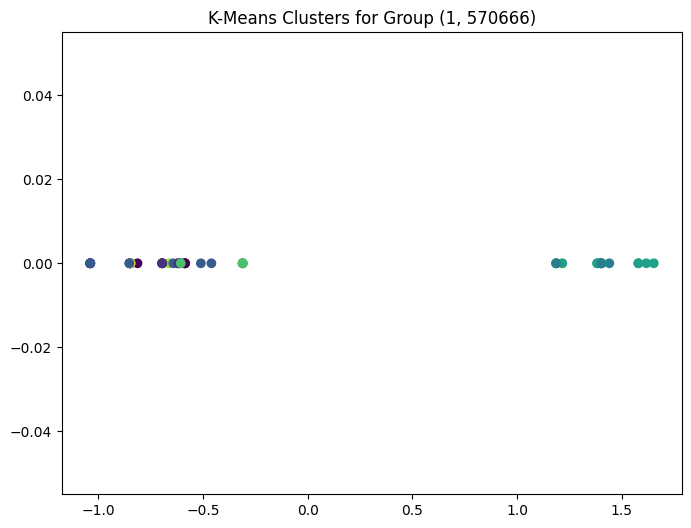

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


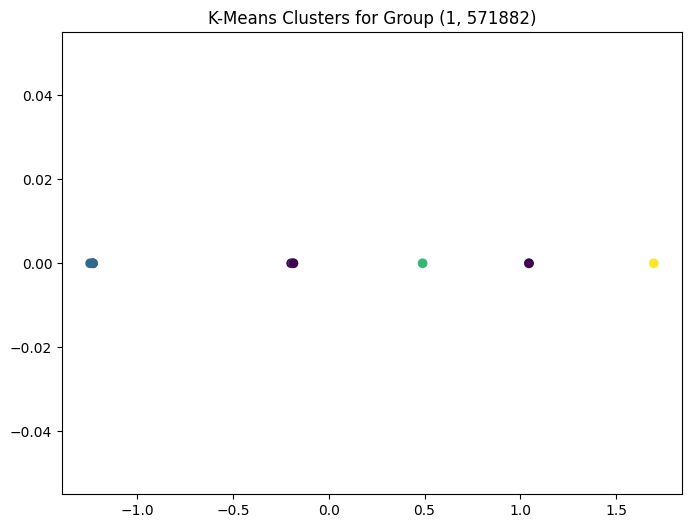

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


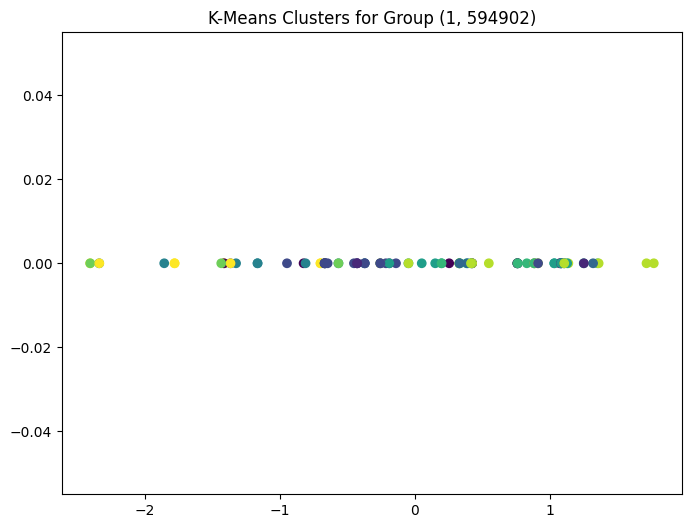

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


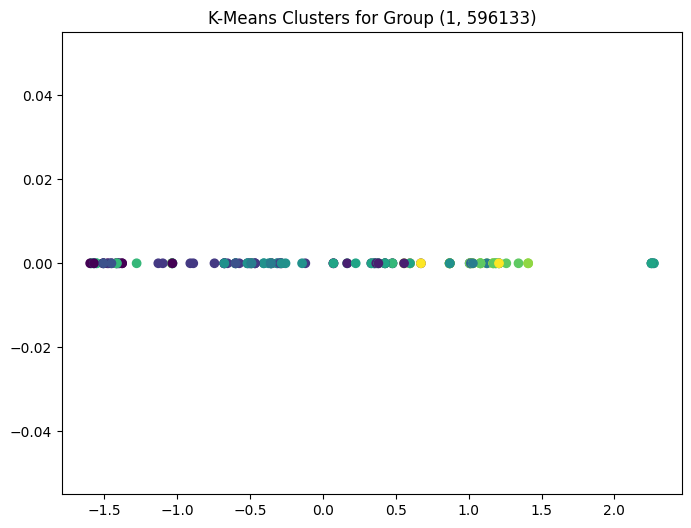

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


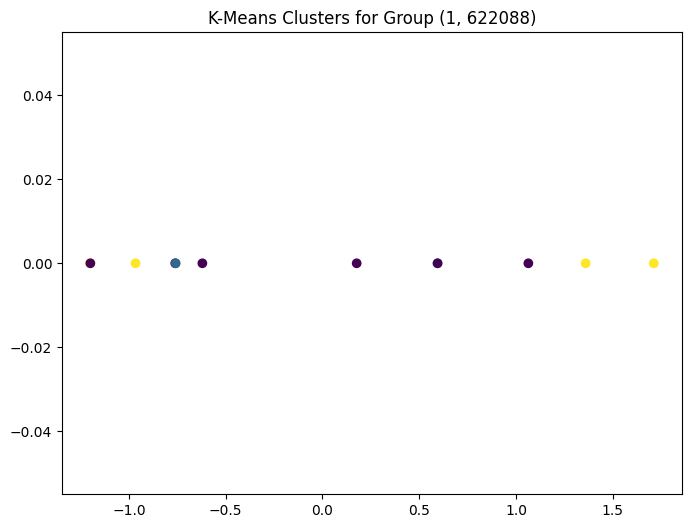

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


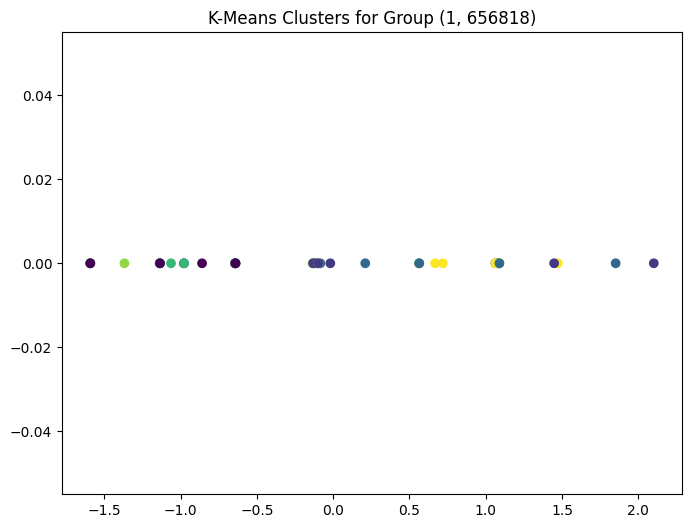

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


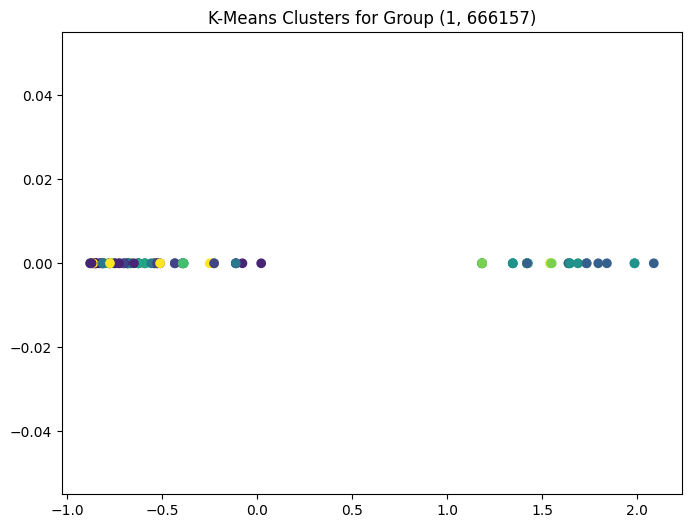

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


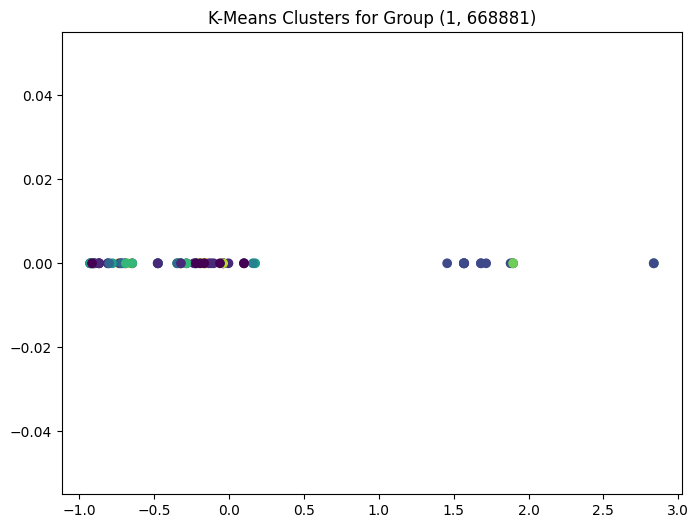

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


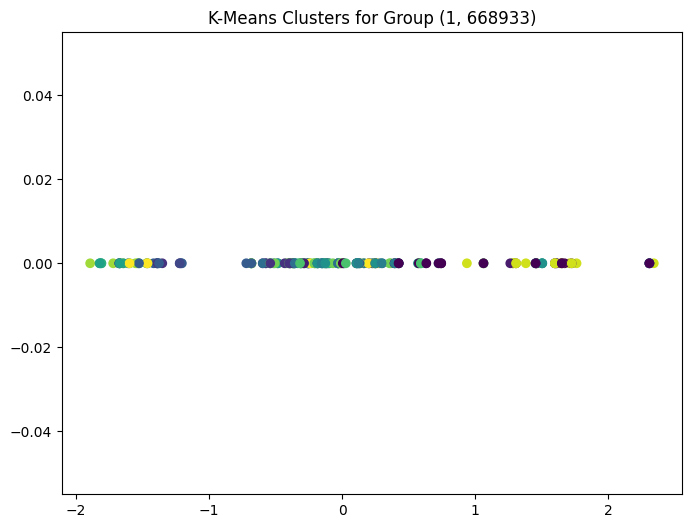

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


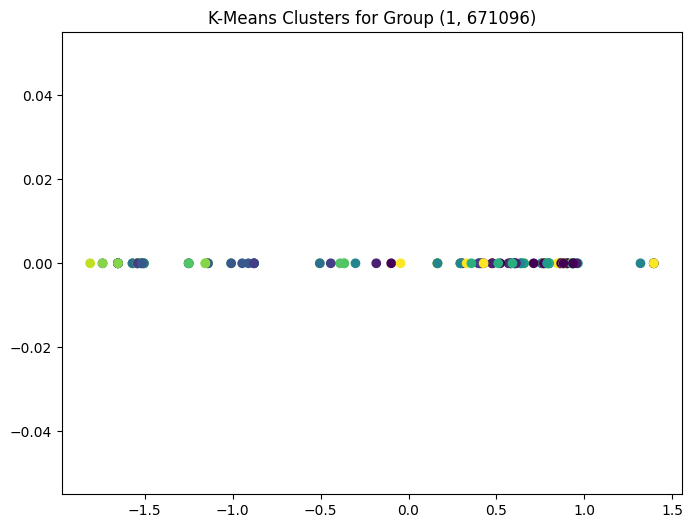

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


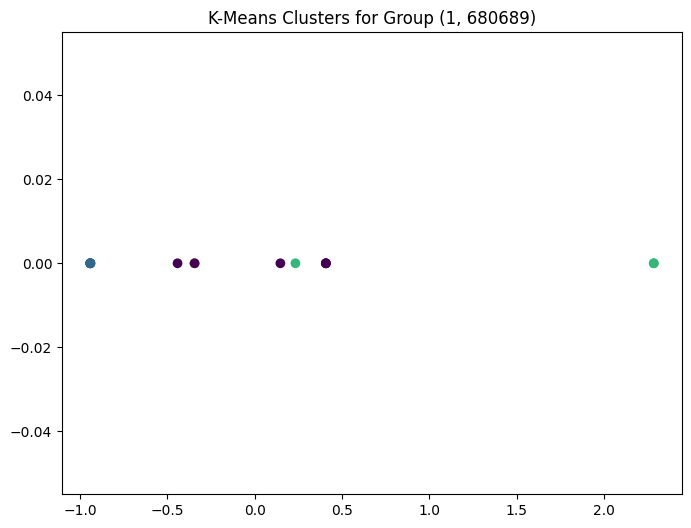

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


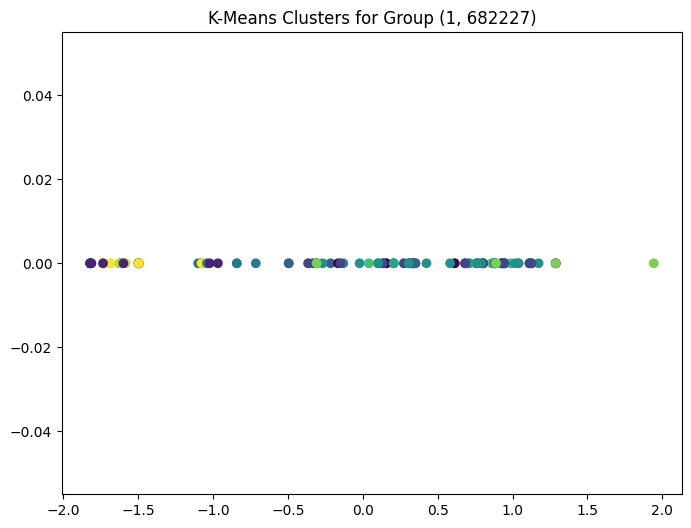

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


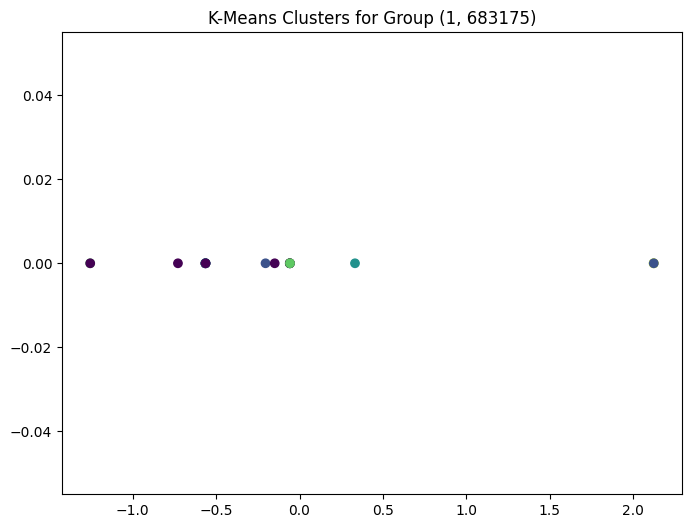

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


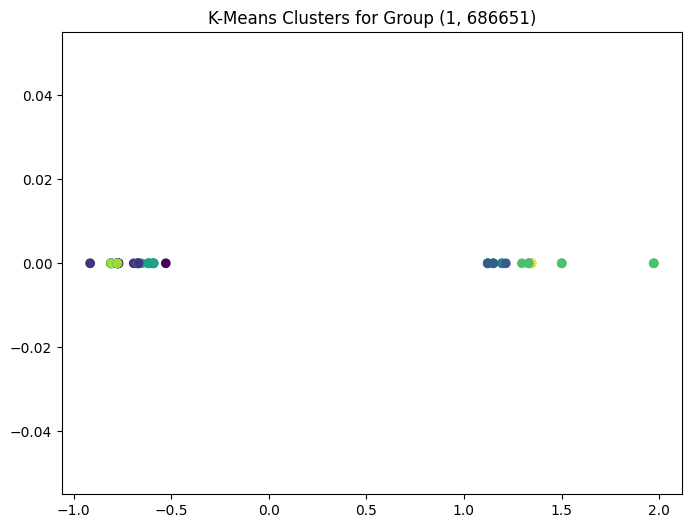

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


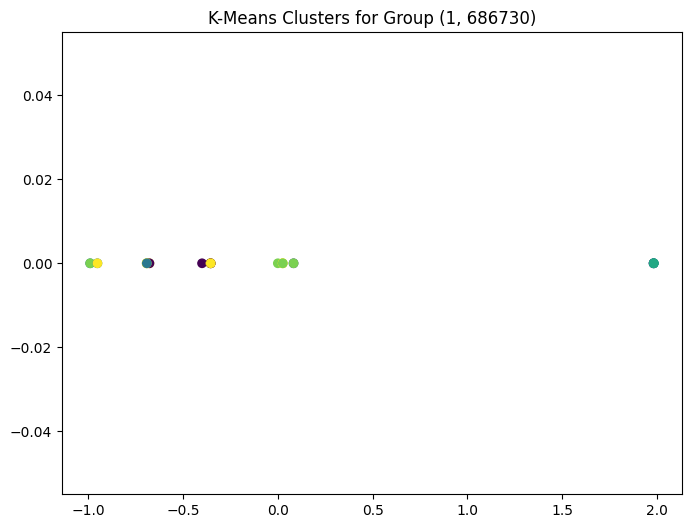

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


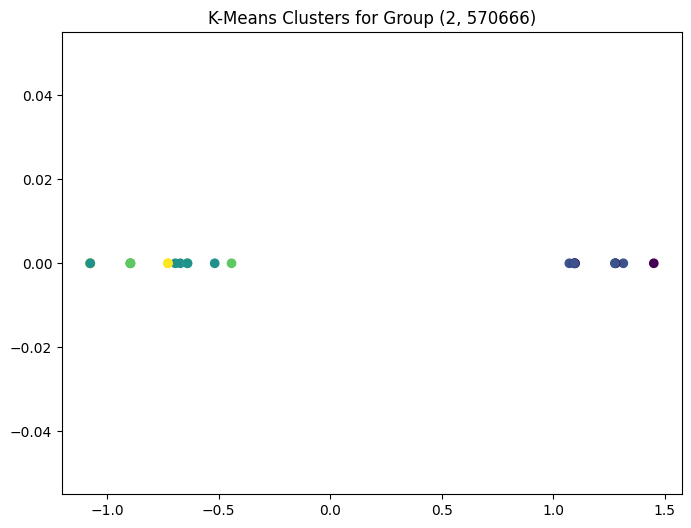

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


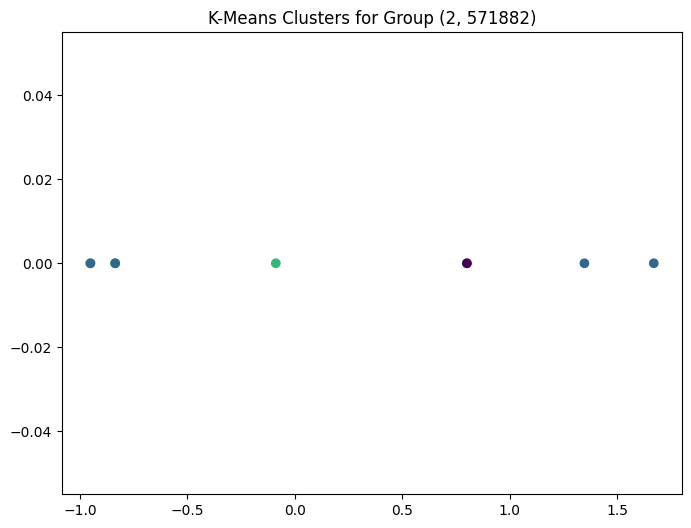

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


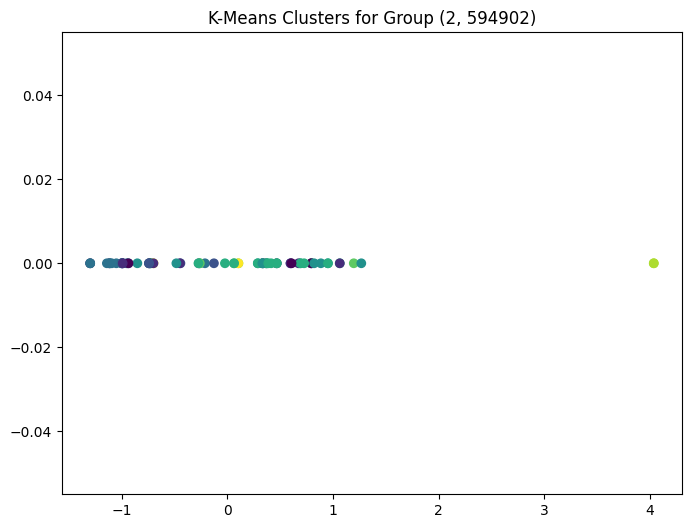

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


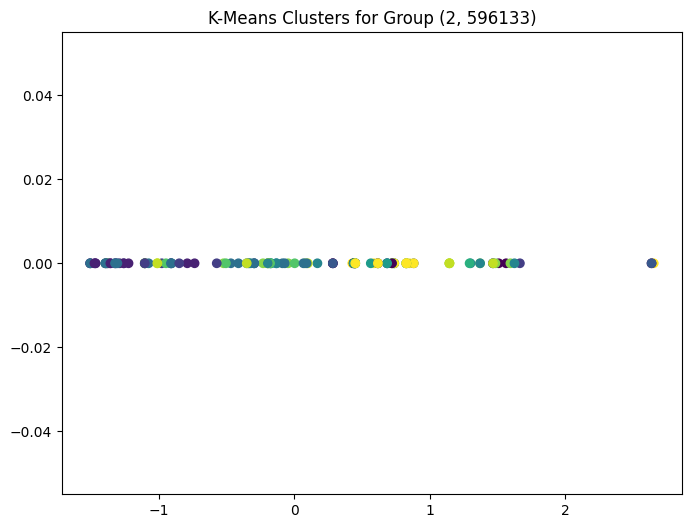

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


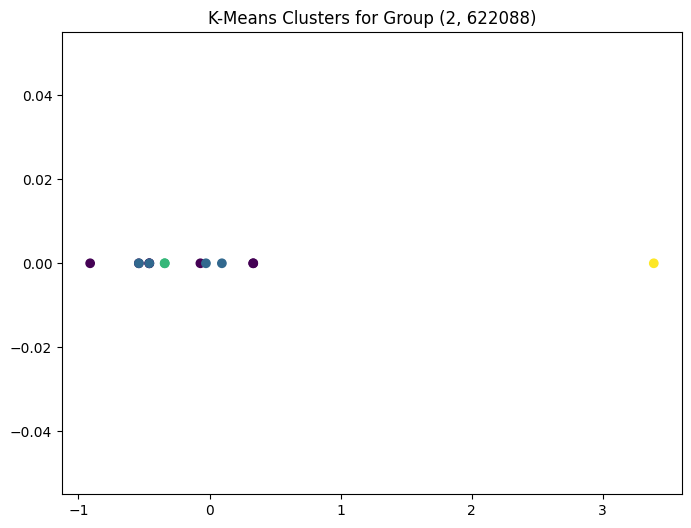

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


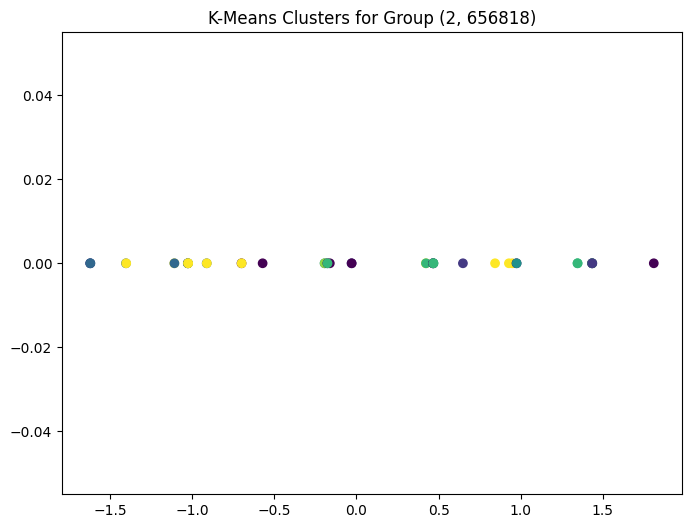

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


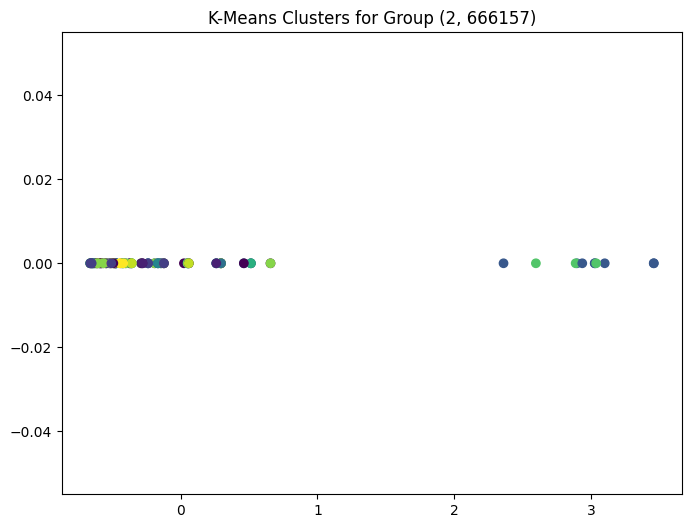

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


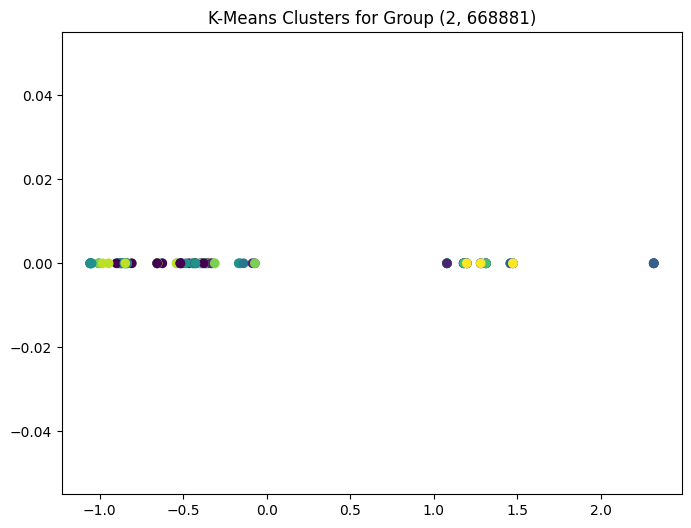

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


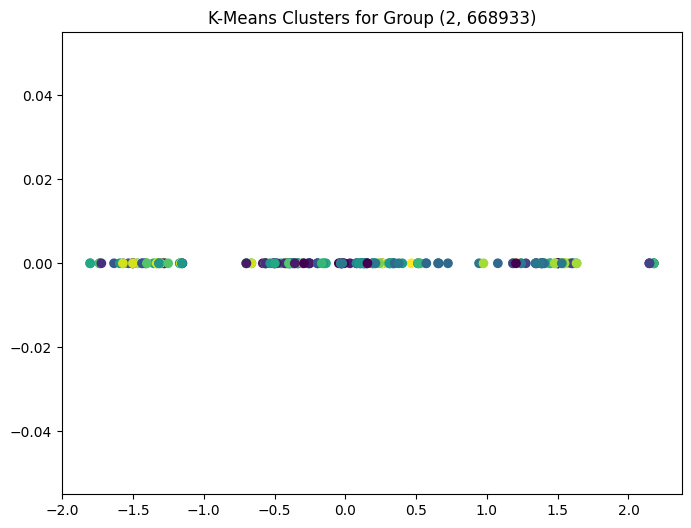

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


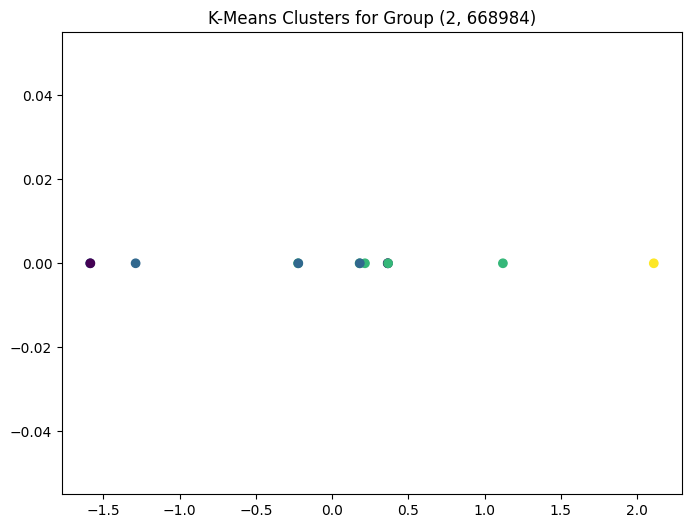

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


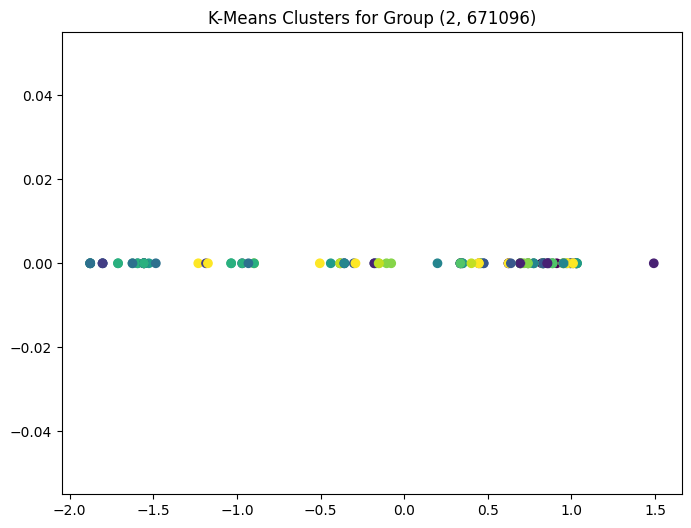

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


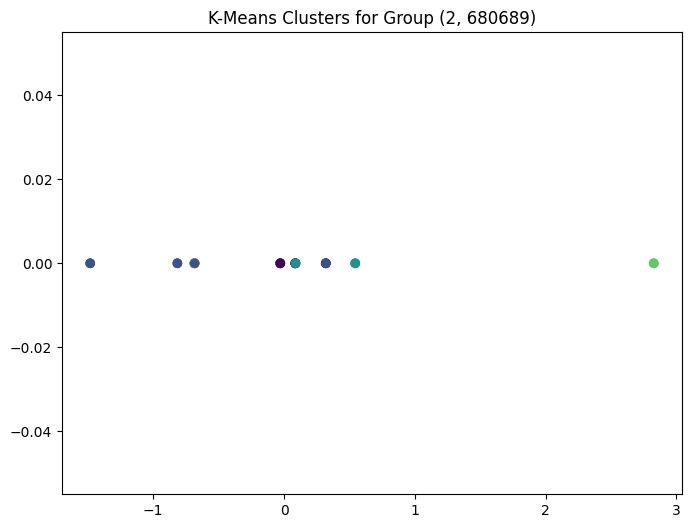

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


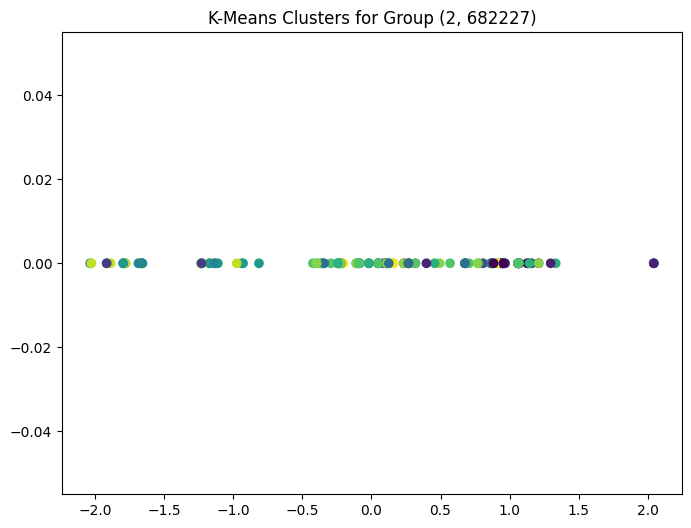

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


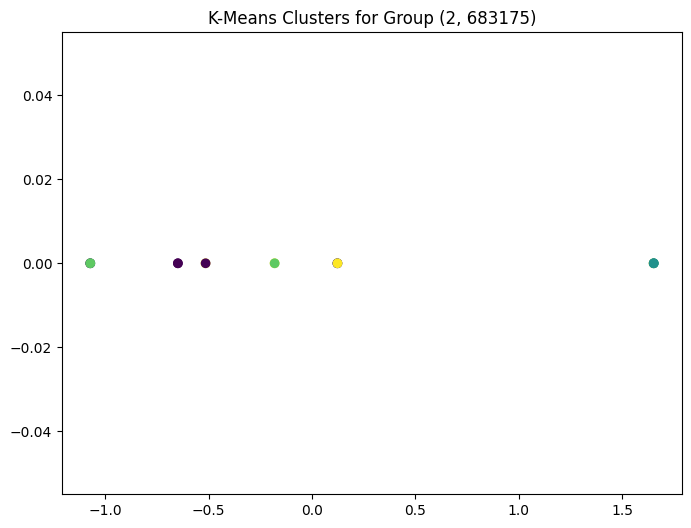

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


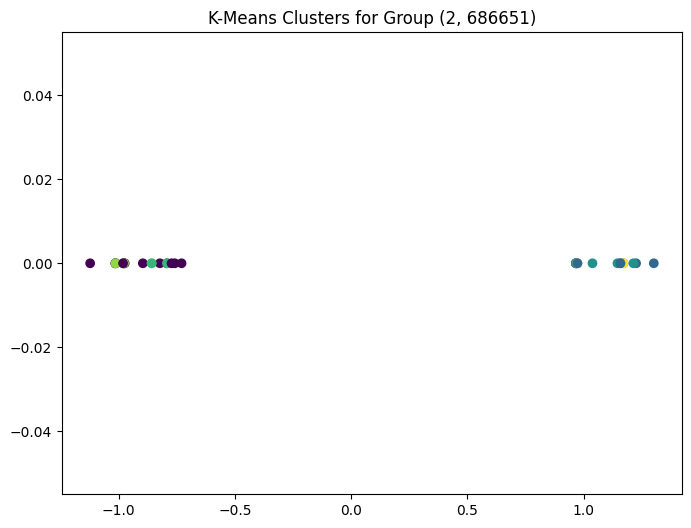

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


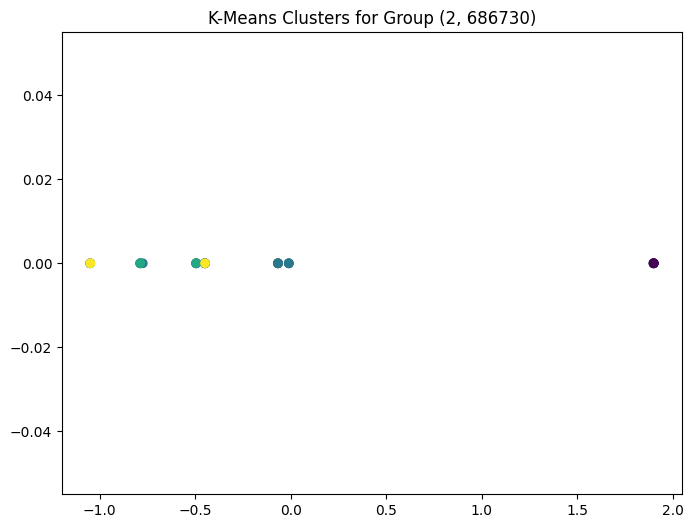

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


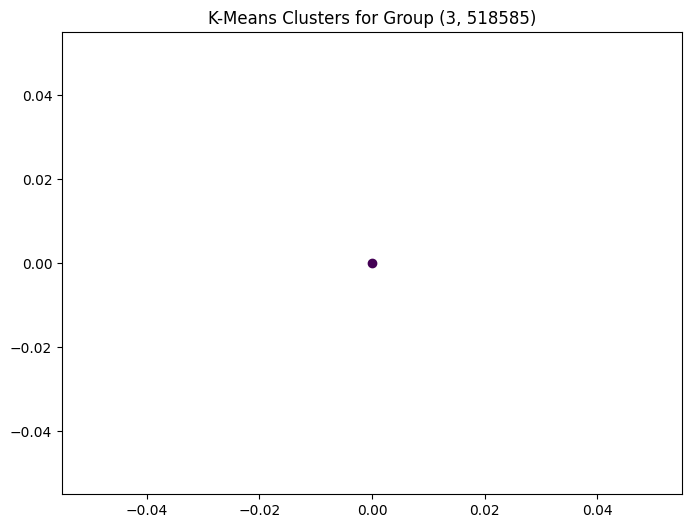

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


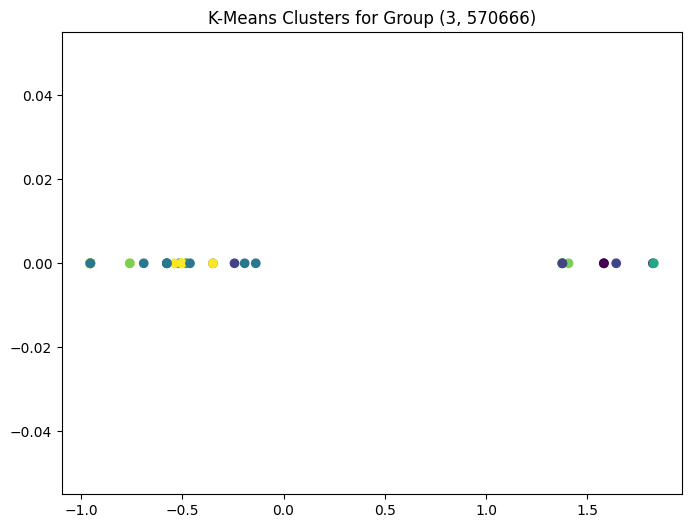

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


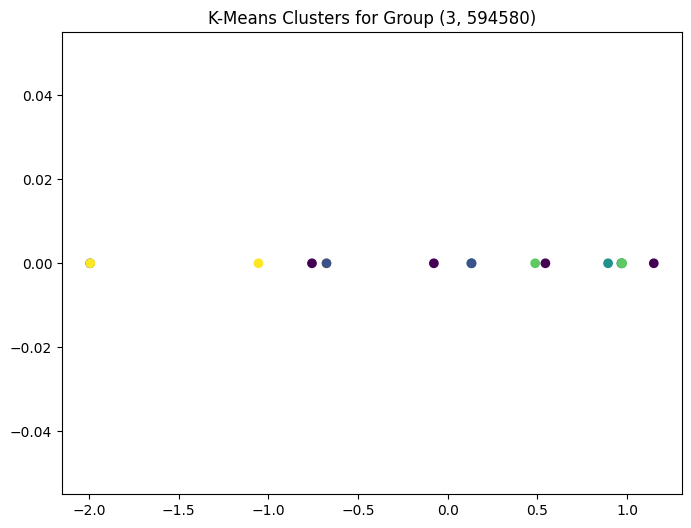

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


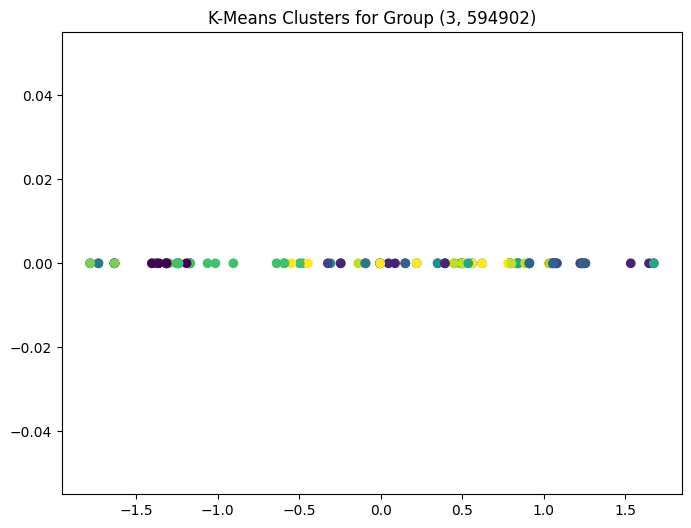

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


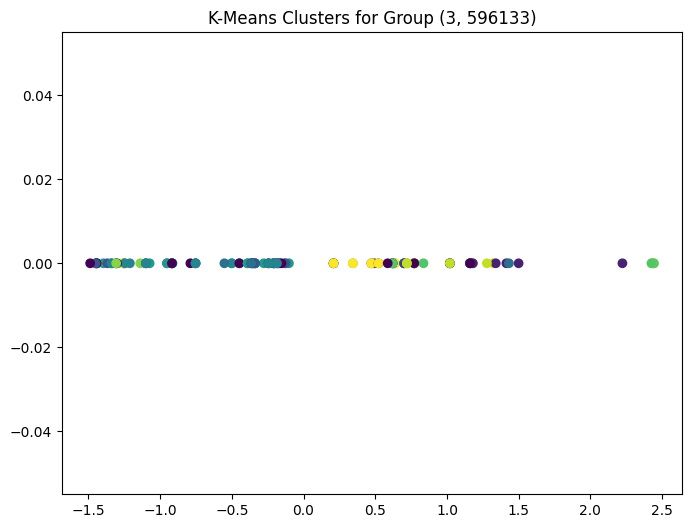

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


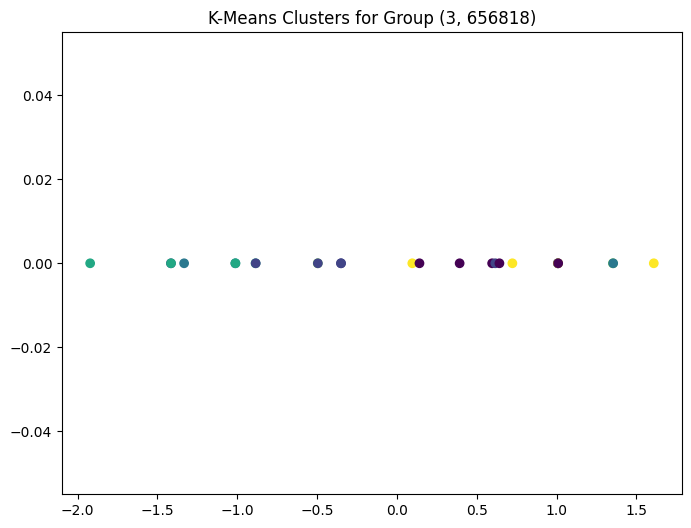

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


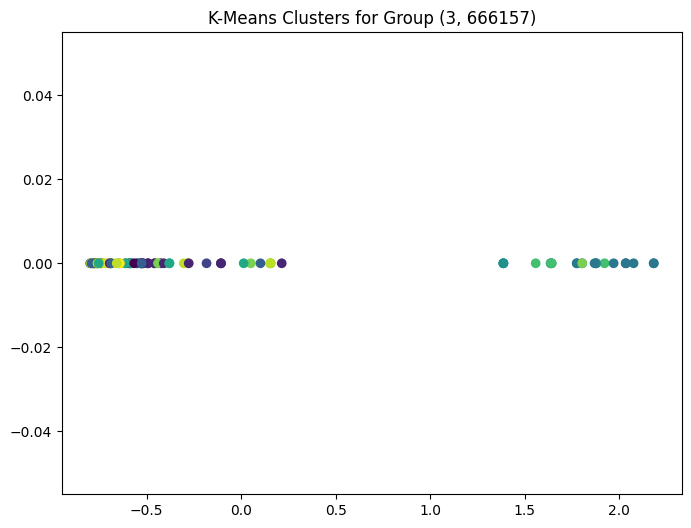

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


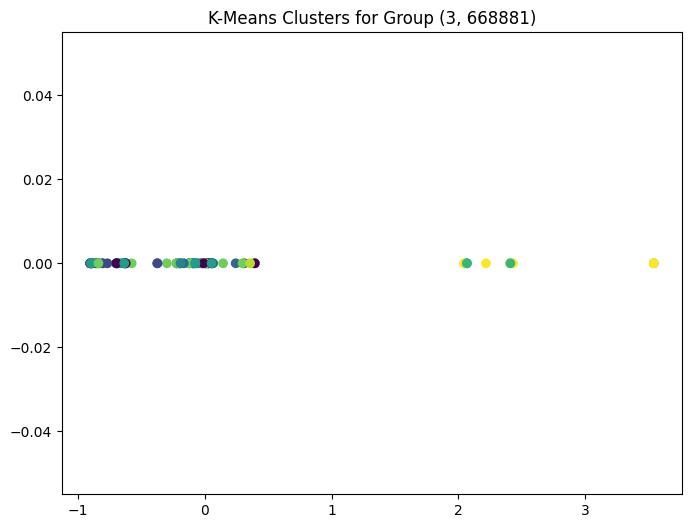

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


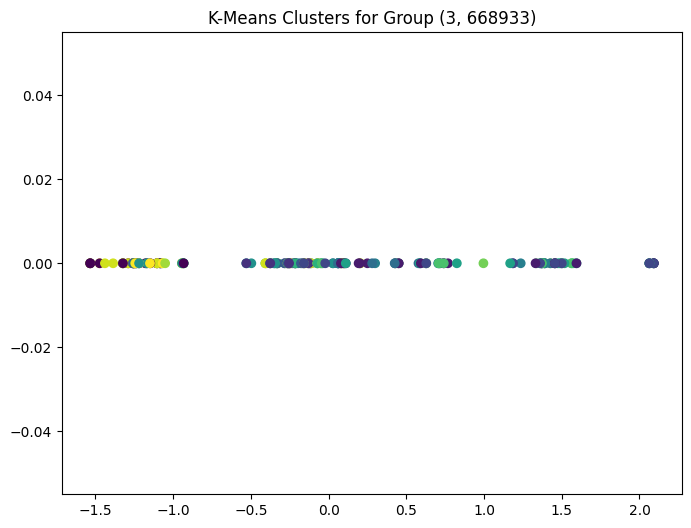

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


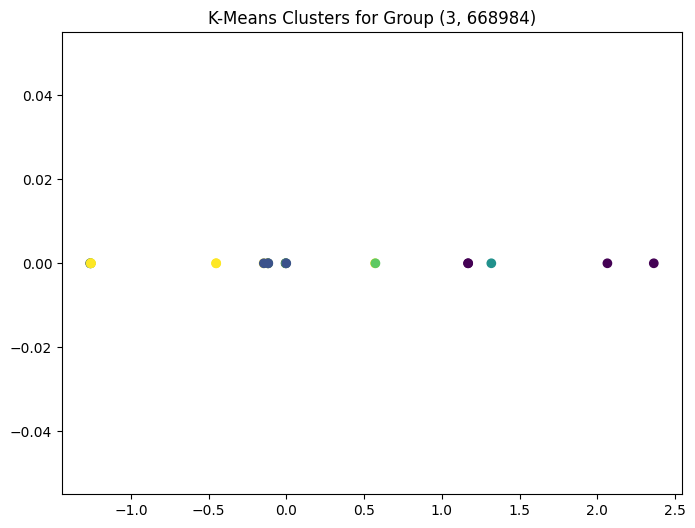

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


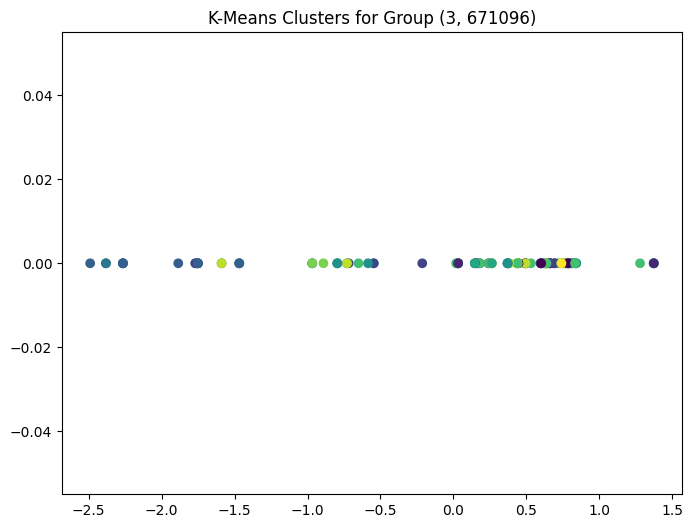

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


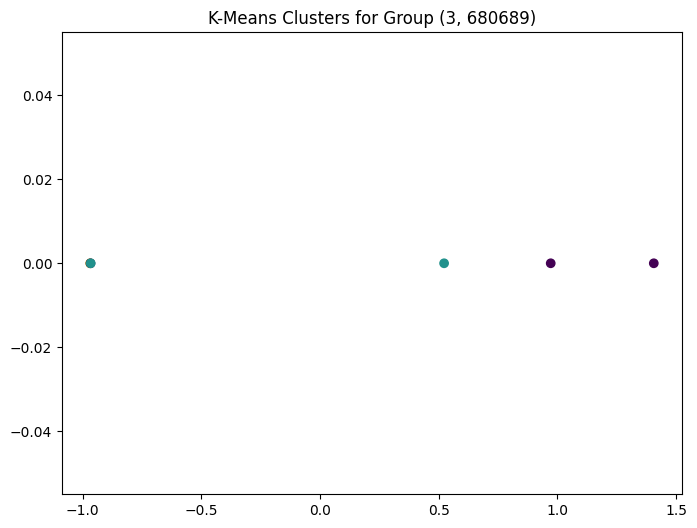

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


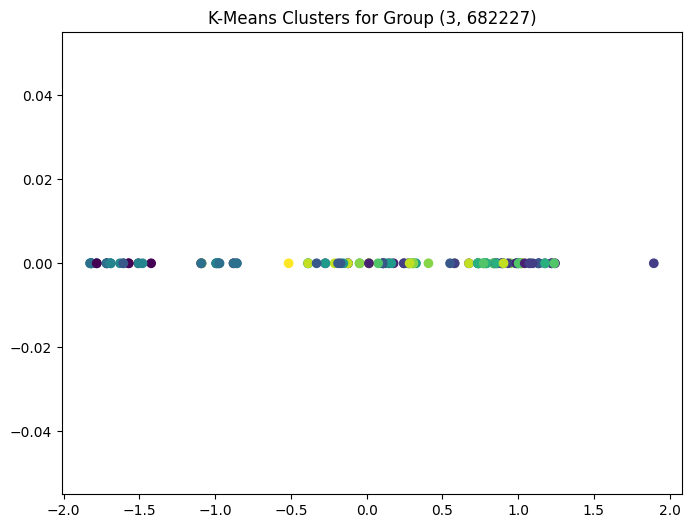

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


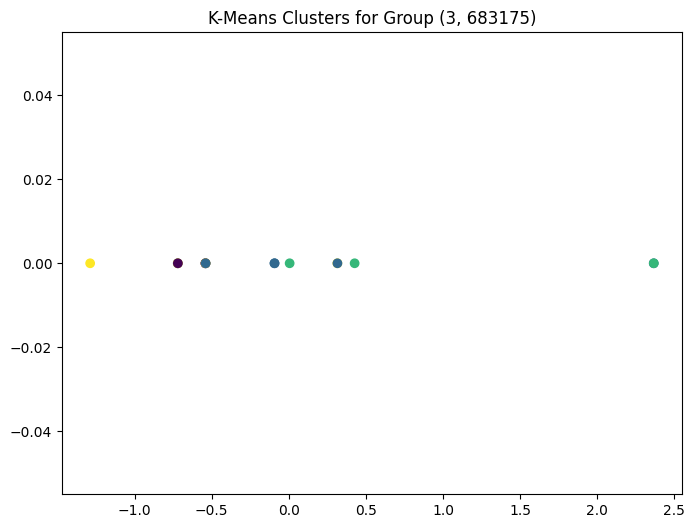

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


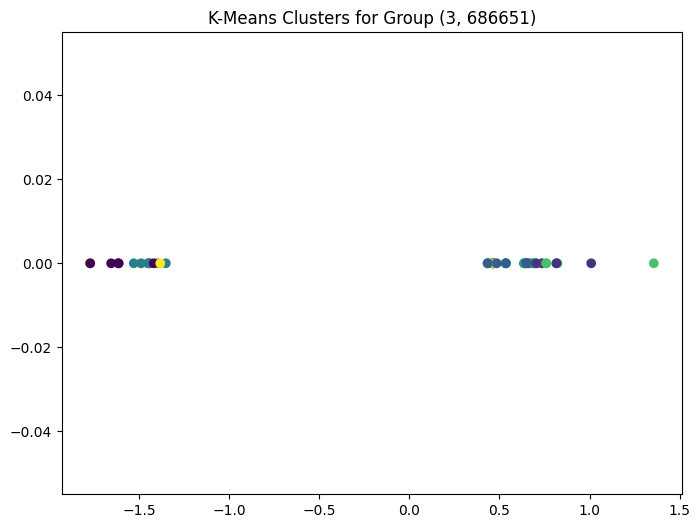

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


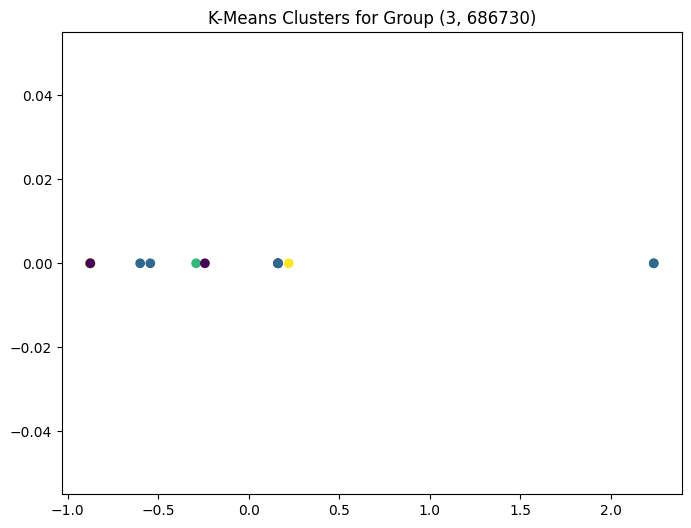

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


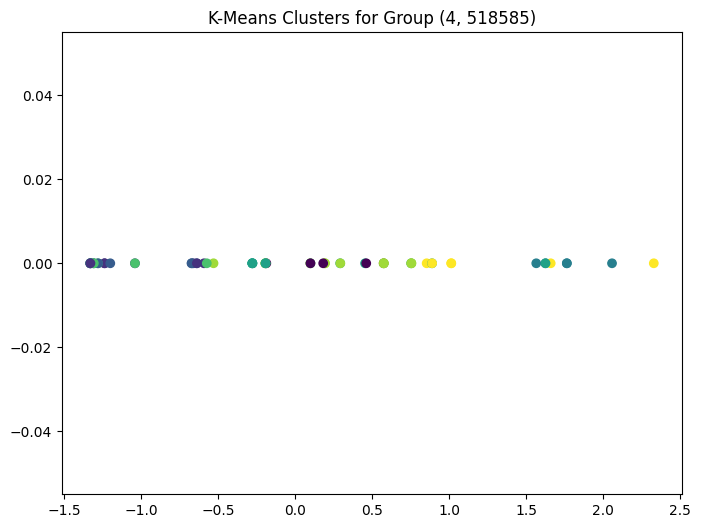

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


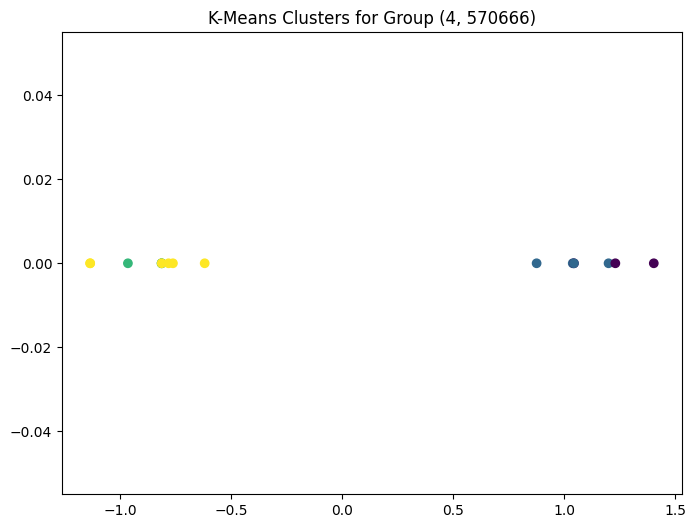

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


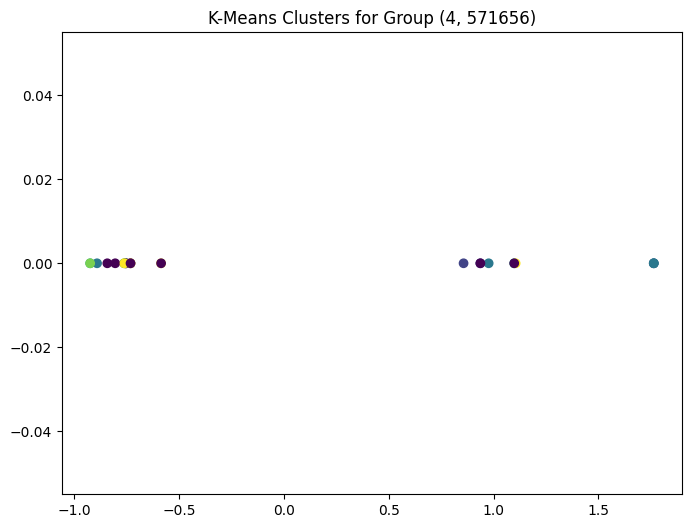

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


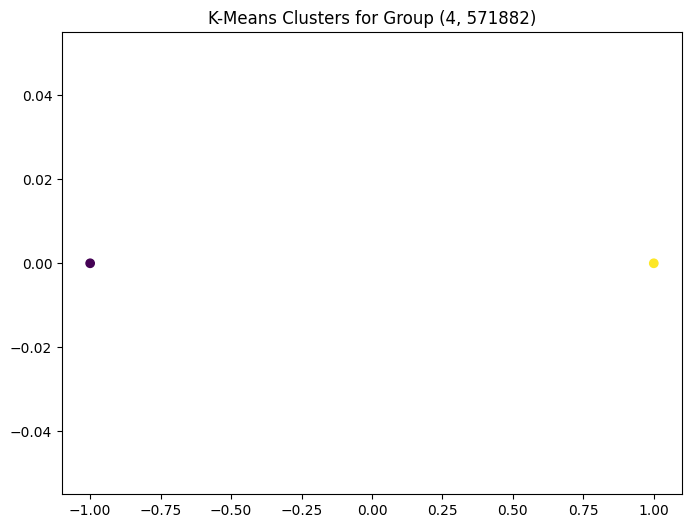

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


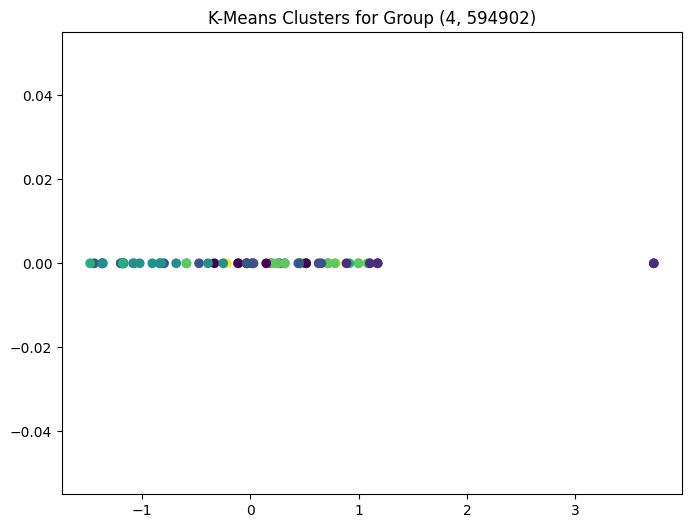

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


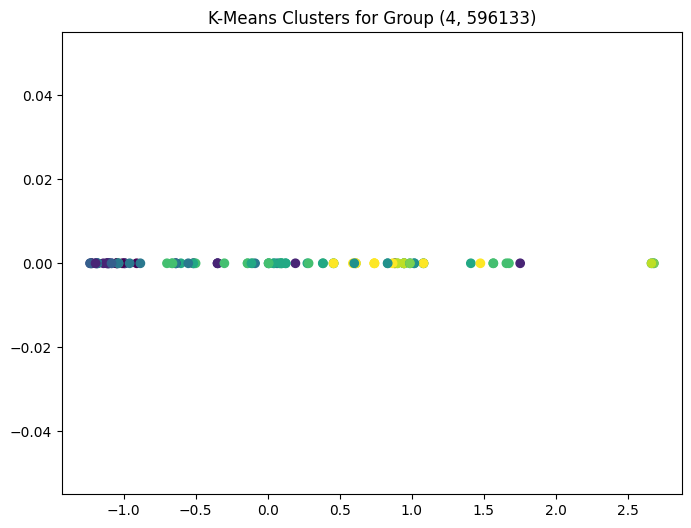

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


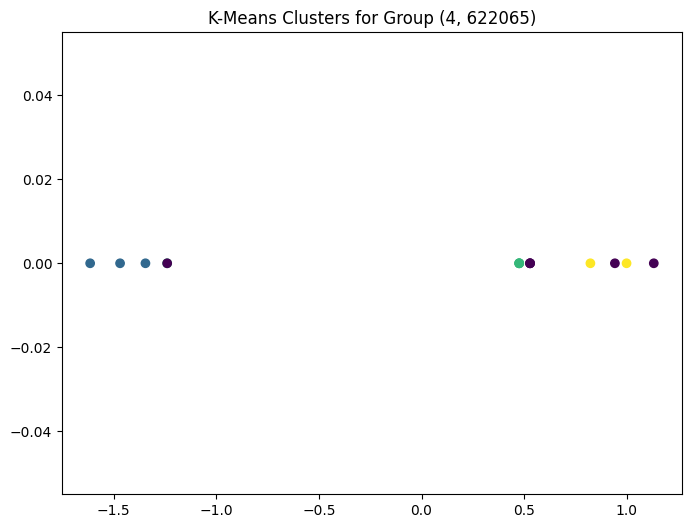

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


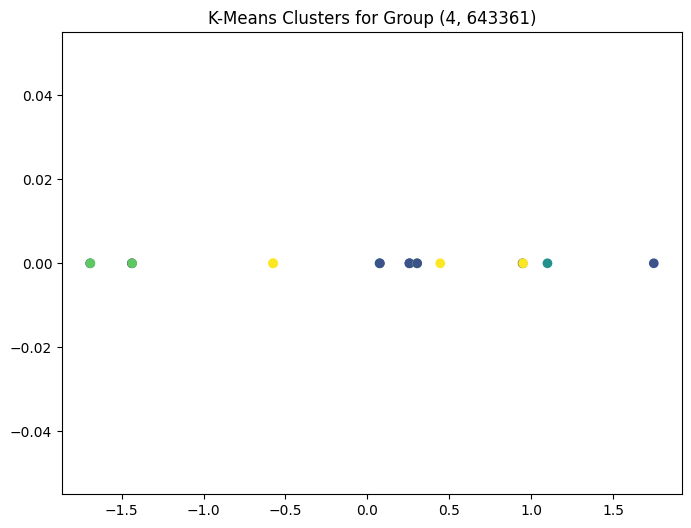

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


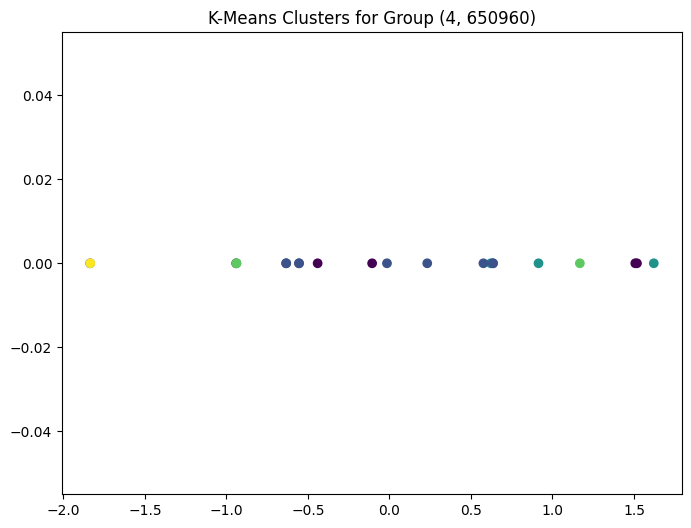

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


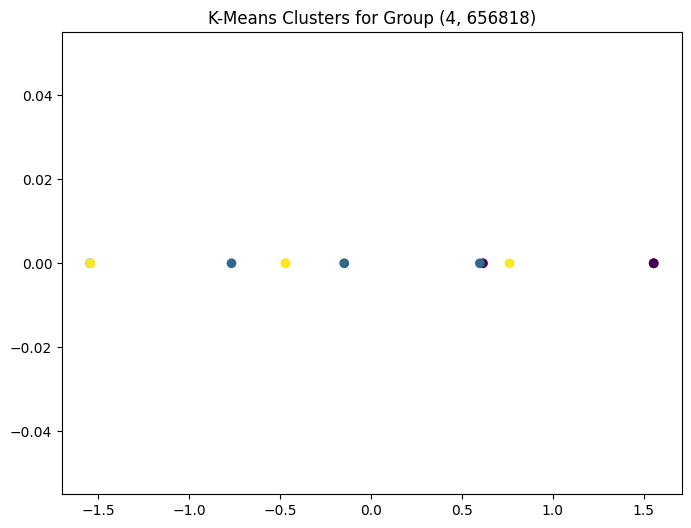

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


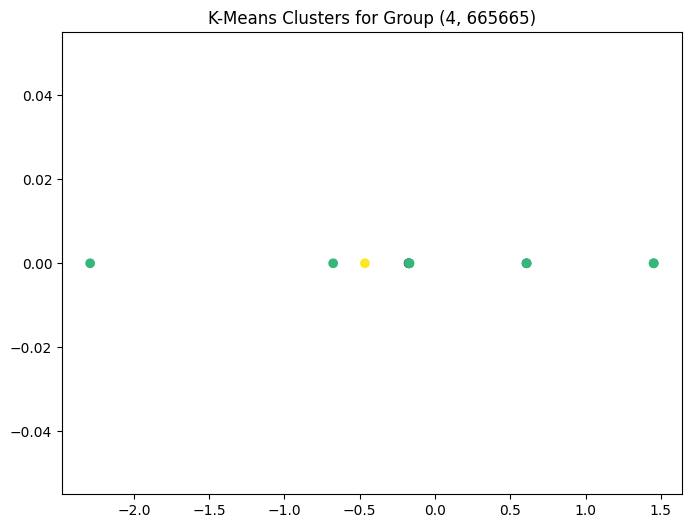

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


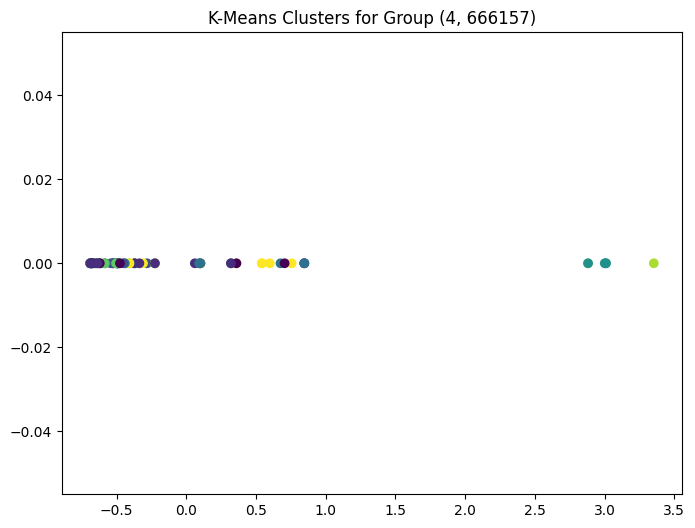

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


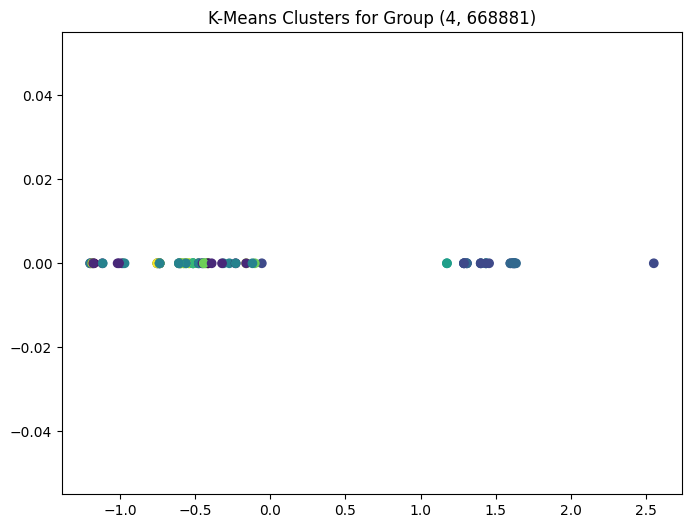

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


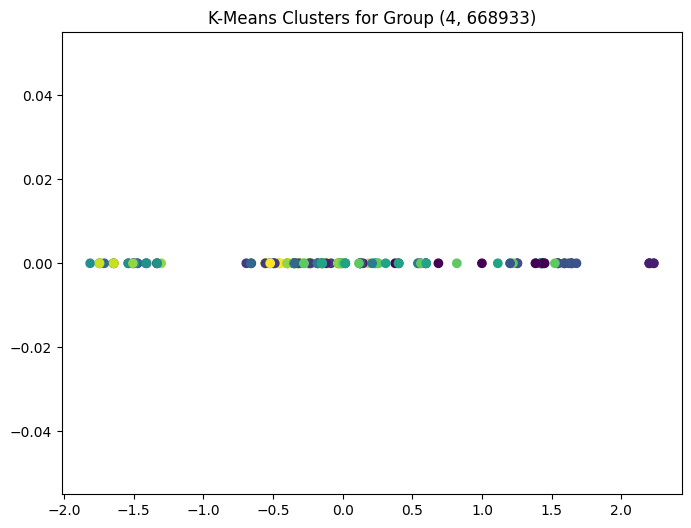

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


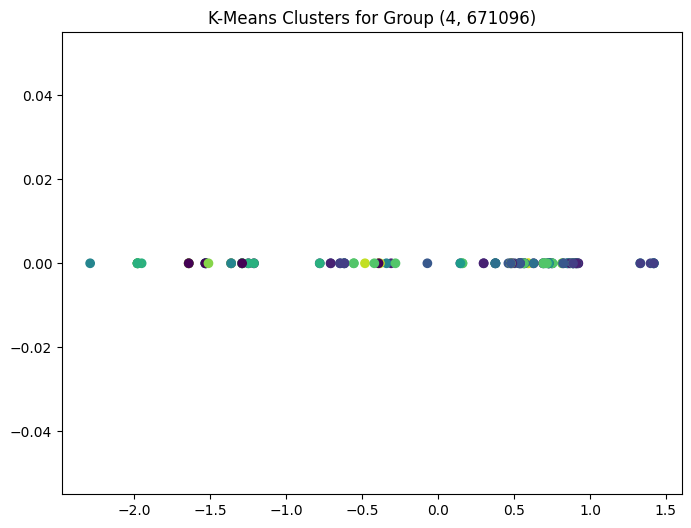

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


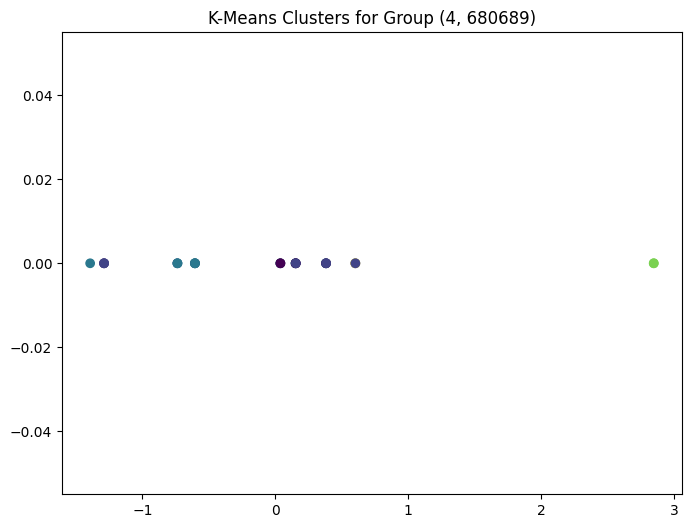

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


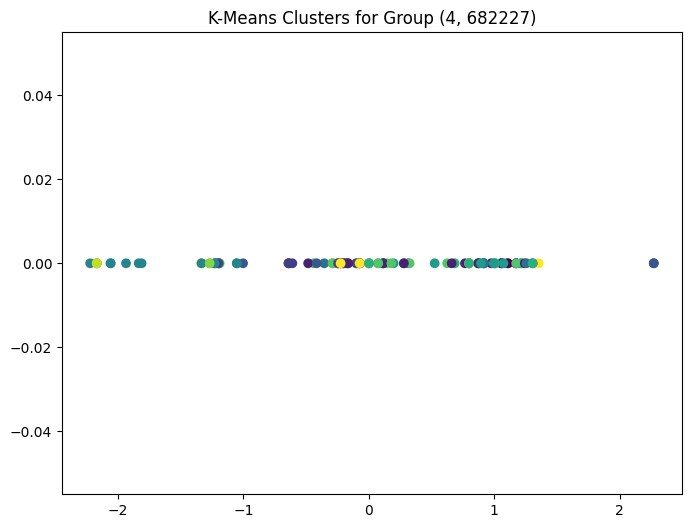

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


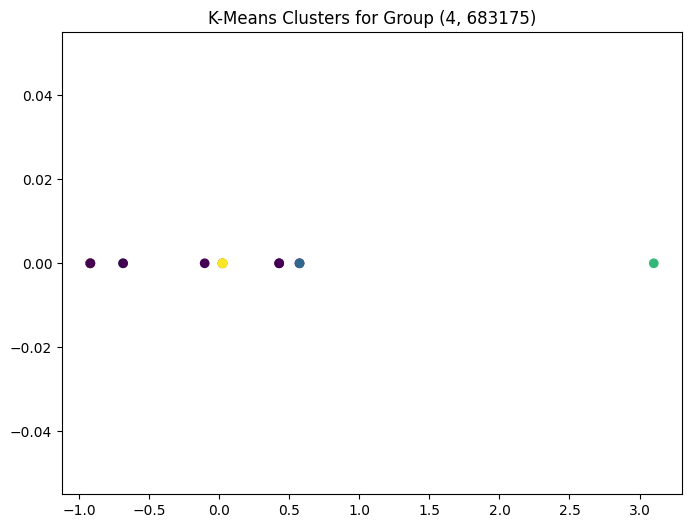

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


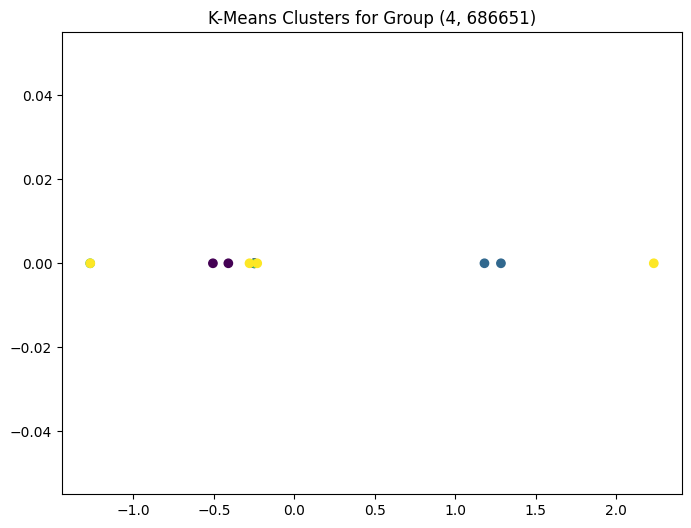

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


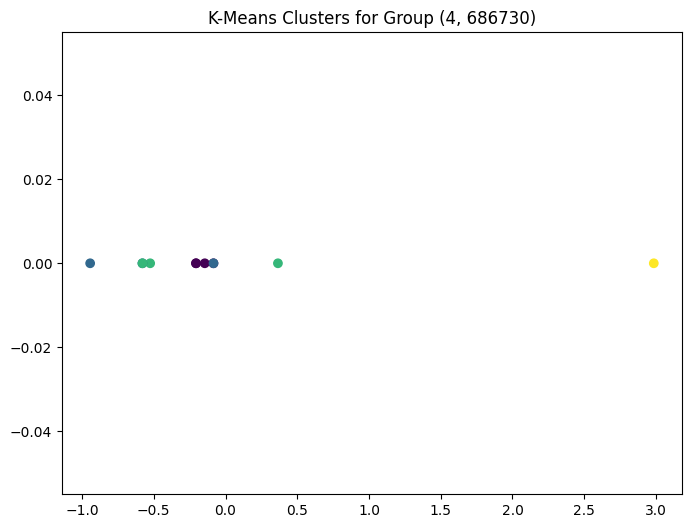

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


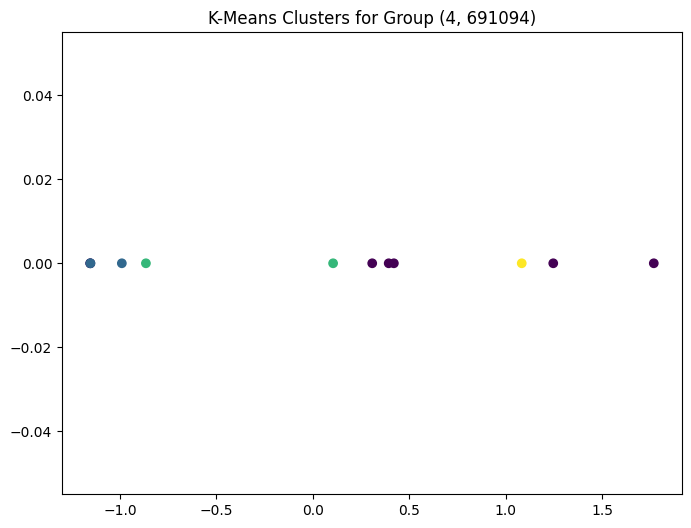

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


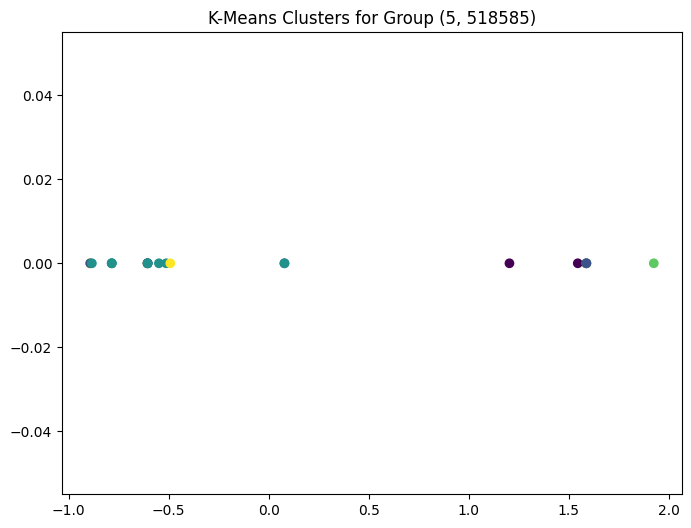

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


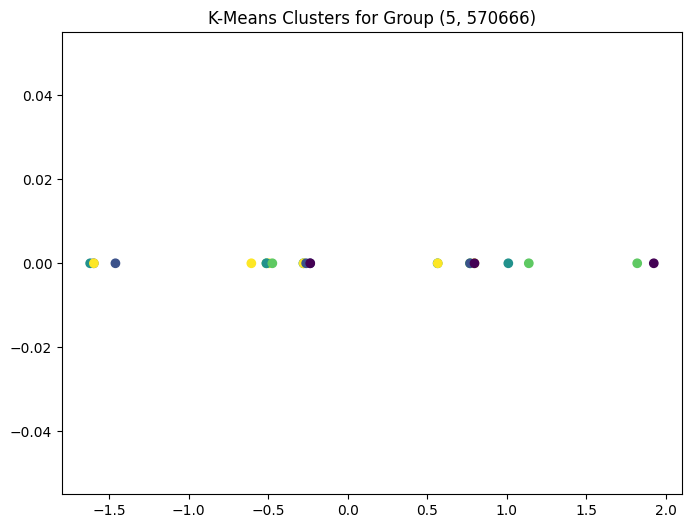

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


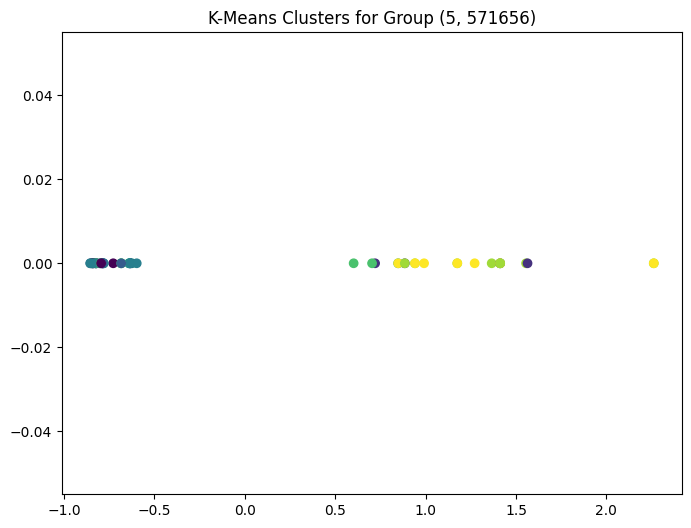

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


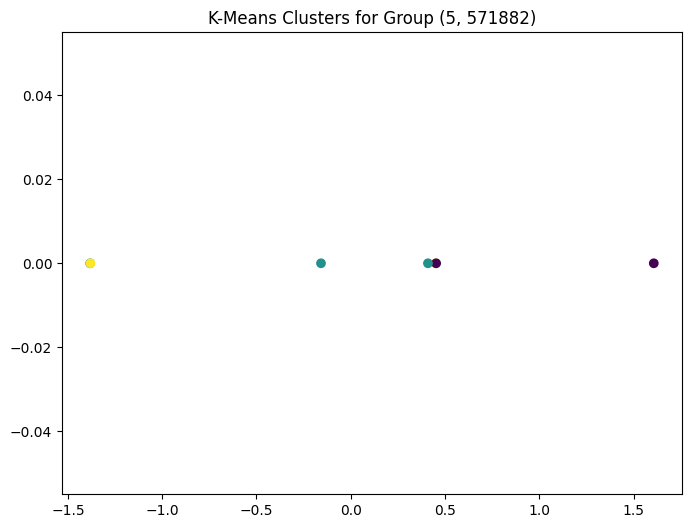

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


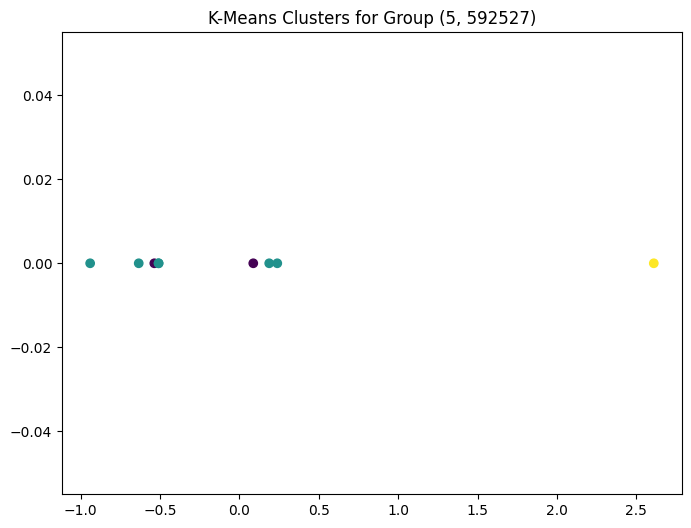

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


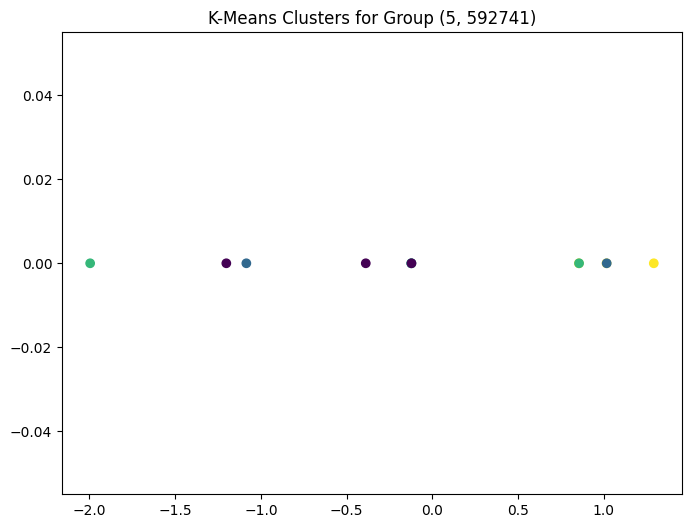

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


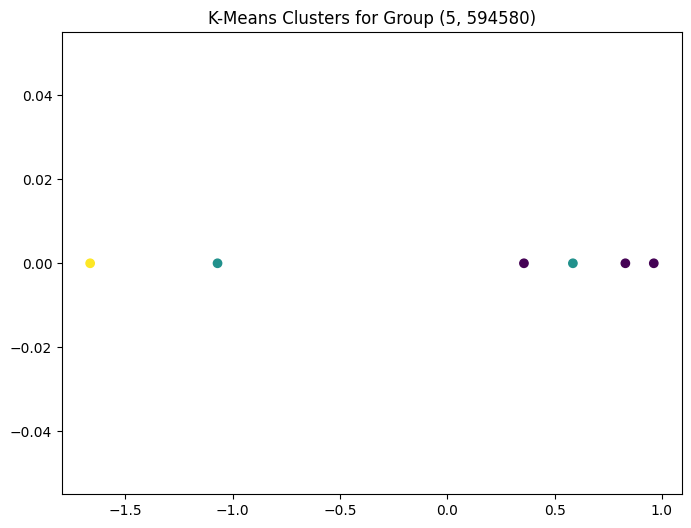

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


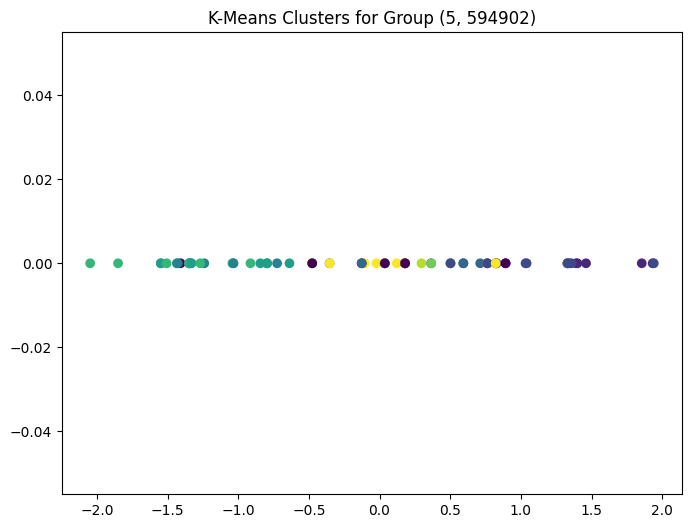

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


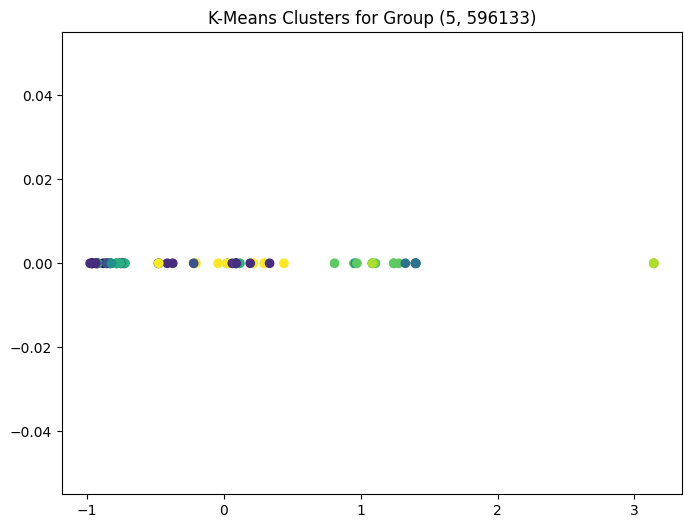

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


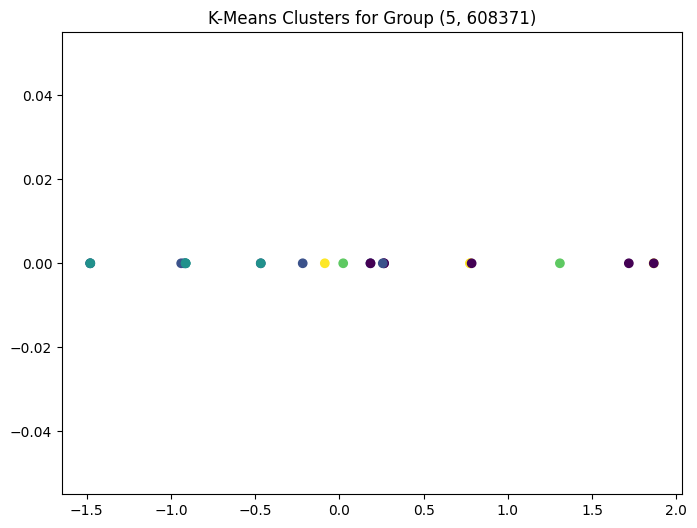

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


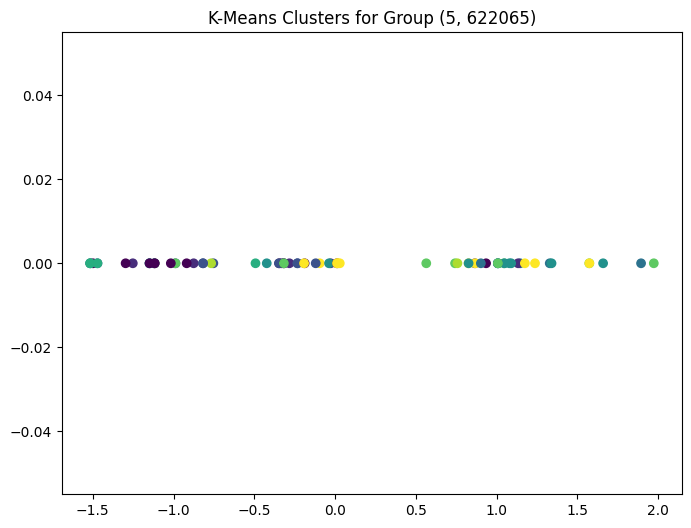

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


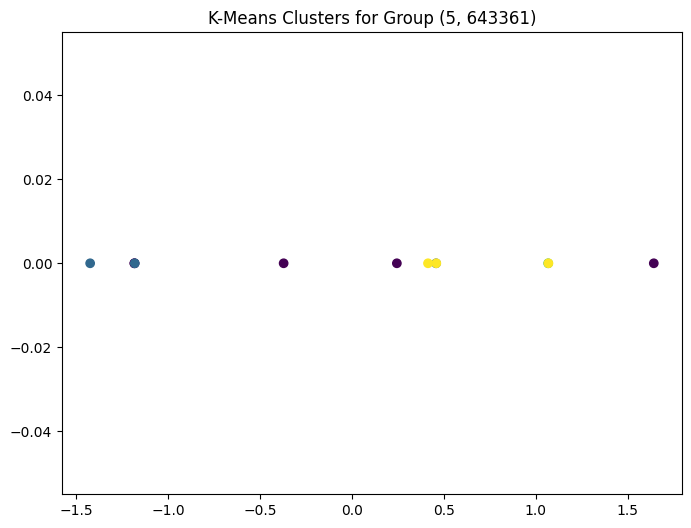

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


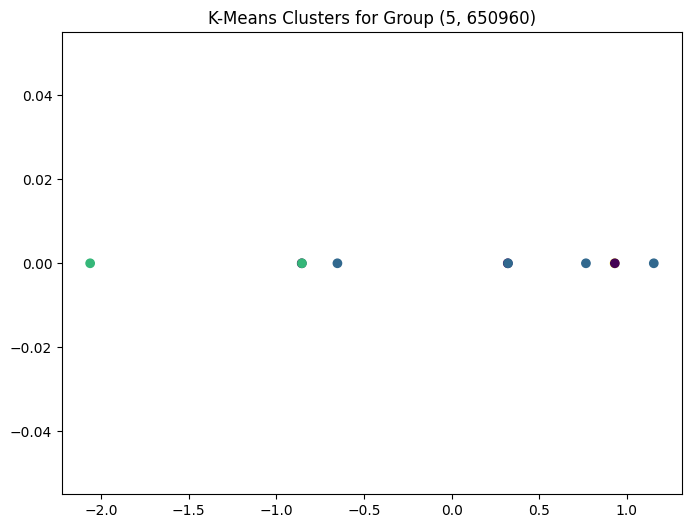

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


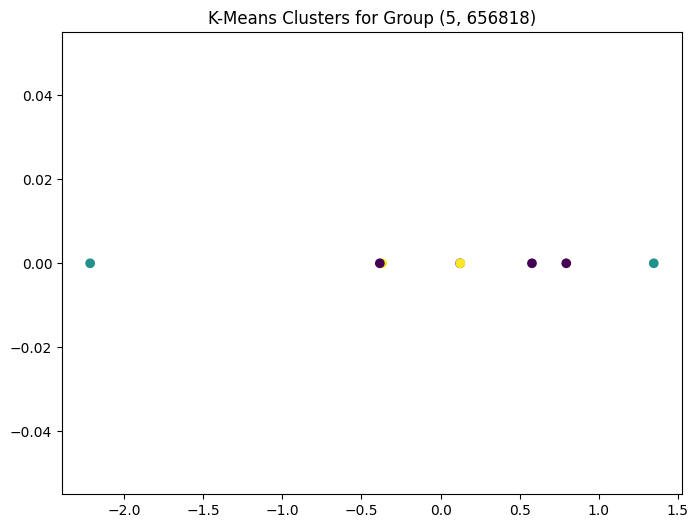

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


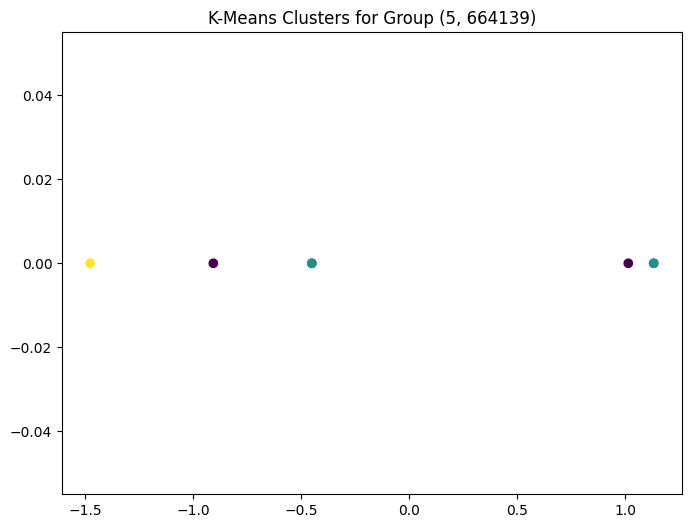

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


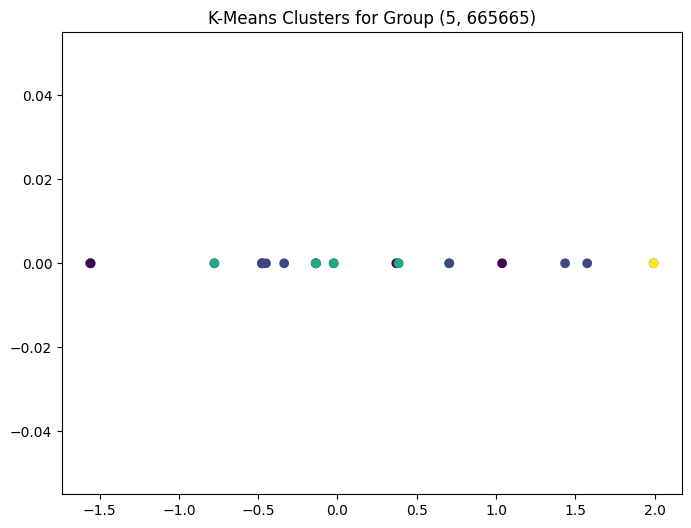

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


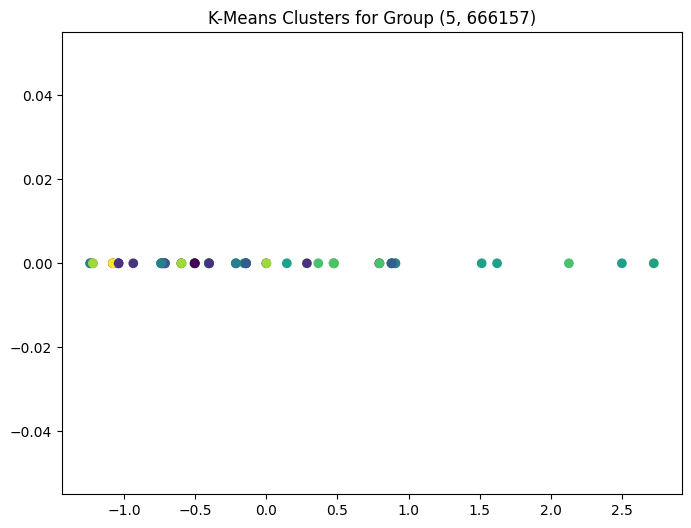

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


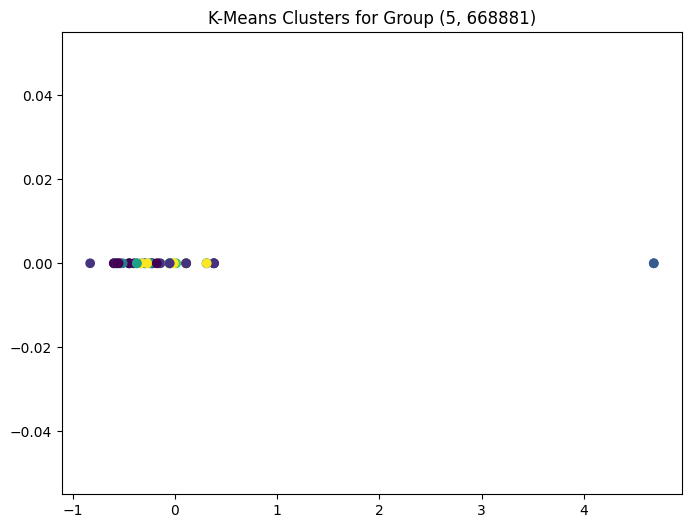

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


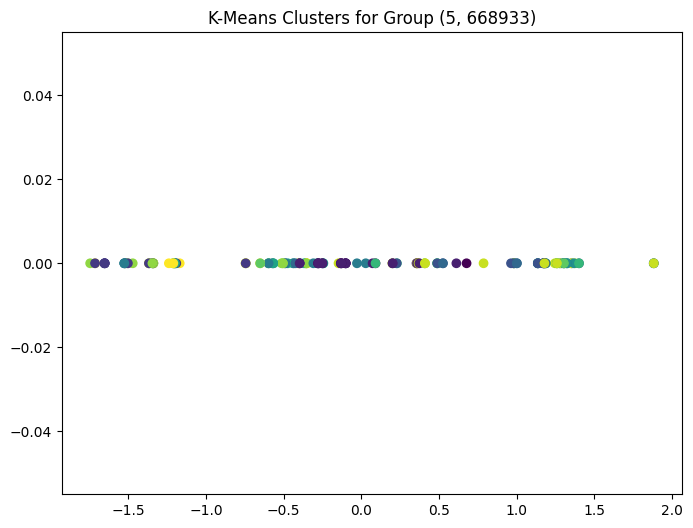

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


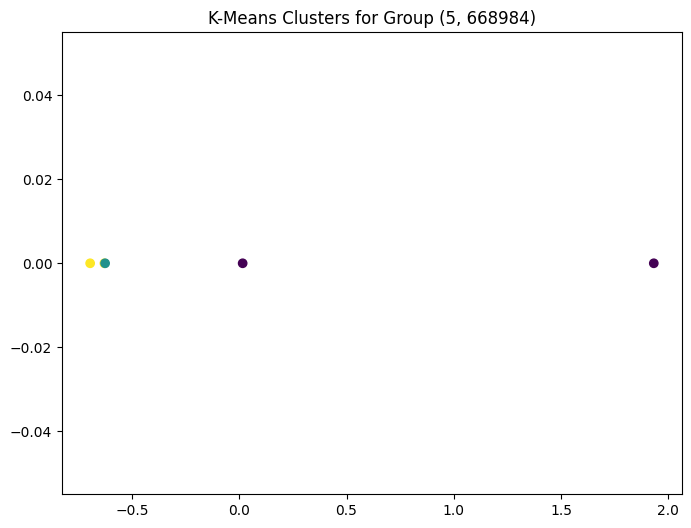

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


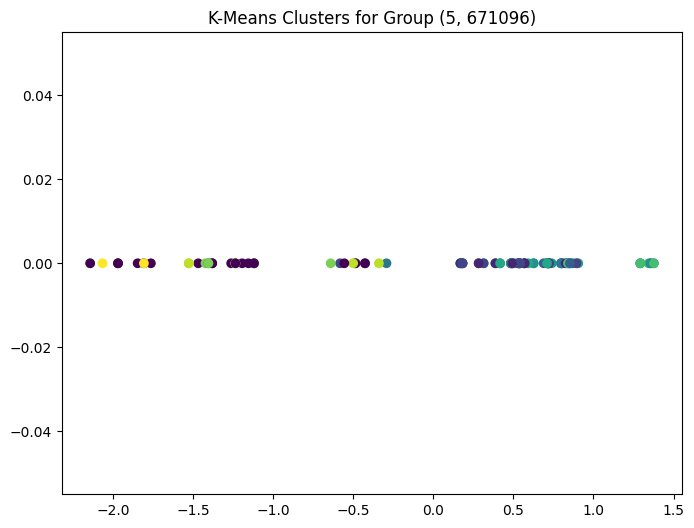

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


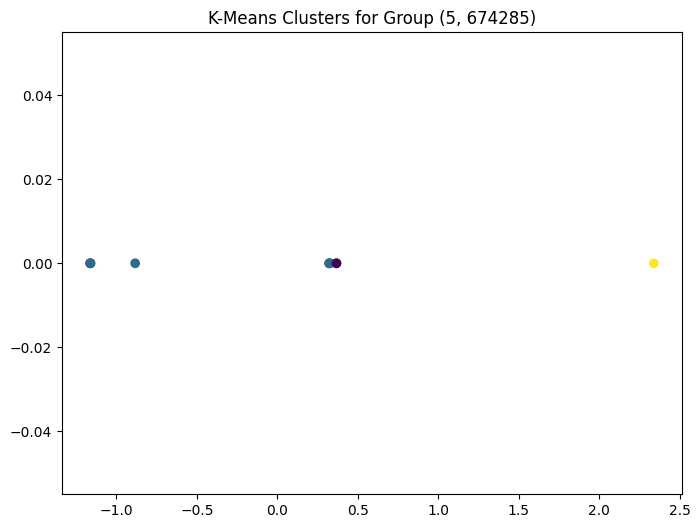

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


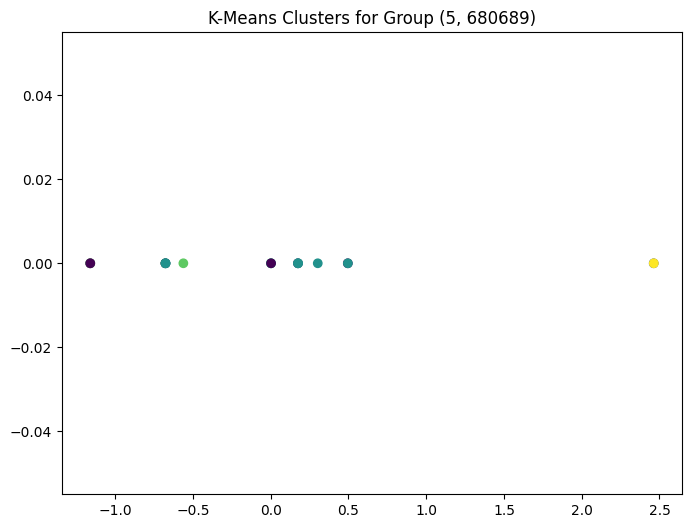

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


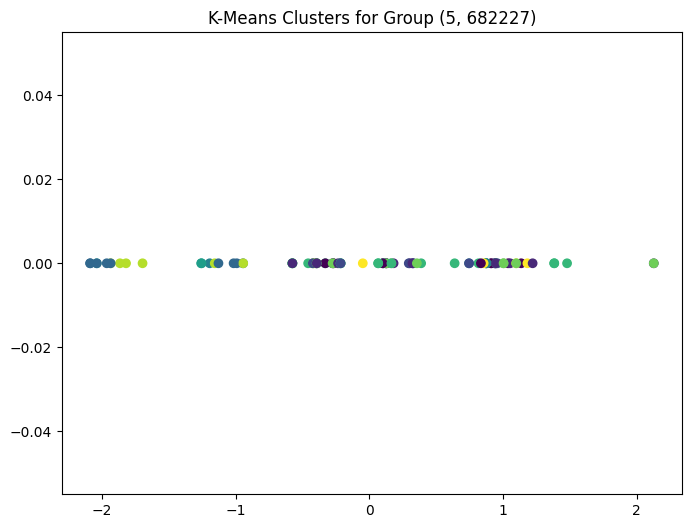

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


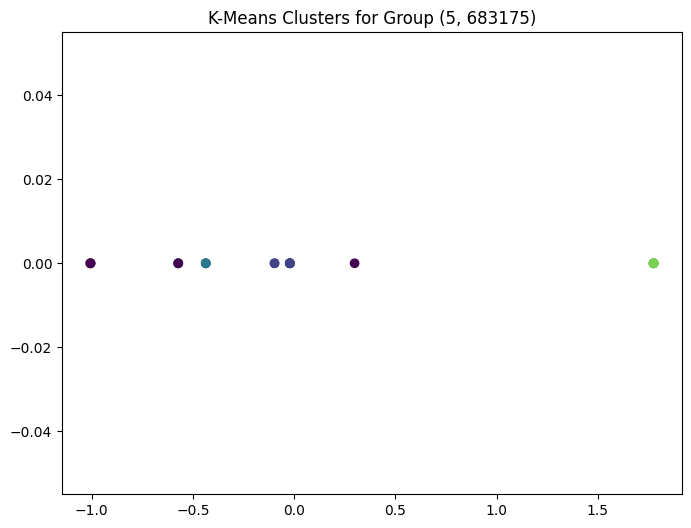

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


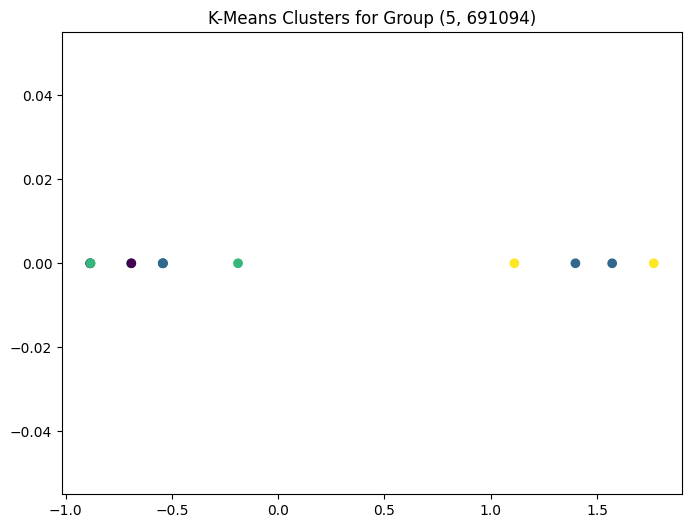

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


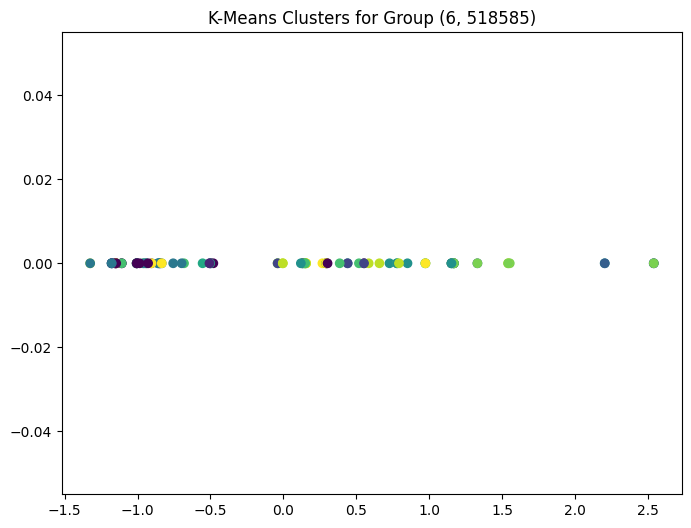

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


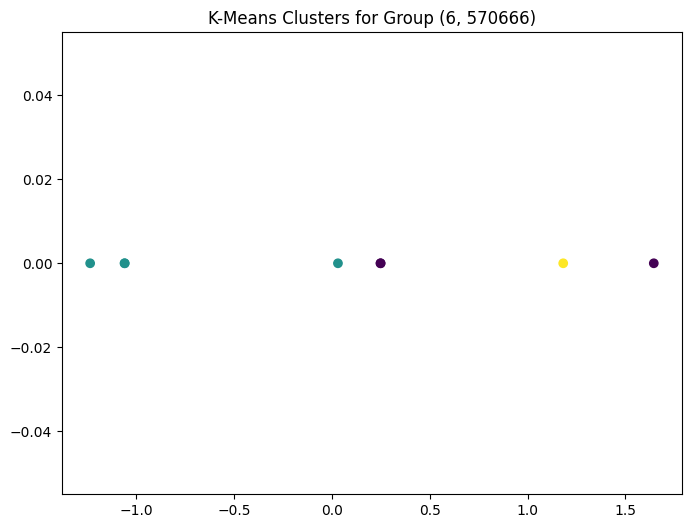

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


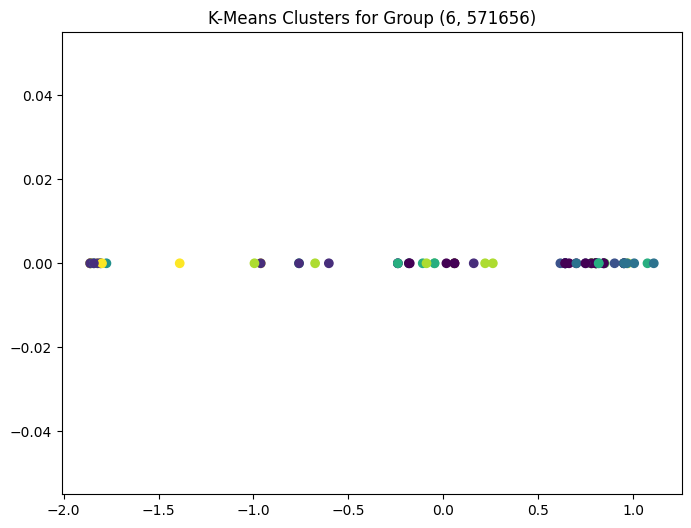

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


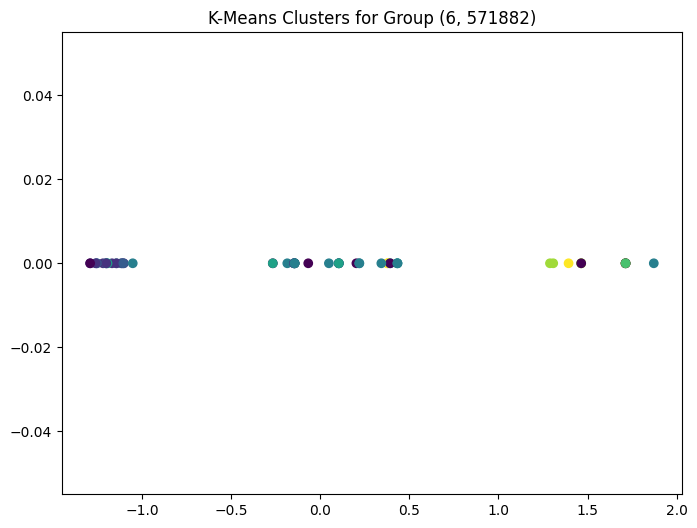

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


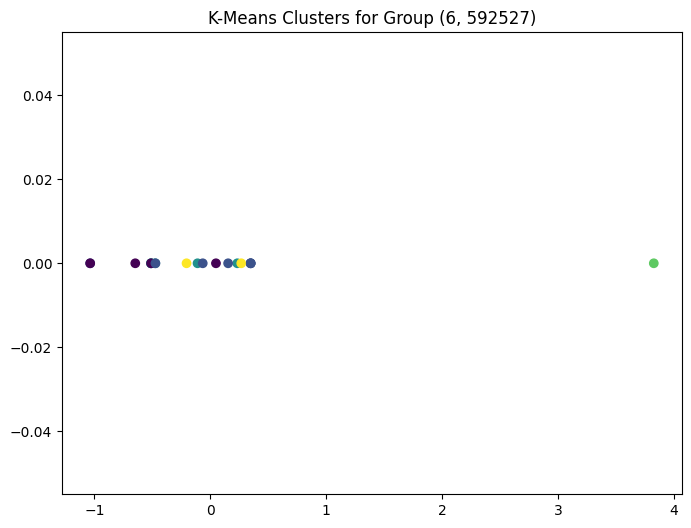

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


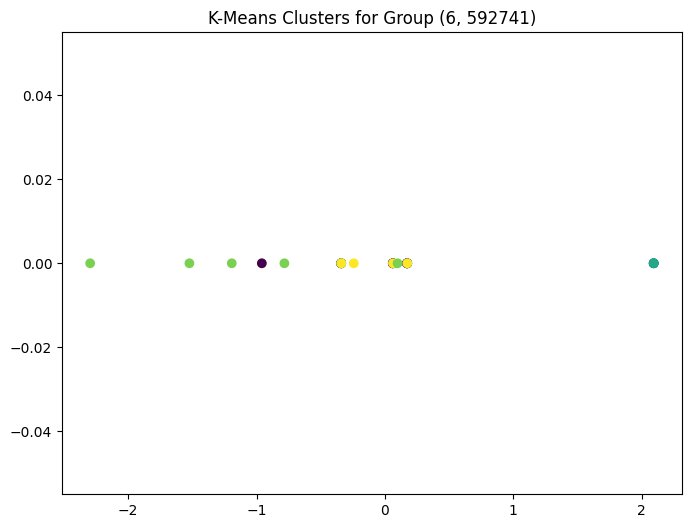

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


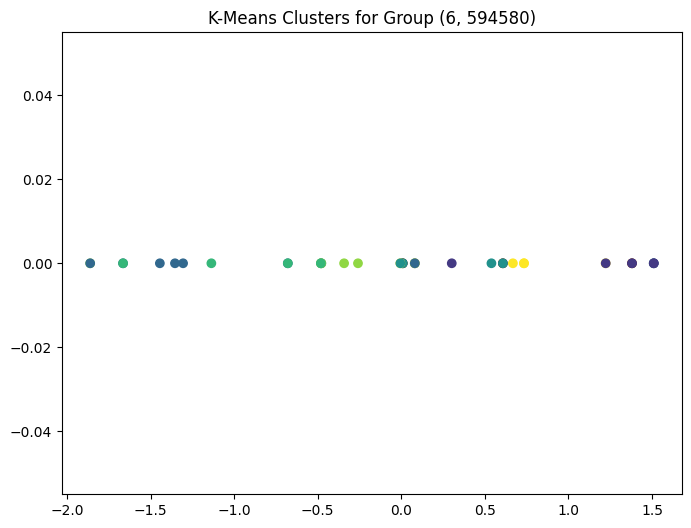

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


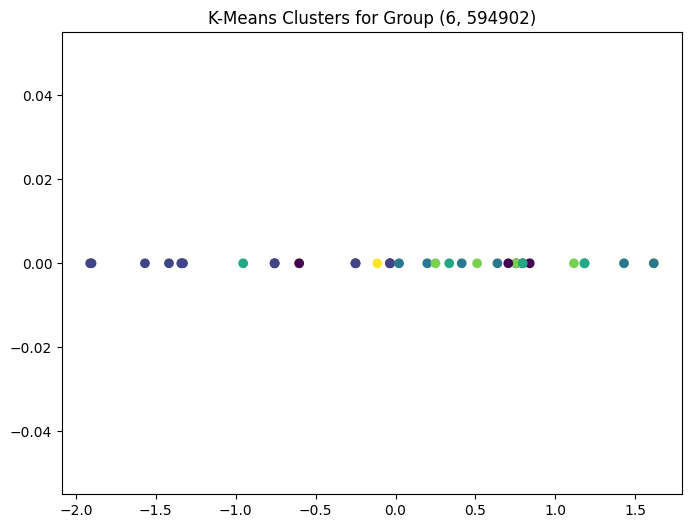

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


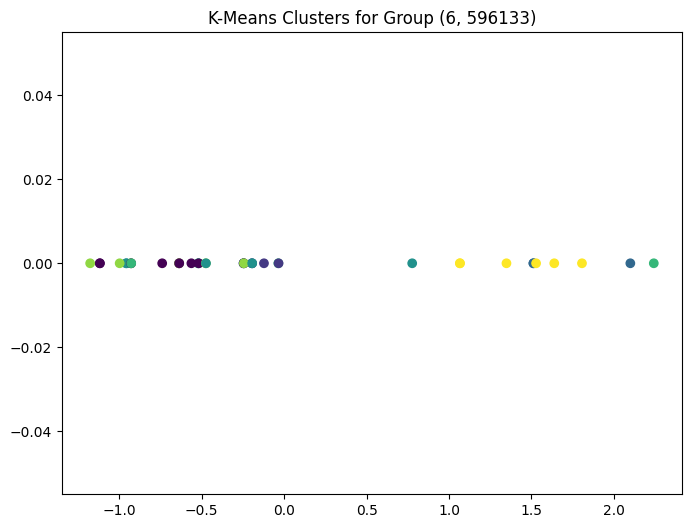

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


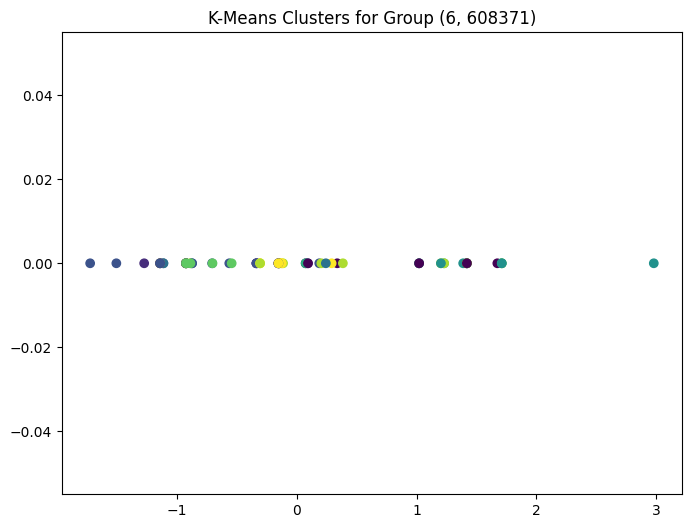

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


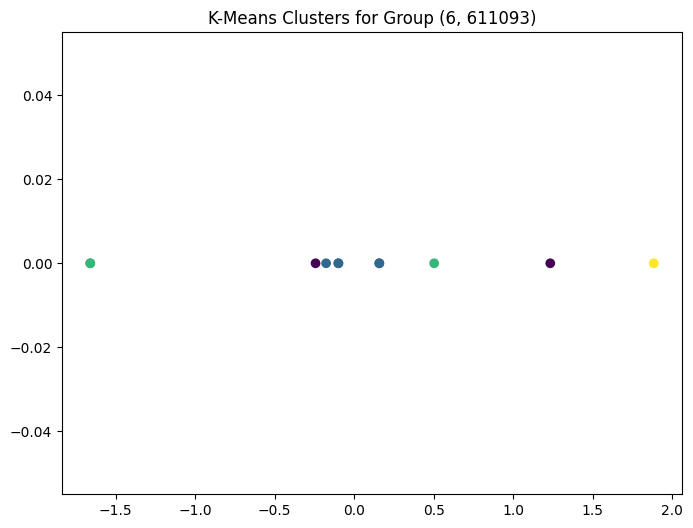

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


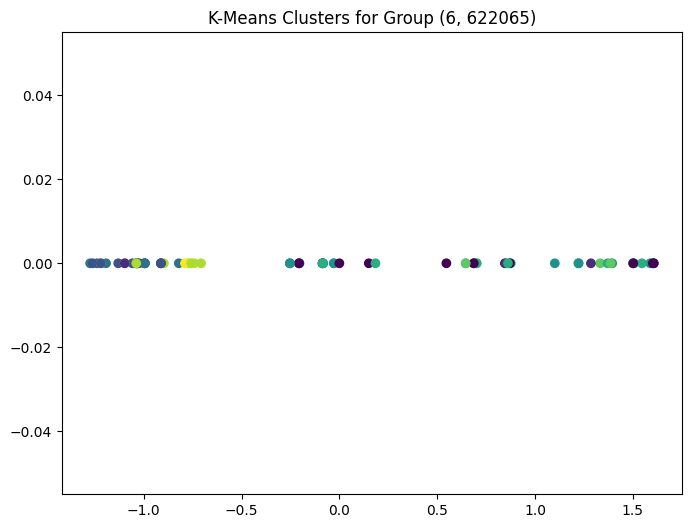

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


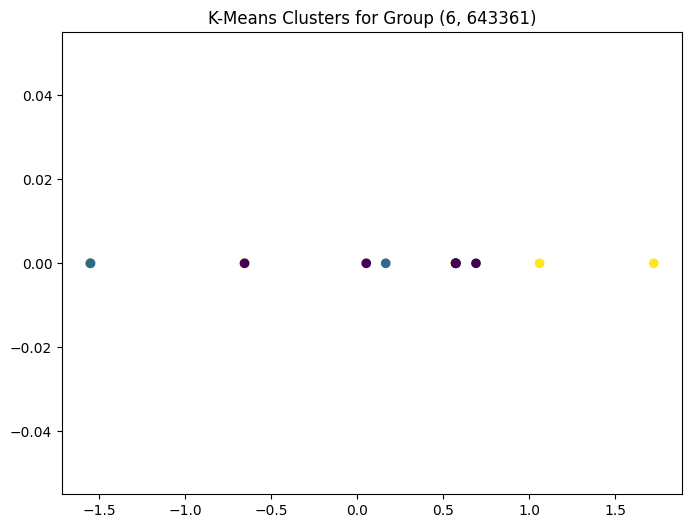

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


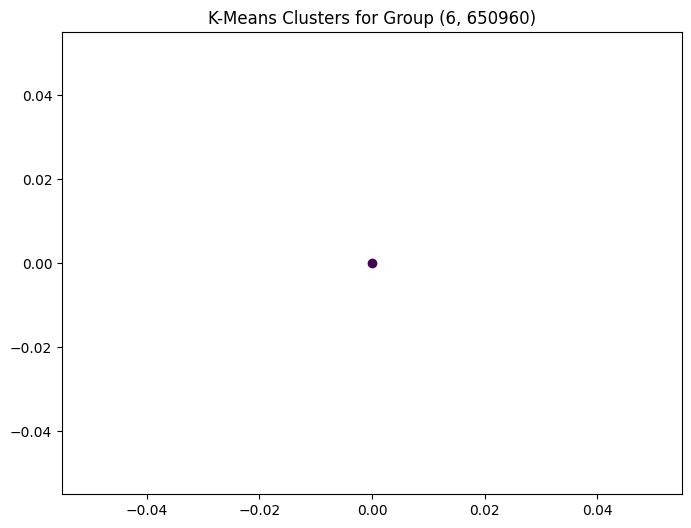

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


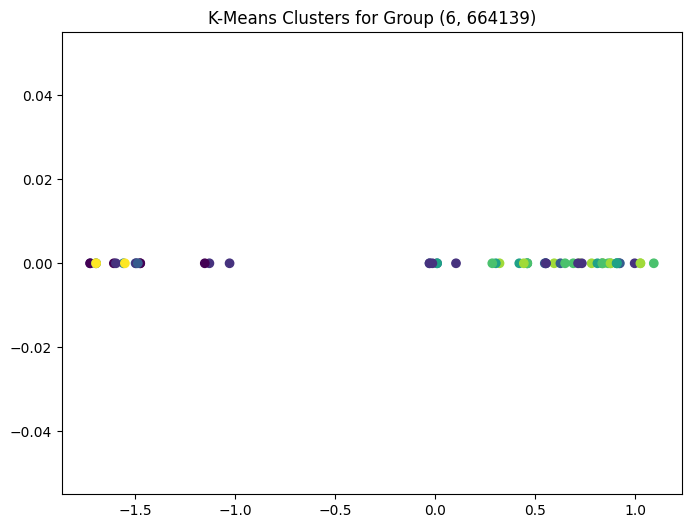

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


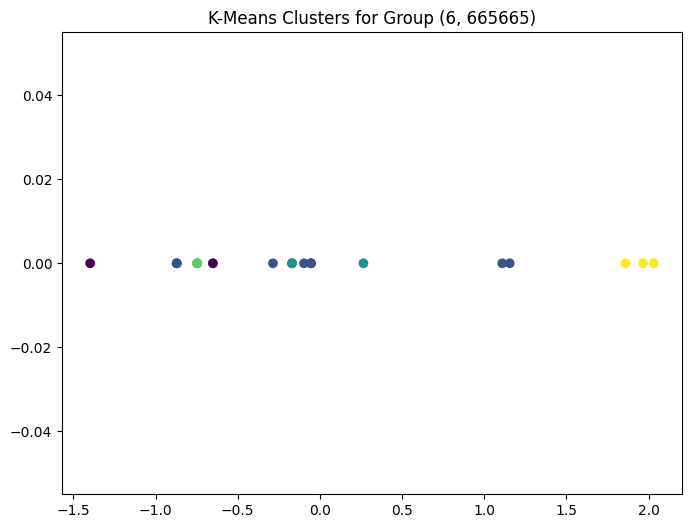

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


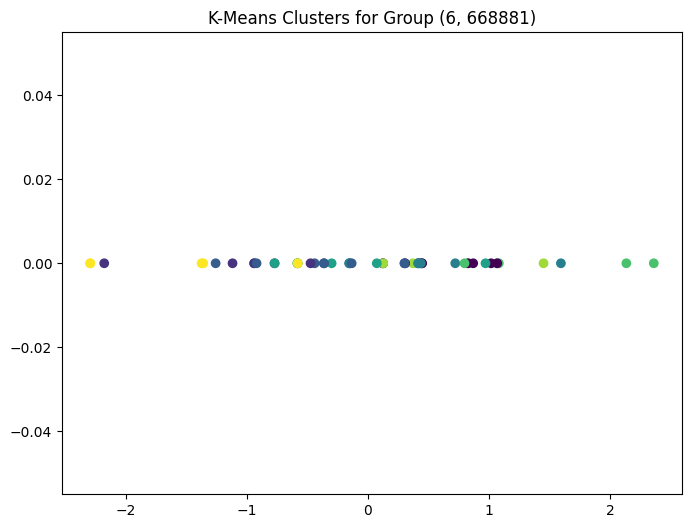

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


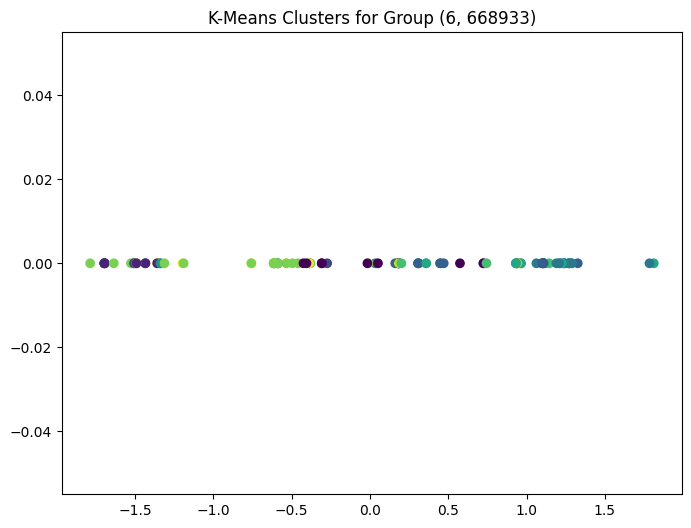

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


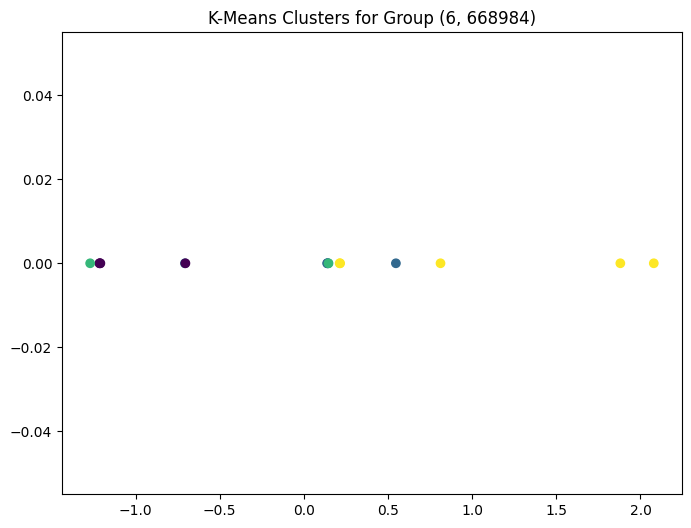

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


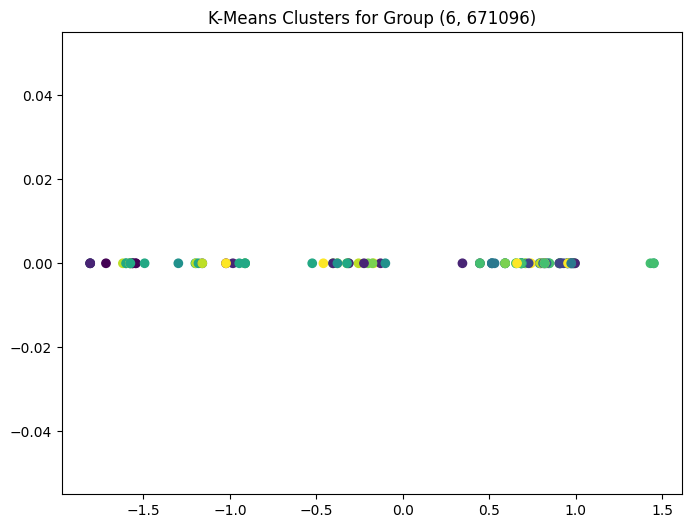

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


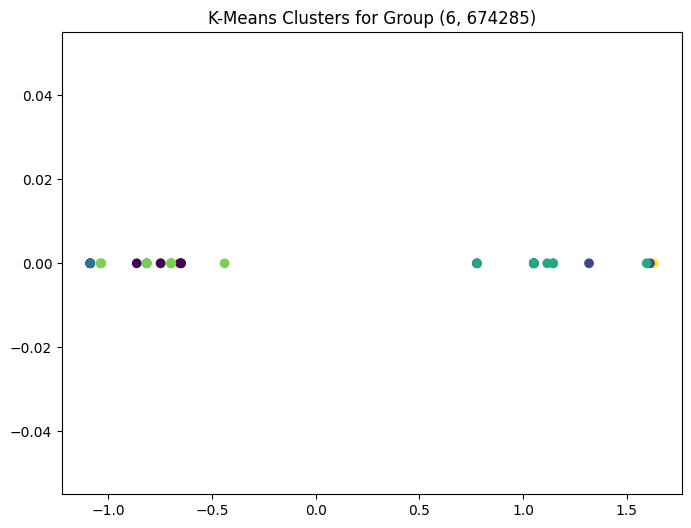

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


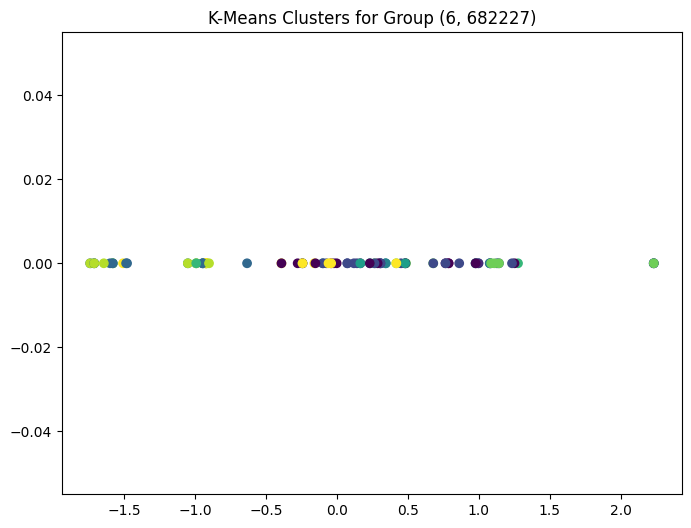

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


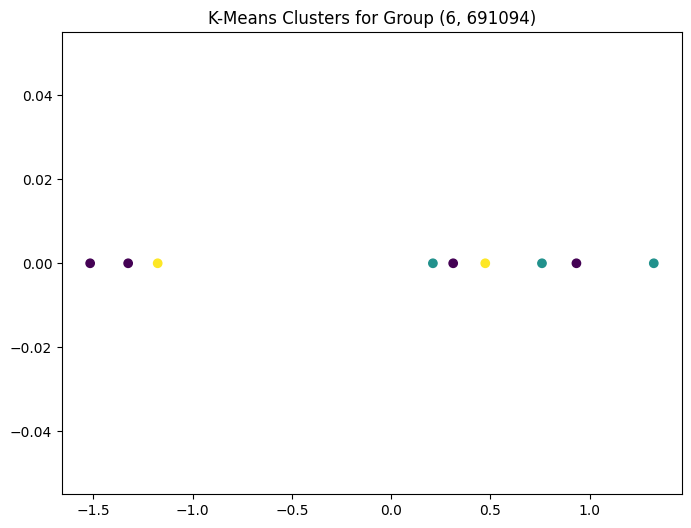

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


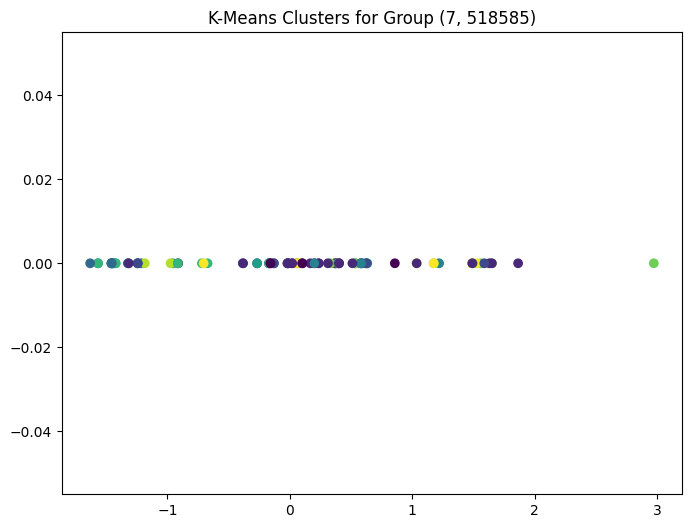

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


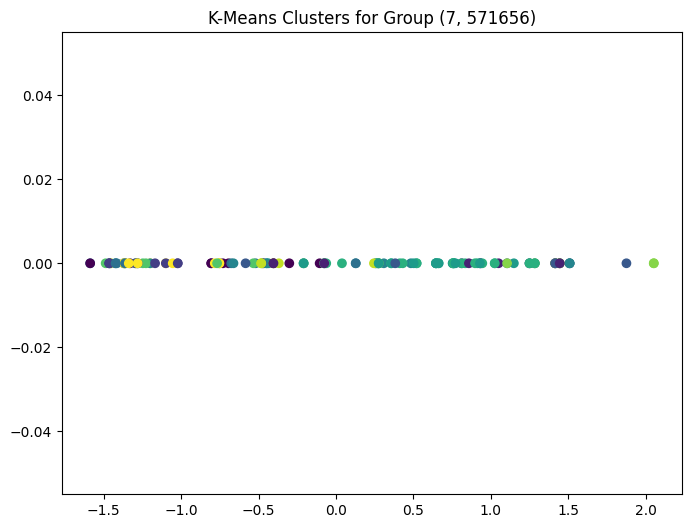

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


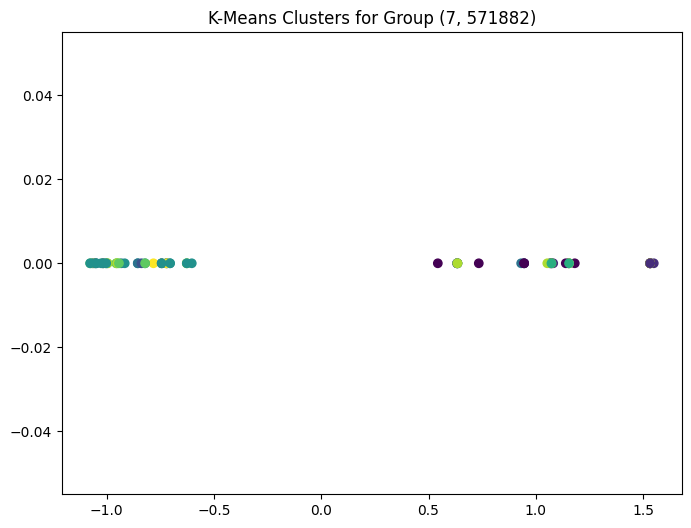

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


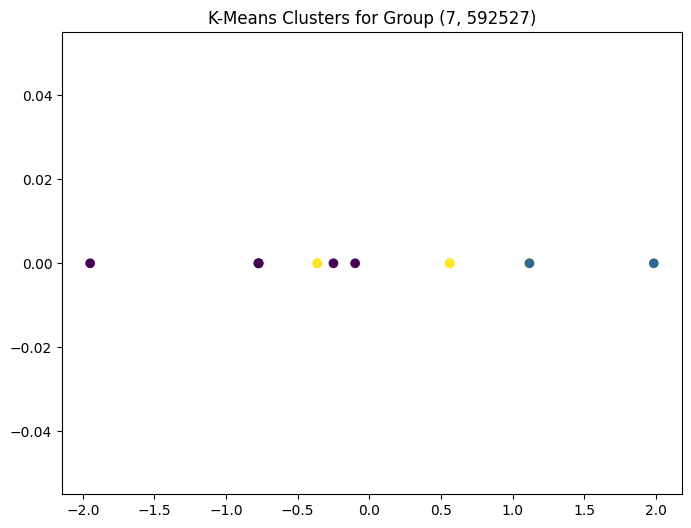

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


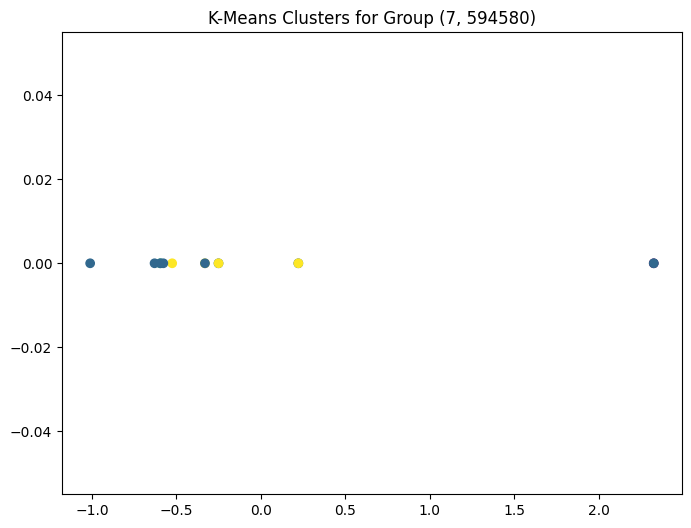

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


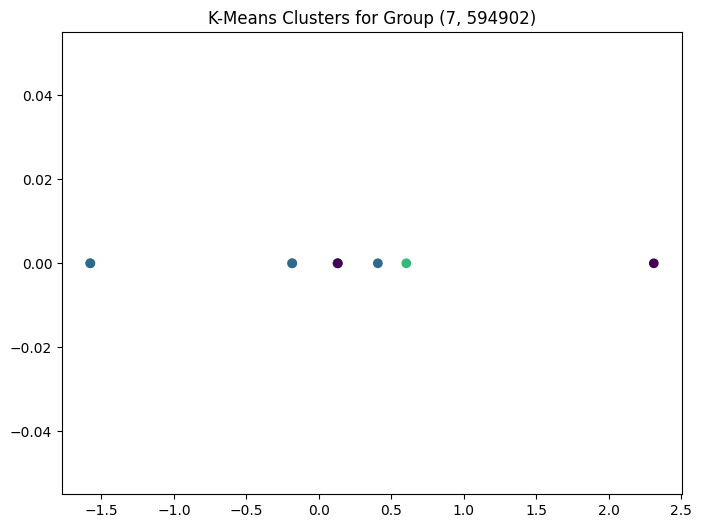

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


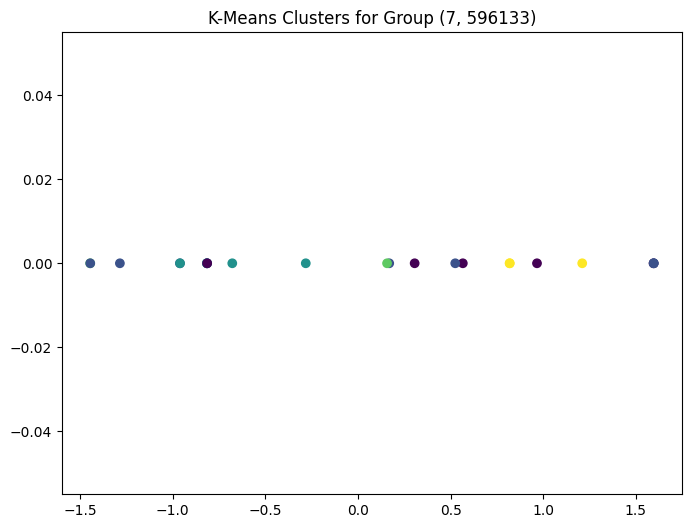

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


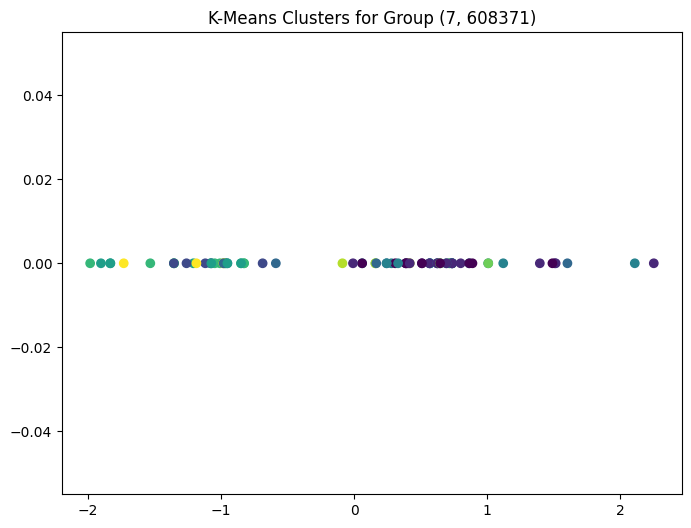

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


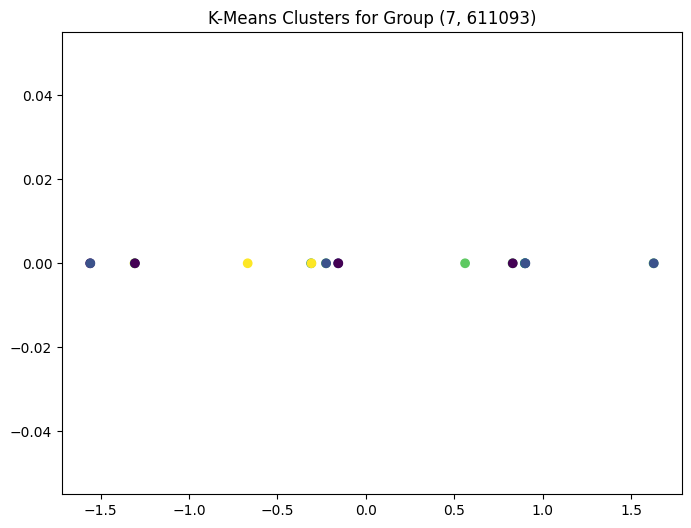

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


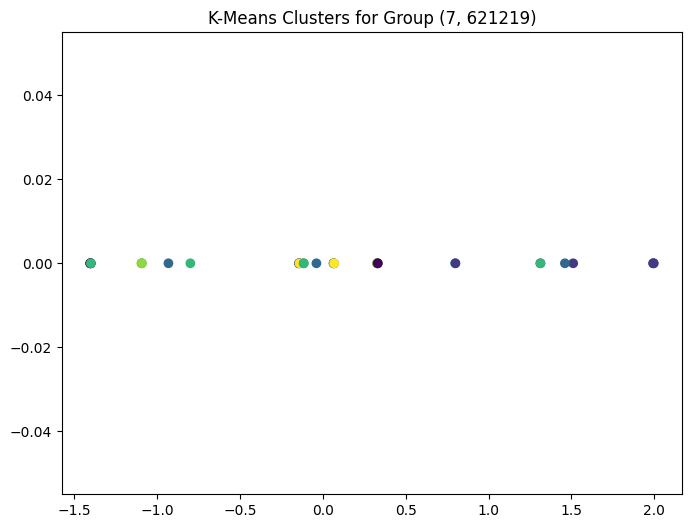

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


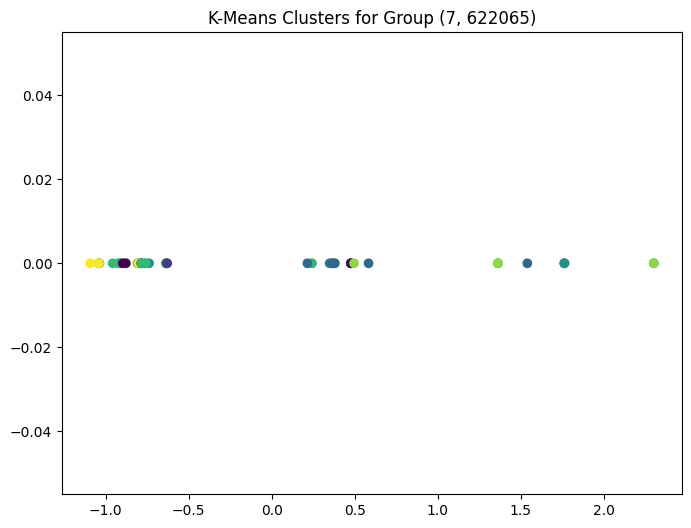

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


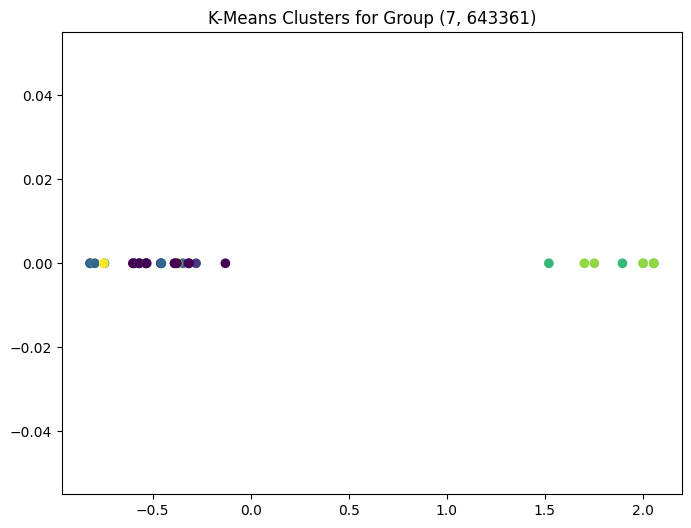

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


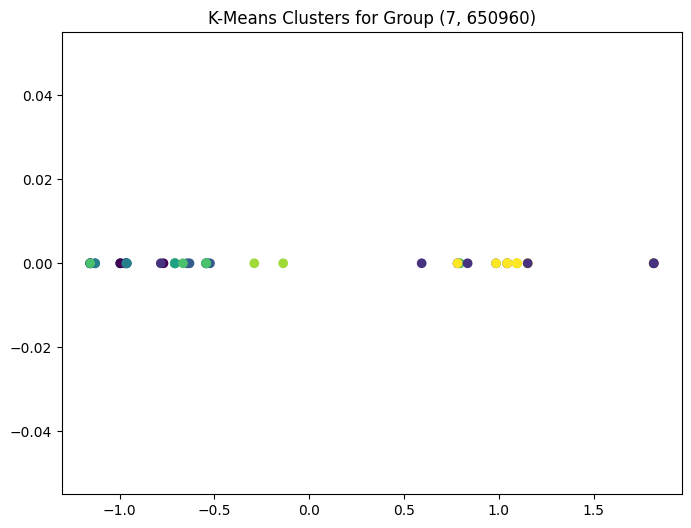

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


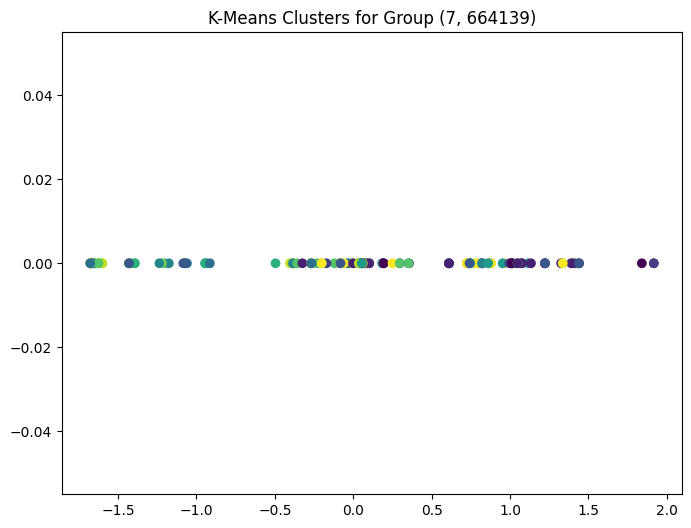

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


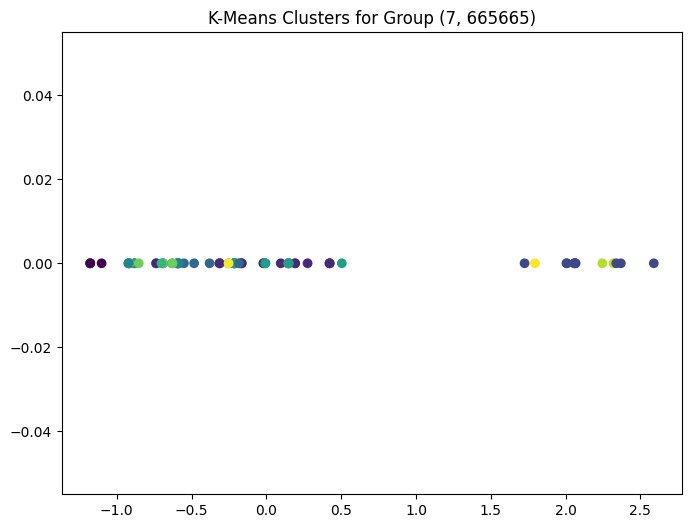

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


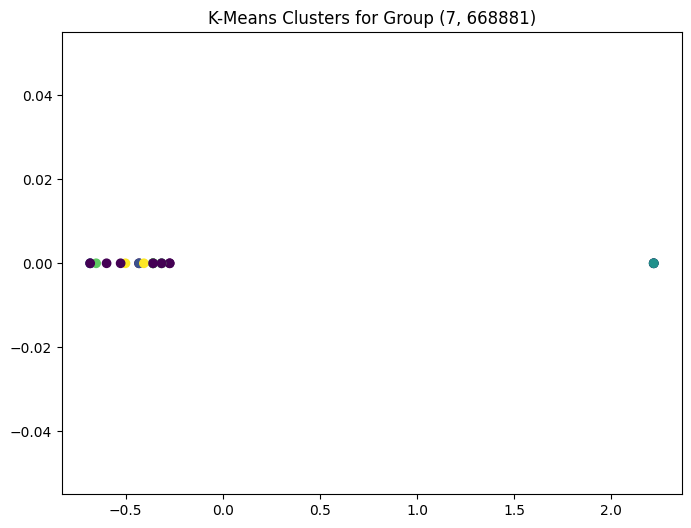

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


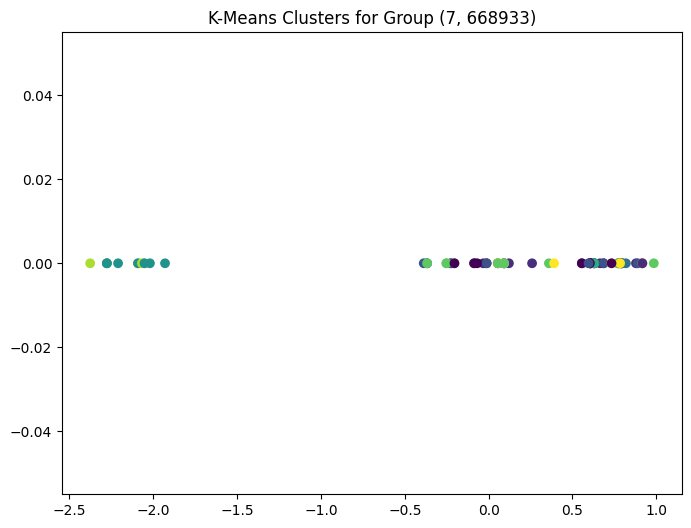

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


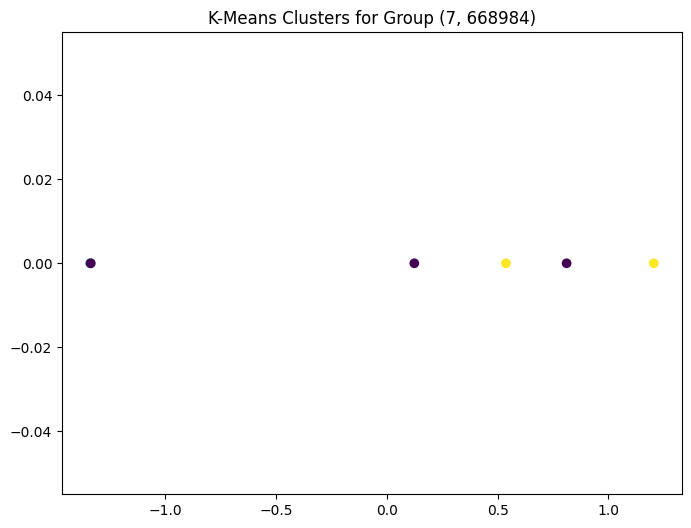

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


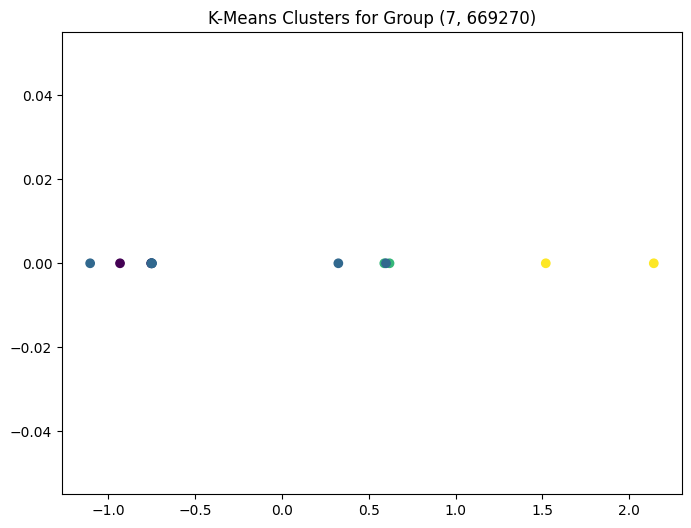

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


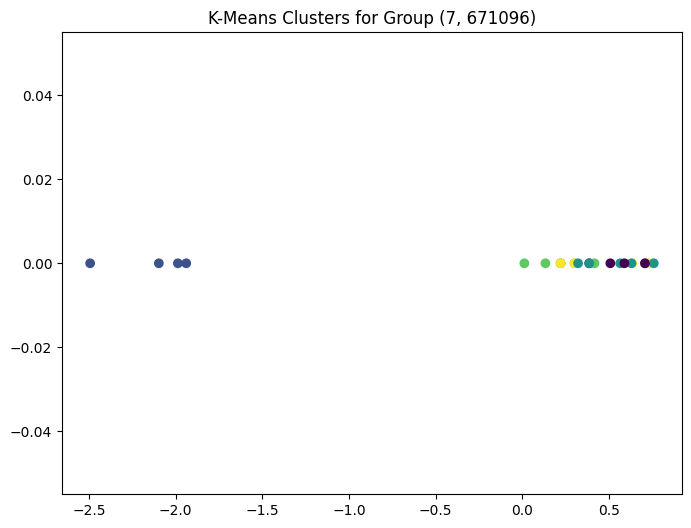

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


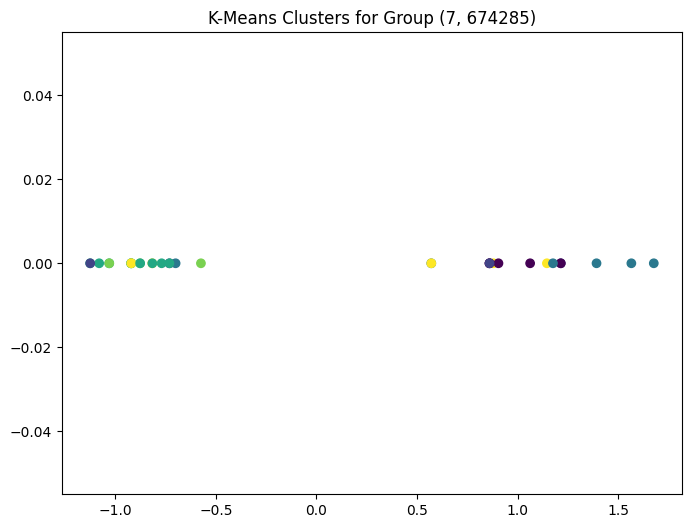

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


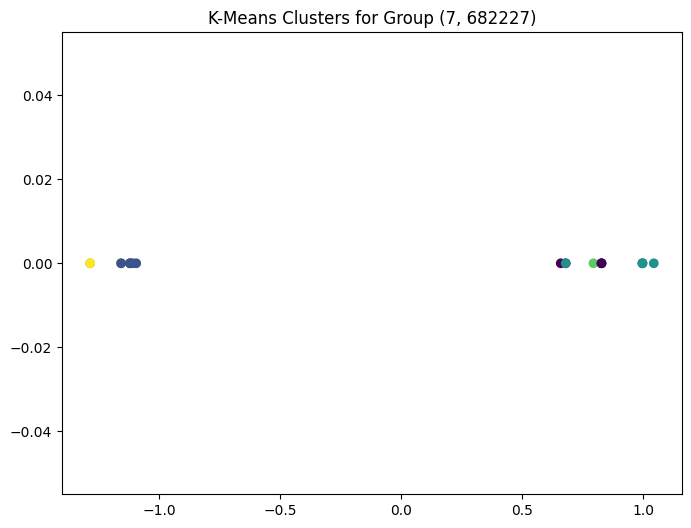

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


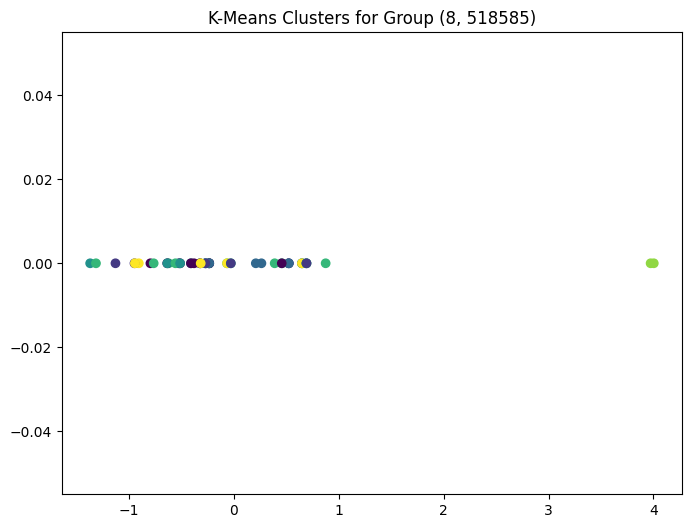

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


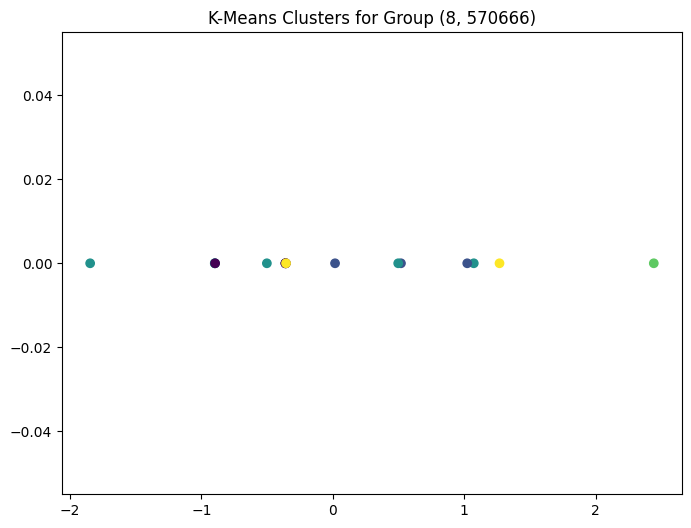

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


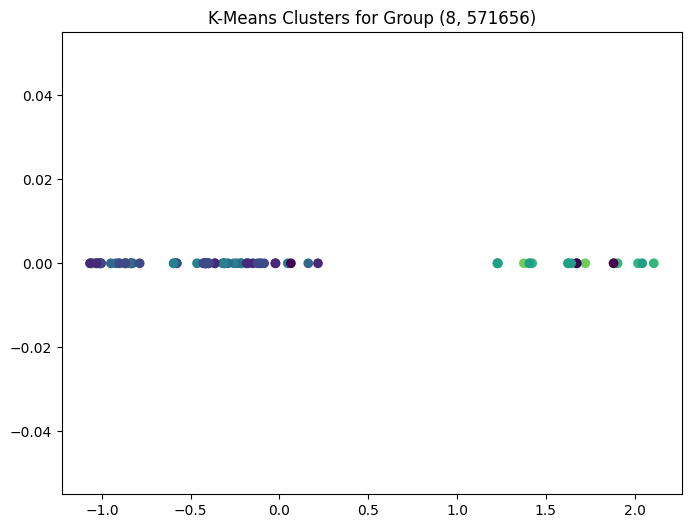

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


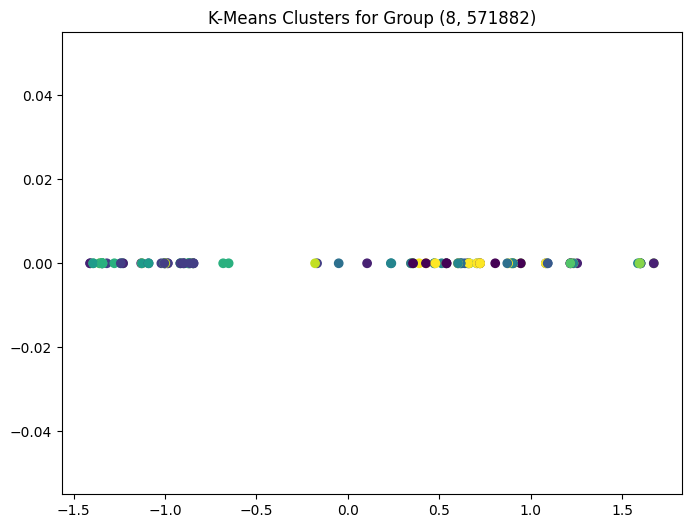

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


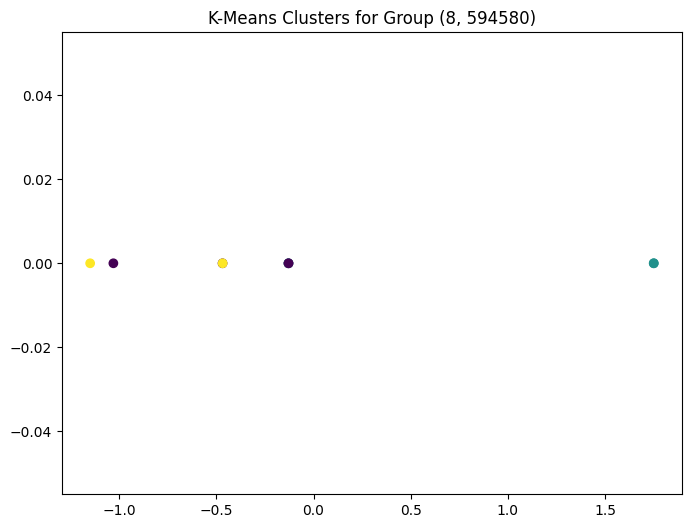

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


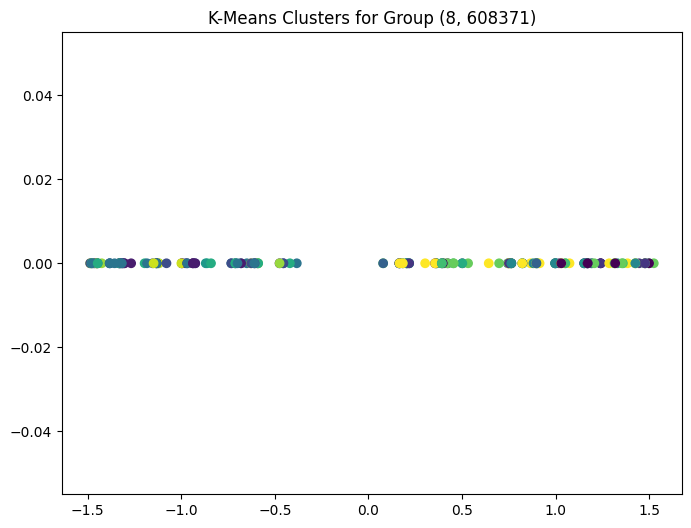

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


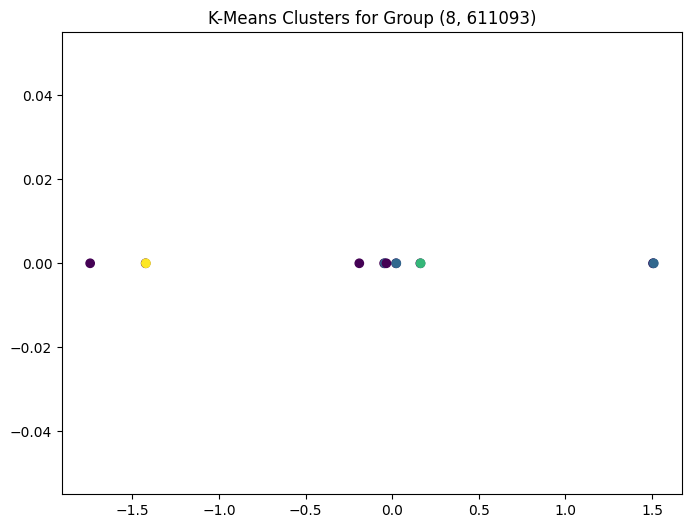

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


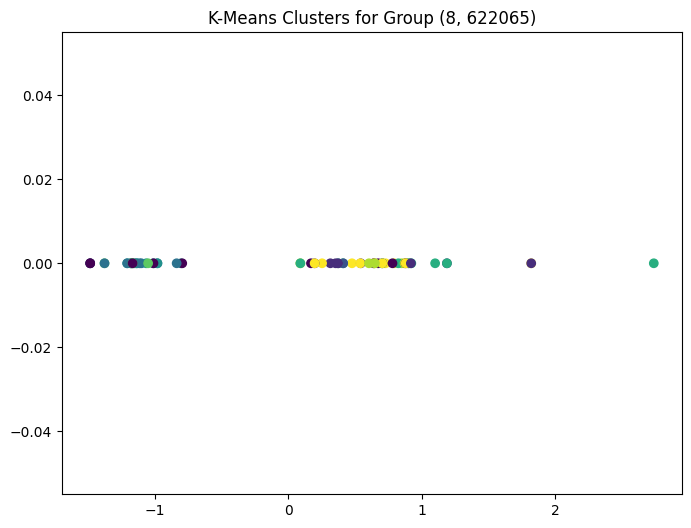

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


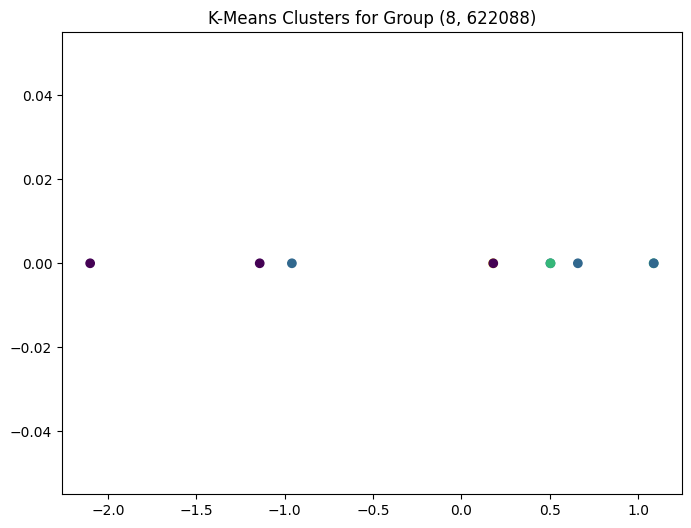

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


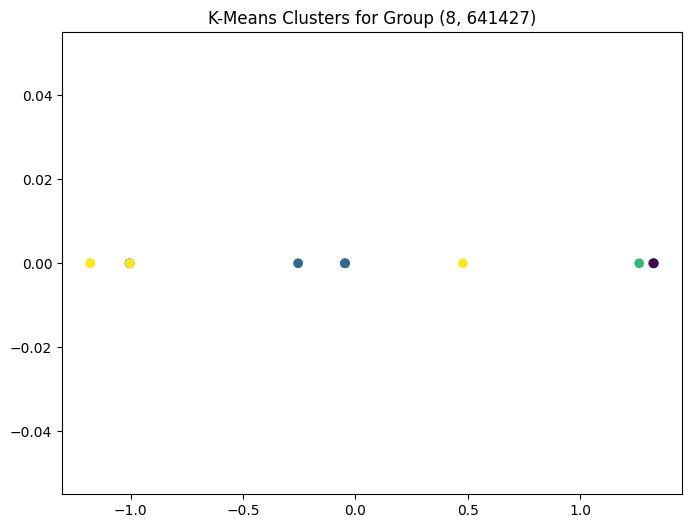

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


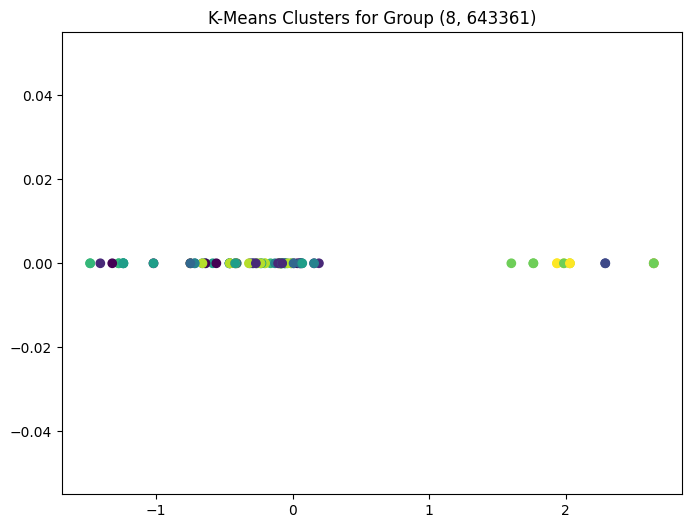

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


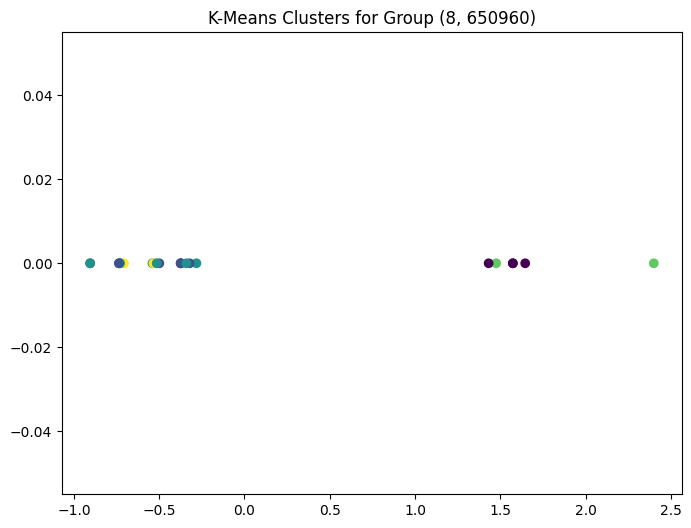

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


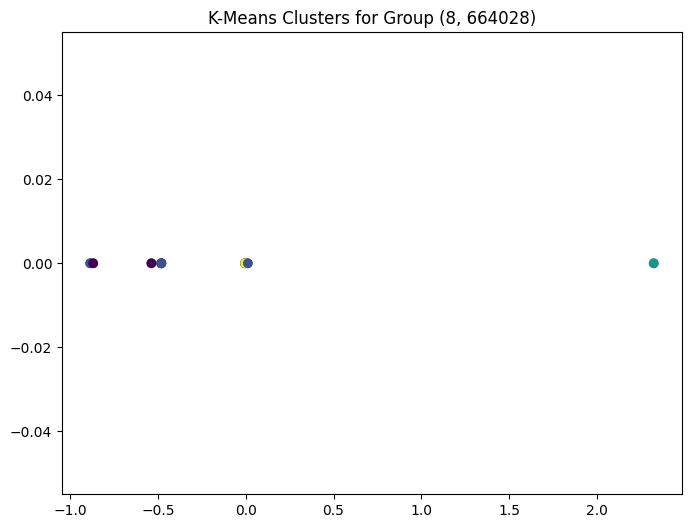

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


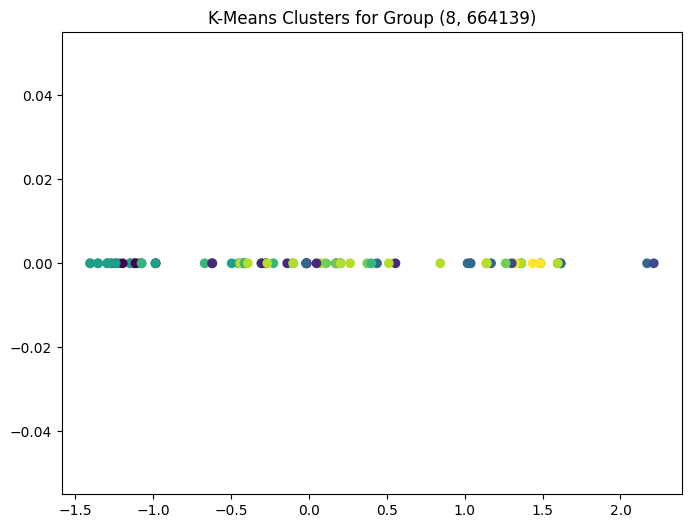

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


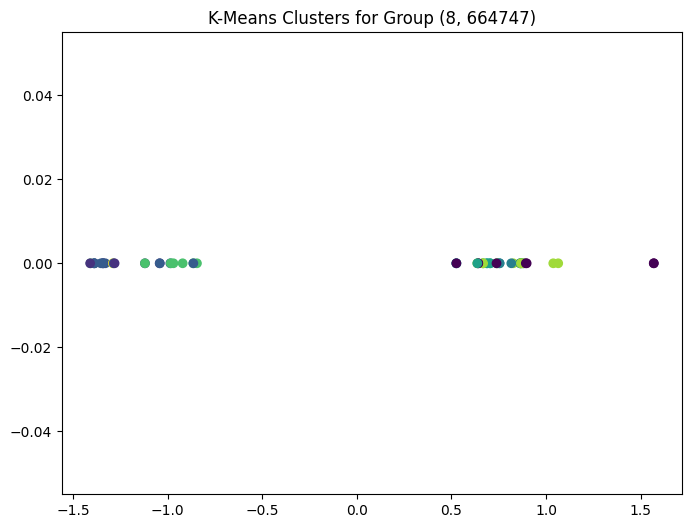

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


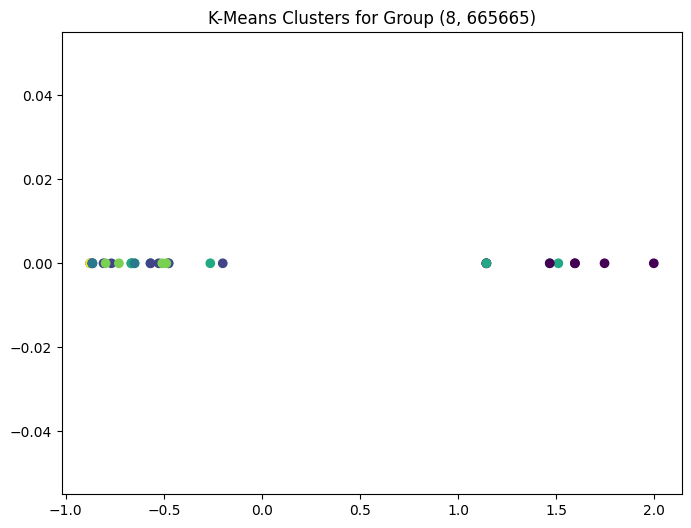

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


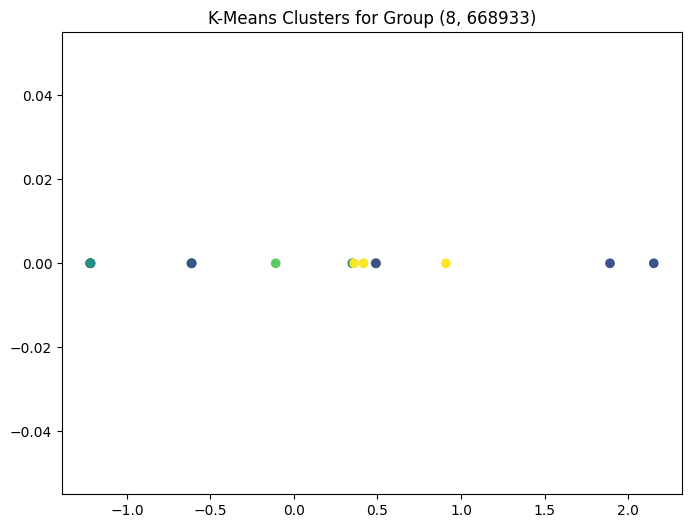

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


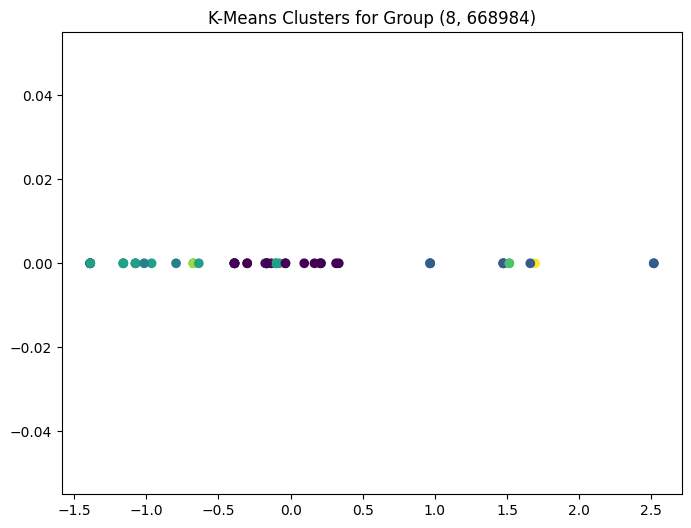

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


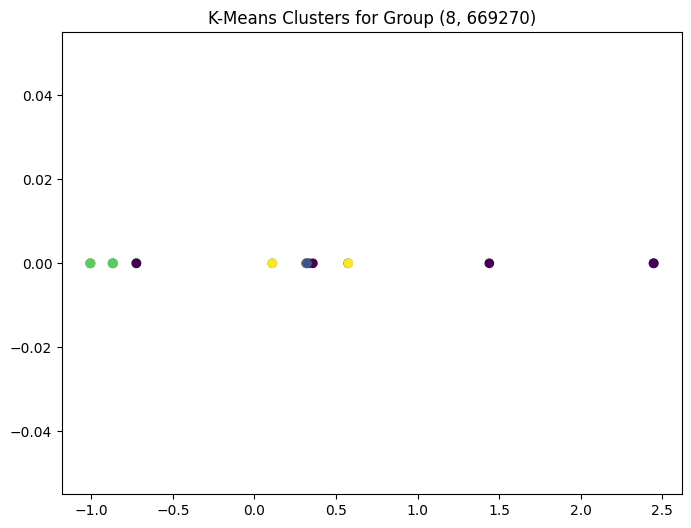

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


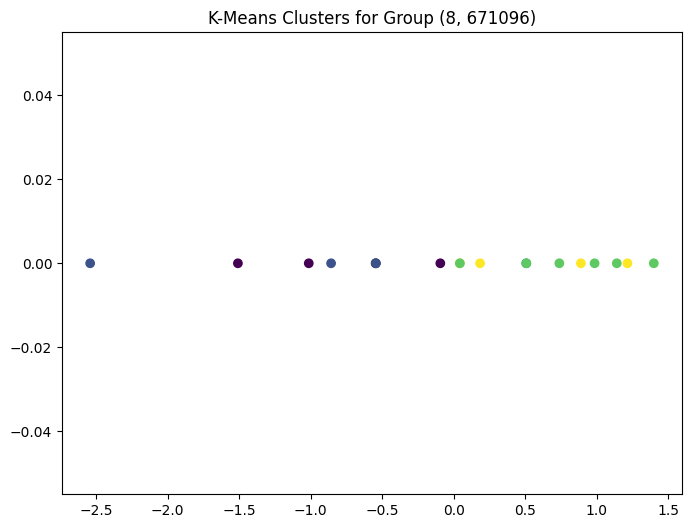

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


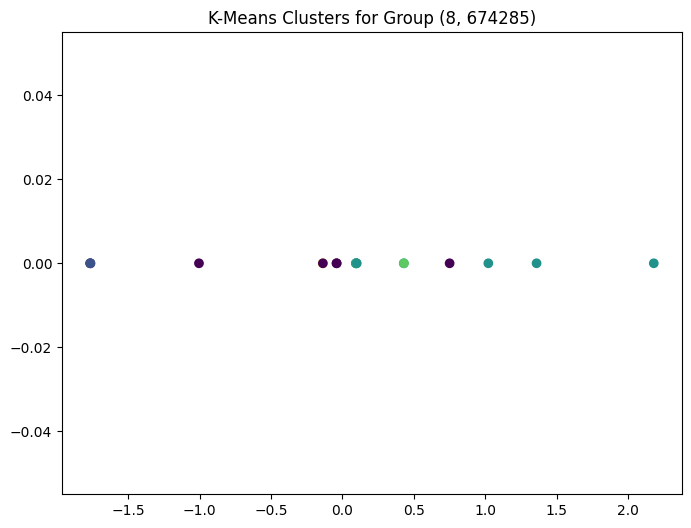

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


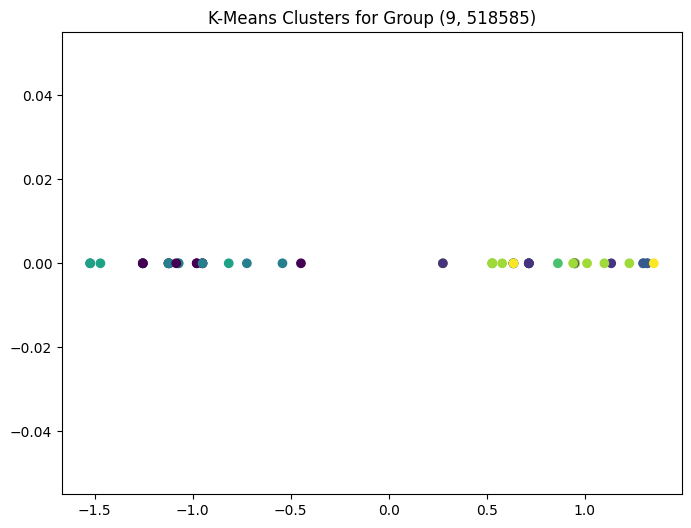

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


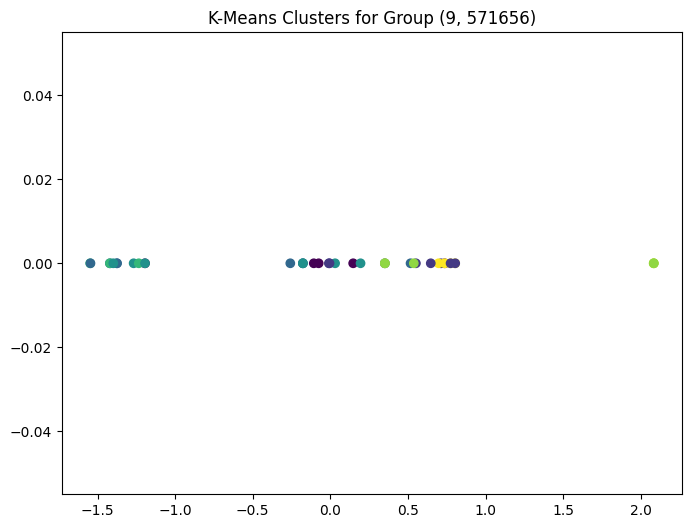

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


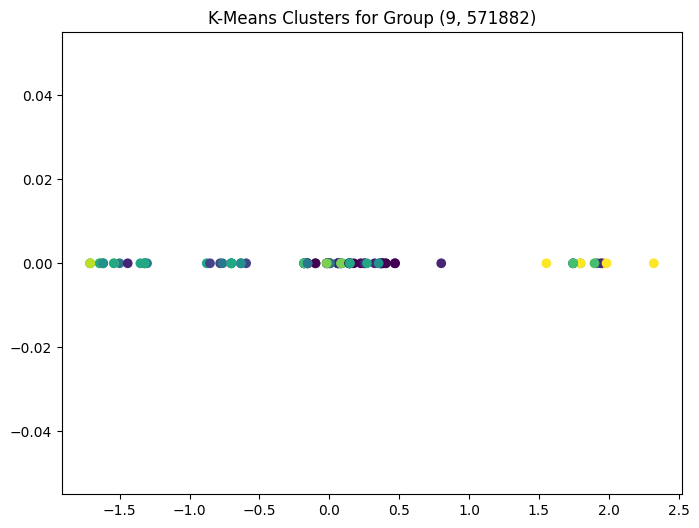

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


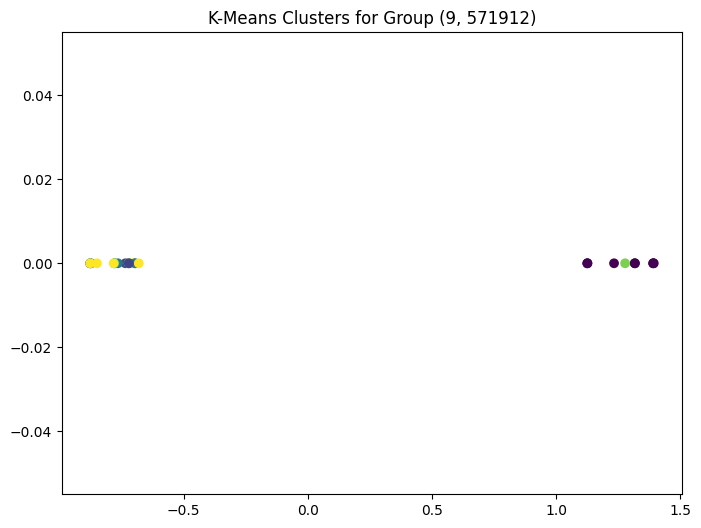

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


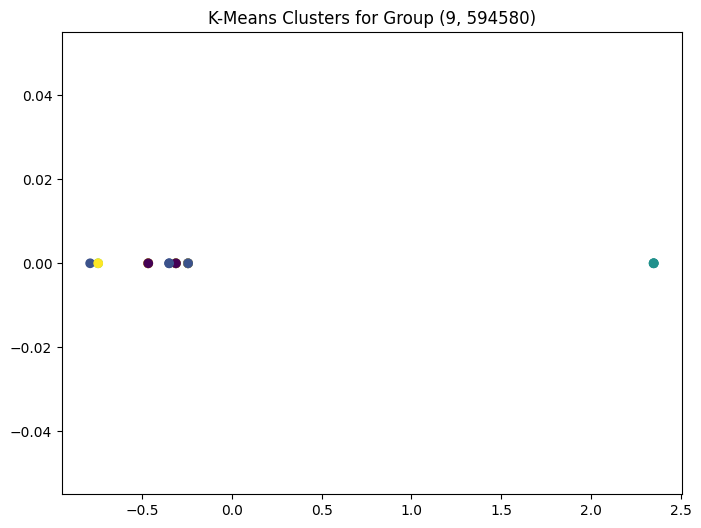

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


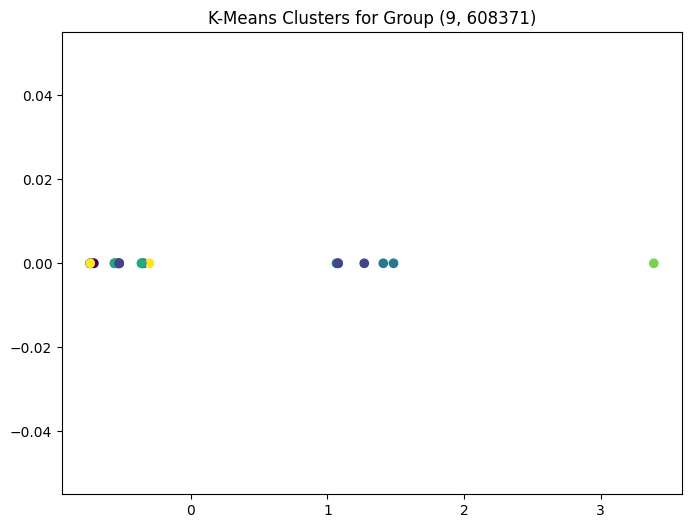

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


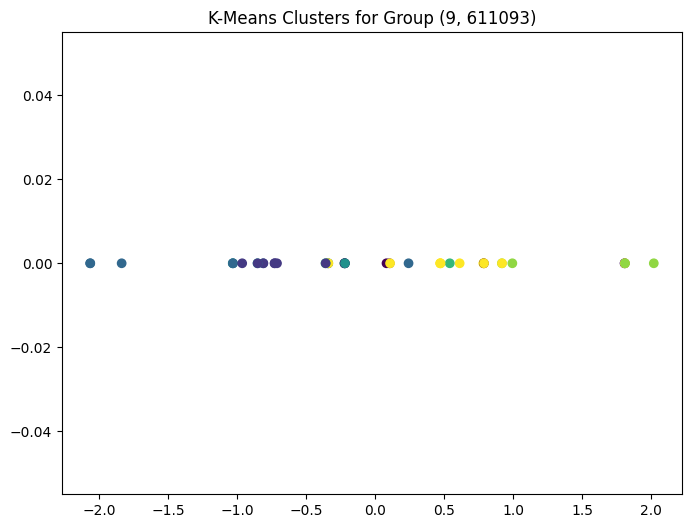

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


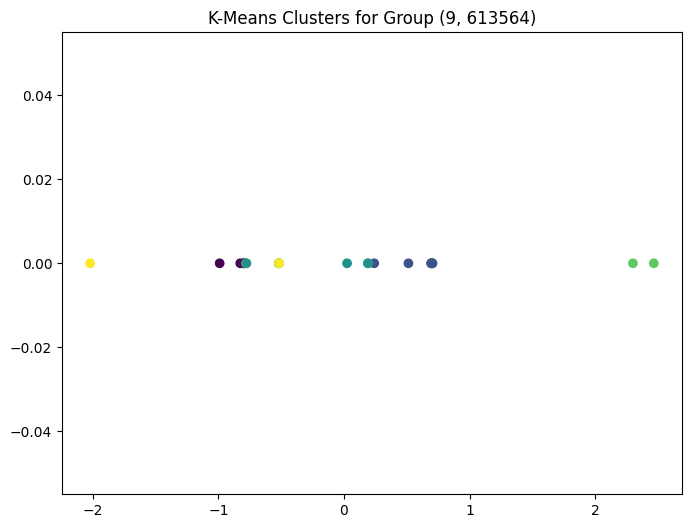

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


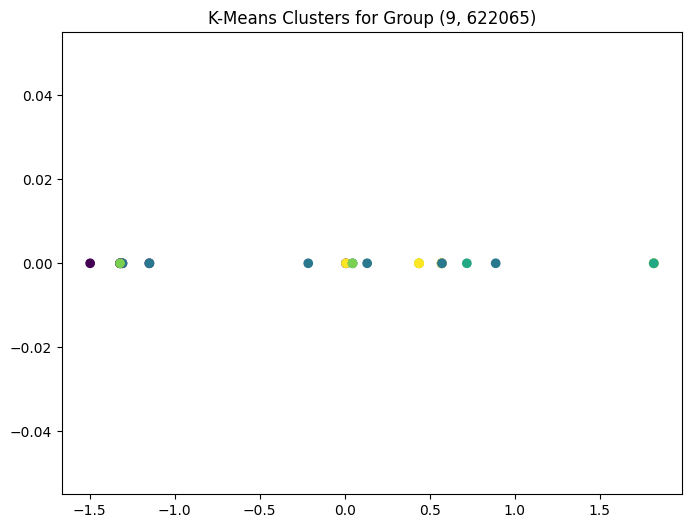

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


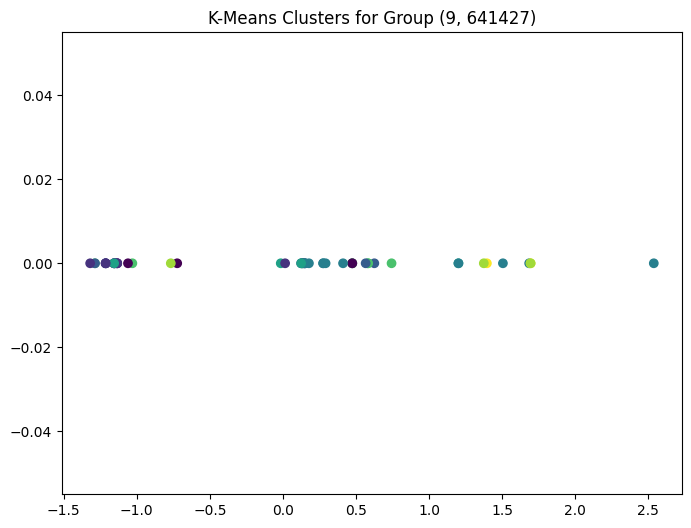

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


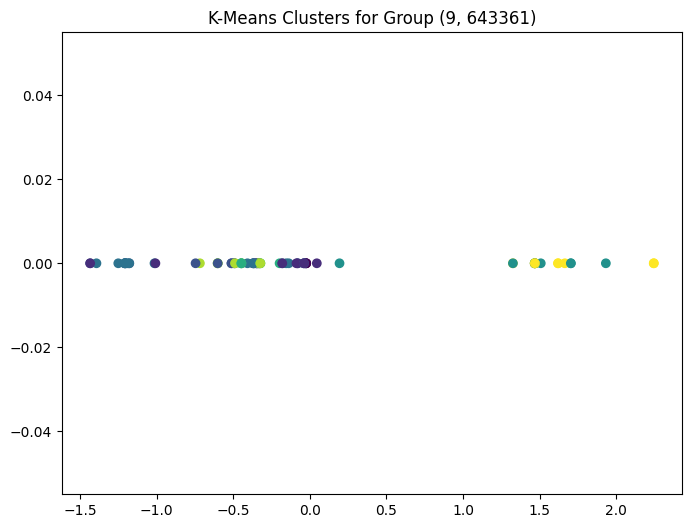

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


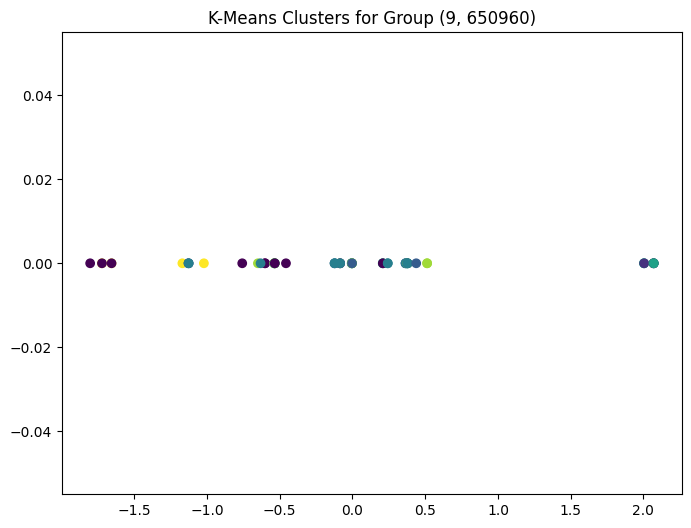

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


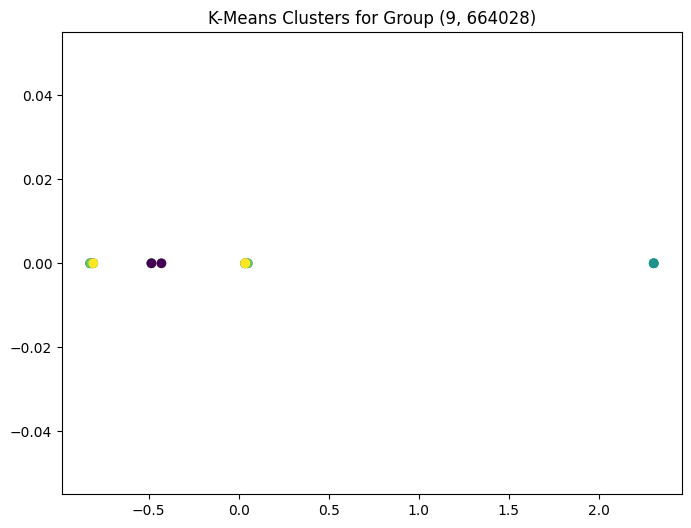

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


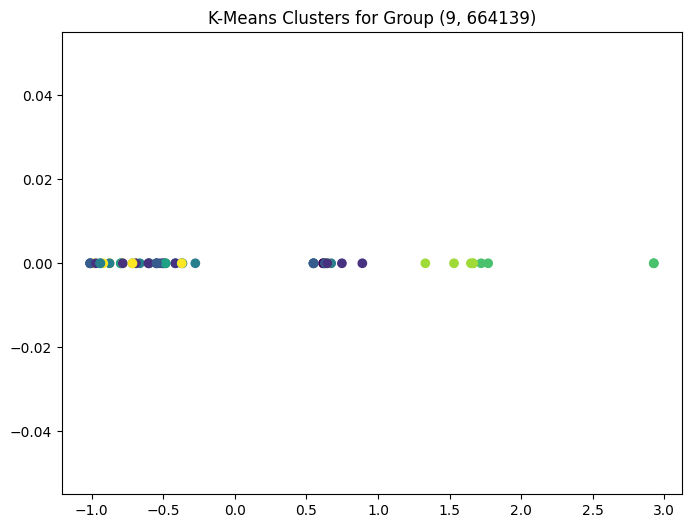

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


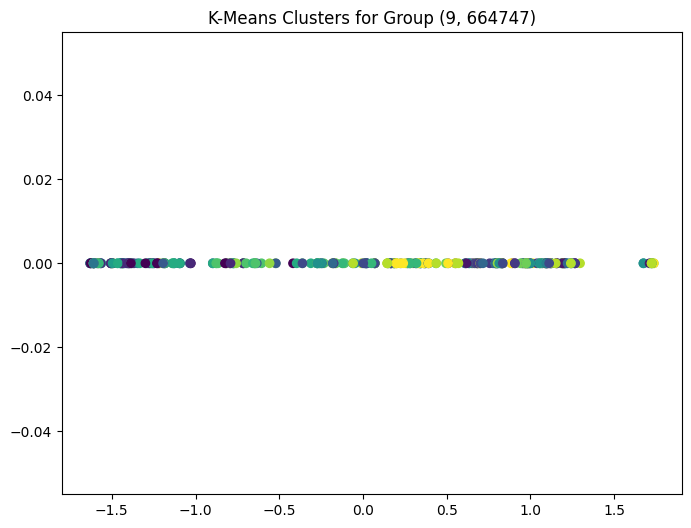

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


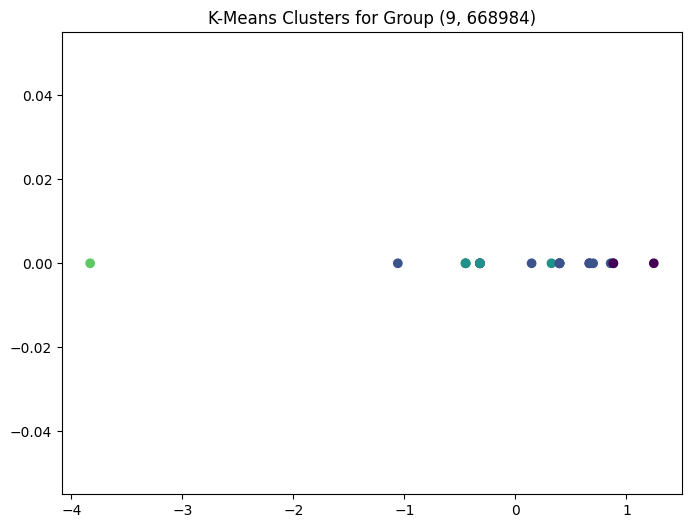

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


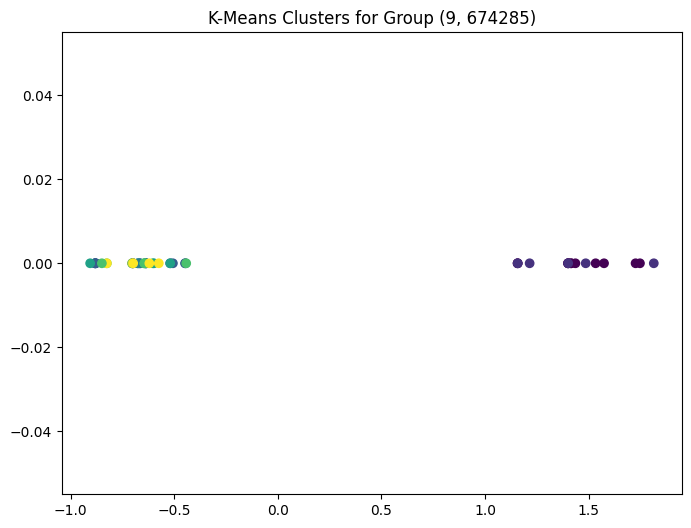

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


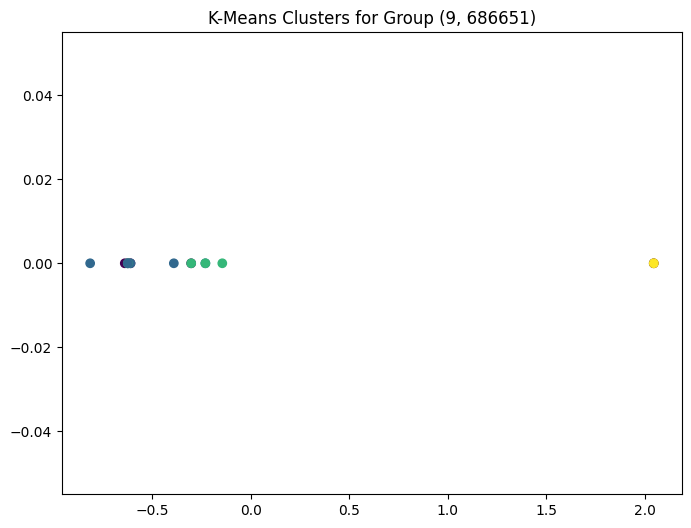

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


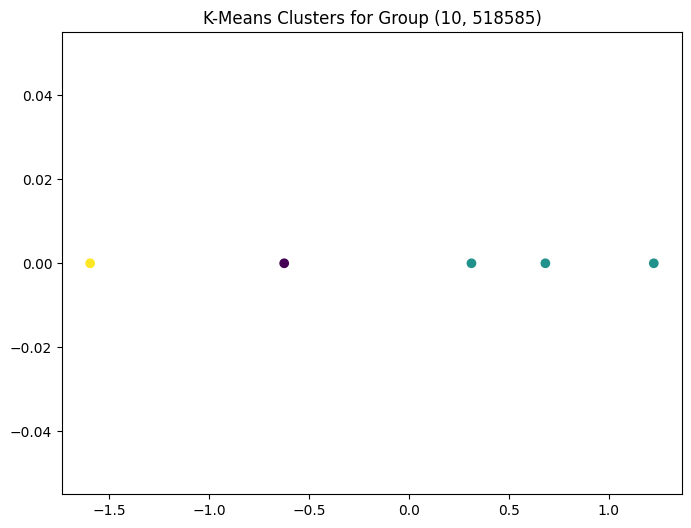

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


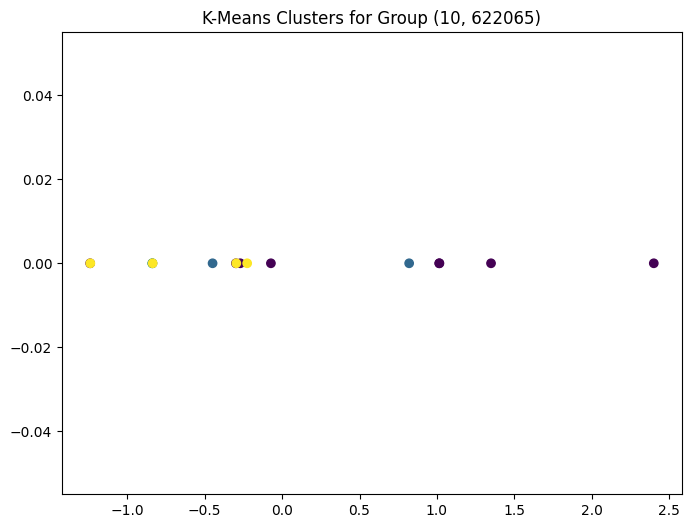

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


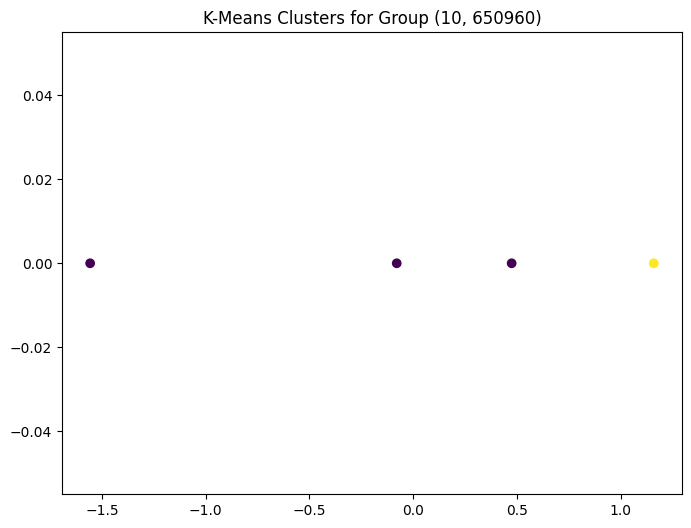

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


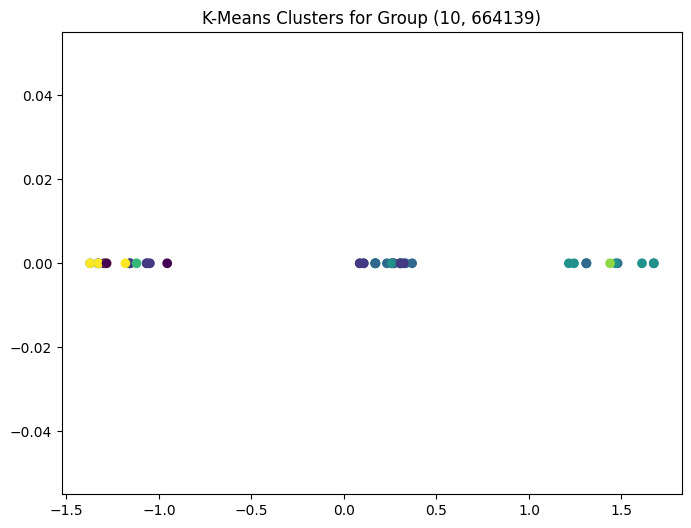

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


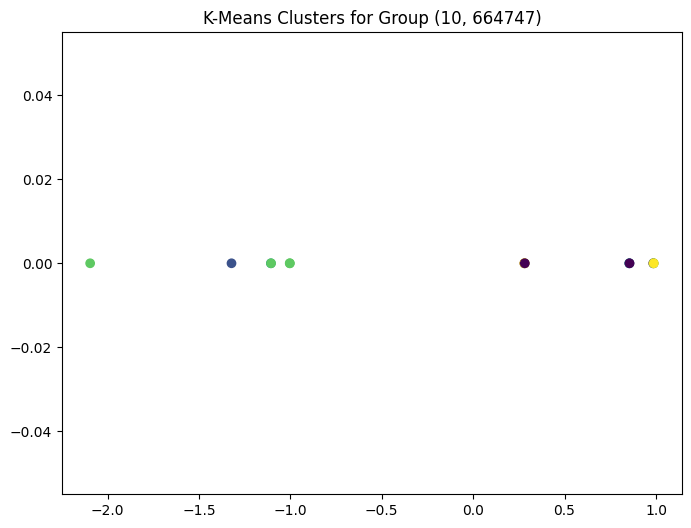

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


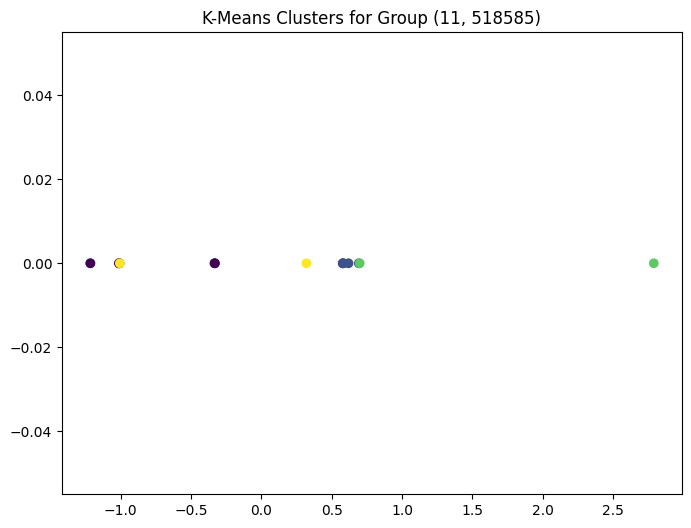

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


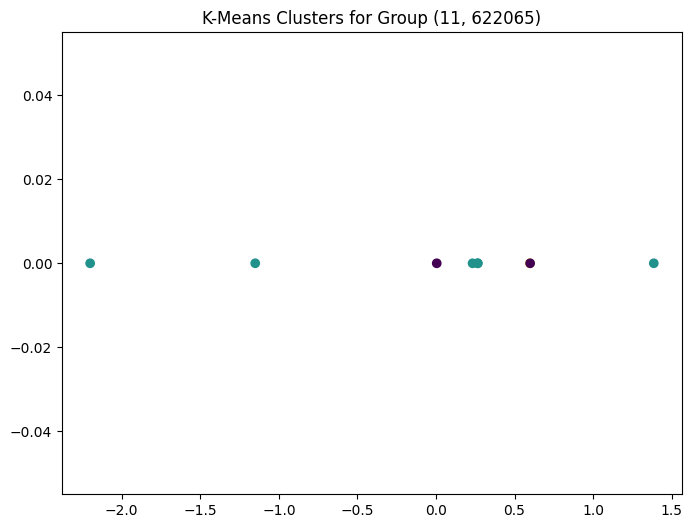

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


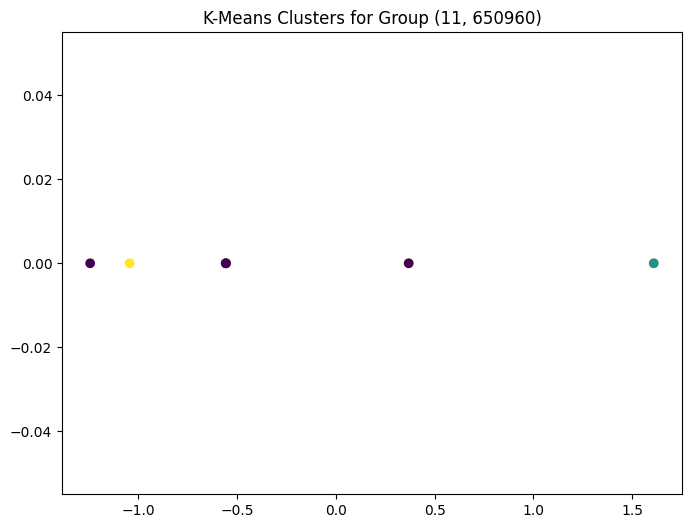

In [55]:
# group the whole data using inning_key/pitcher_key
# separate the is_anomaly and is_not_anomaly
# is_not_anomaly will be my training data to the autoencoder
# im reconstructing the data for the whole dataset and assigning the reconstruction error metric
# as the final probability of pitch data being affected by dew point > 65
dew_probability_data = pd.DataFrame(columns=['PID', 'dew_probability'])
for group_name, group_data in grouped:
  group = find_anomalies(group_name,group_data)
  anomalies_df = group[group['is_anomaly']]
  non_anomalies_df = group[~group['is_anomaly']]
  columns = ['PID','VERTICAL_APPROACH_ANGLE', 'INDUCED_VERTICAL_BREAK', 'RELEASE_SPEED',
             'RELEASE_SIDE', 'PLATE_X', 'THROW_SIDE_KEY', 'PLATE_Z', 'HORIZONTAL_BREAK']
  anomalies_df = anomalies_df[columns]
  non_anomalies_df = non_anomalies_df[columns]
  X_train = torch.tensor(non_anomalies_df.values, dtype=torch.float32)
  X_test = torch.tensor(anomalies_df.values, dtype=torch.float32)
  X_data = torch.tensor(group[columns].values, dtype=torch.float32)
  input_dim = X_train.shape[1]
  model = Autoencoder(input_dim)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 100
  for epoch in range(num_epochs):
      outputs = model(X_train)
      loss = criterion(outputs, X_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  with torch.no_grad():
    reconstructed_data = model(X_data)
    errors = torch.mean((X_data - reconstructed_data) ** 2, dim=1)

  mean_error = torch.mean(errors)
  std_error = torch.std(errors)
  z_scores = (errors - mean_error) / std_error
  dew_probabilities = 1 - 1 / (1 + torch.exp(-z_scores))
  group_dew_probabilities = pd.DataFrame({'PID': group['PID'], 'dew_probability': dew_probabilities })
  dew_probability_data = pd.concat([dew_probability_data, group_dew_probabilities.reset_index(drop=True)], ignore_index=True)

In [56]:
print(dew_probability_data)

        PID  dew_probability
0     18494         0.159140
1     16316         0.259574
2     17403         0.197192
3     18903         0.136059
4     16480         0.243629
...     ...              ...
9884  23297         0.403505
9885  23298         0.429929
9886  22540         0.627800
9887  24314         0.169664
9888  24315         0.188255

[9889 rows x 2 columns]


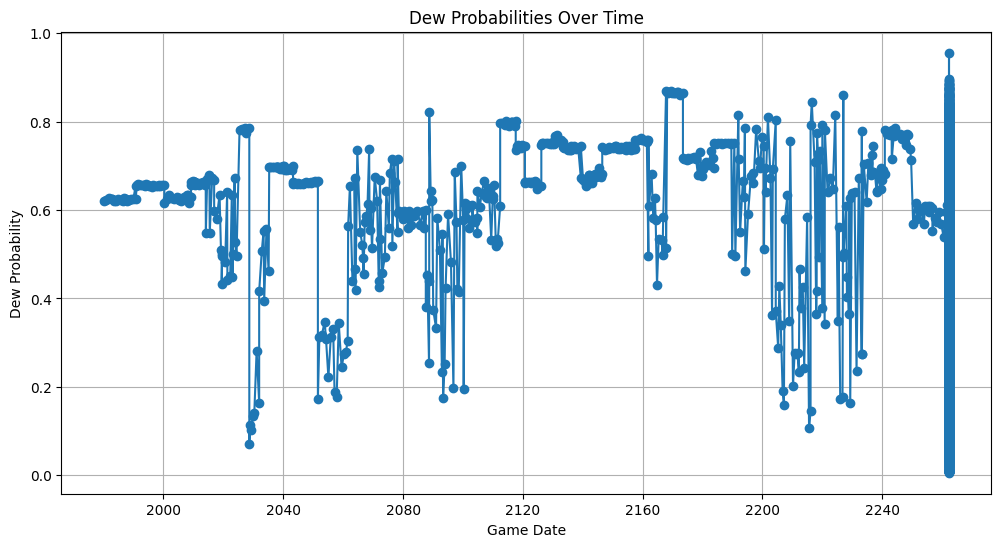

In [58]:
# Create a time series plot between game date and dew probability
for index, row in dew_probability_data.iterrows():
    pid = row['PID']
    # Retrieve the game date for the current PID from the data DataFrame
    game_date = data_with_date[data_with_date['PID'] == pid]['game_date'].values[0]
    dew_probability_data.at[index, 'game_date'] = game_date
dew_probability_data = dew_probability_data.sort_values(by='game_date')
plt.figure(figsize=(12, 6))
plt.plot(dew_probability_data['game_date'], dew_probability_data['dew_probability'], marker='o')
plt.title('Dew Probabilities Over Time')
plt.xlabel('Game Date')
plt.ylabel('Dew Probability')
plt.grid(True)
plt.show()

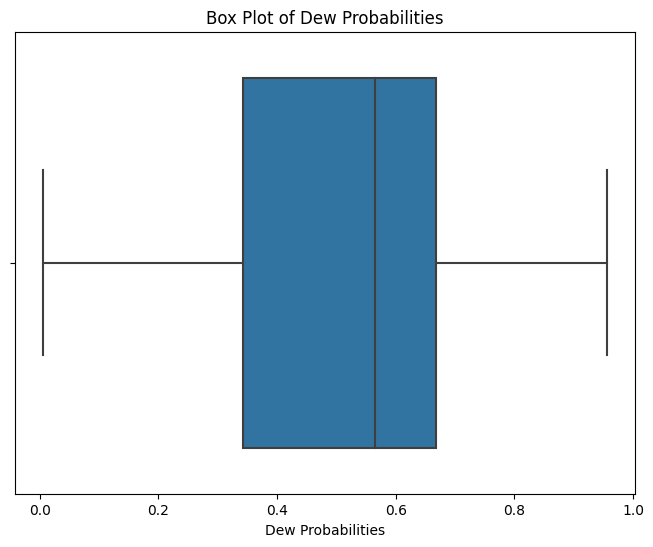

In [59]:
#box plots
plt.figure(figsize=(8, 6))
sns.boxplot(x=dew_probability_data['dew_probability'])
plt.title('Box Plot of Dew Probabilities')
plt.xlabel('Dew Probabilities')
plt.show()


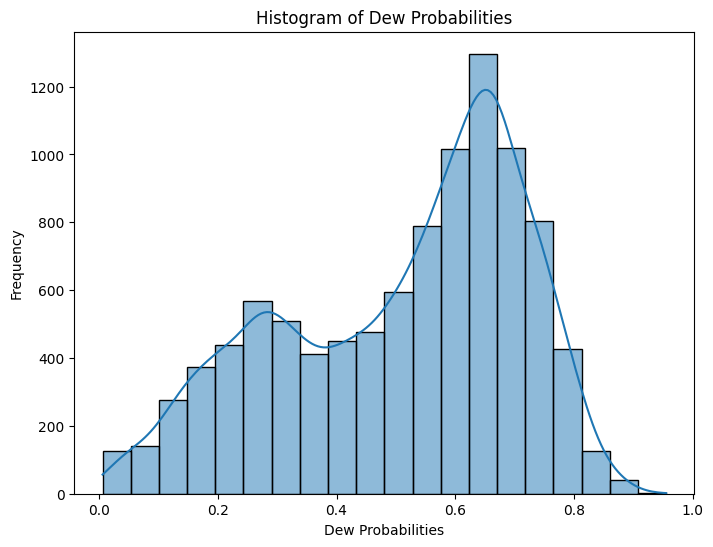

In [60]:
#hist plot
plt.figure(figsize=(8, 6))
sns.histplot(data=dew_probability_data, x='dew_probability', bins=20, kde=True)
plt.title('Histogram of Dew Probabilities')
plt.xlabel('Dew Probabilities')
plt.ylabel('Frequency')
plt.show()

In [68]:
data = pd.read_csv('data.csv')
pid_dewpoint_pairs = []
for index, row in data.iterrows():
  pid = row['PID']
  matching_row = dew_probability_data[dew_probability_data['PID'] == pid]
  dew_prob = matching_row.iloc[0]['dew_probability']
  pid_dewpoint_pairs.append((pid, dew_prob))
result_df = pd.DataFrame(pid_dewpoint_pairs, columns=['PID', 'dewpoint_affected'])
print(result_df.head())
result_df.to_csv('pid_dewpoint_pairs.csv')


    PID  dewpoint_affected
0   197           0.620439
1   348           0.621540
2  1072           0.626181
3   420           0.624835
4   198           0.624110
